In [49]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib import image
import numpy as np
from PIL import Image

import tensorflow as tf

from skimage.transform import resize

from tqdm import tqdm_notebook

In [2]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
    """
        width, height = image.size
#    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
#    target_size = (int(resize_ratio * width), int(resize_ratio * height))
        target_size = (400, 400)
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map


def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results."""
    
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
        is the color indexed by the corresponding element in the input label
        to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
        map maximum entry."""
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


In [3]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [4]:
def run_visualization(file_name):
    """Inferences DeepLab model and visualizes result."""
    try:
        original_im = Image.open(file_name)
    except IOError:
        print('Cannot retrieve image. Please check url: ' + file_name)
        return

    print('running deeplab on image %s...' % file_name)
    resized_im, seg_map = MODEL.run(original_im)

    vis_segmentation(resized_im, seg_map)

running deeplab on image dog_pics/00000_cavapoo.jpg...


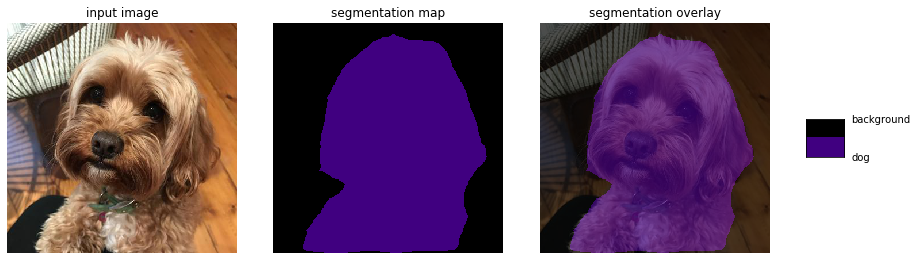

In [5]:
file_name = 'dog_pics/00000_cavapoo.jpg'
run_visualization(file_name)

running deeplab on image dog_pics/00092_cocker_spaniel.jpg...


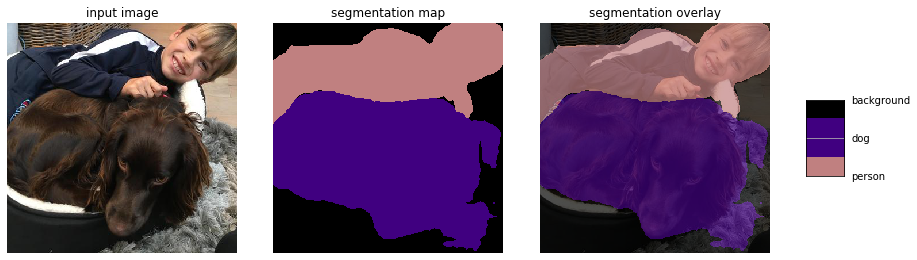

In [6]:
file_name = 'dog_pics/00092_cocker_spaniel.jpg'
run_visualization(file_name)

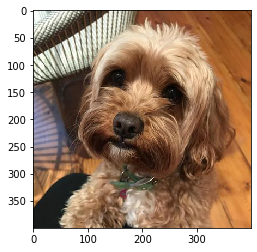

In [7]:
file_name = 'dog_pics/00000_cavapoo.jpg'
original_im = Image.open(file_name)
resized_im, seg_map = MODEL.run(original_im)
seg_image = label_to_color_image(seg_map).astype(np.uint8)
seg_image_400_400 = resize(seg_image, (400,400,3), anti_aliasing=True)
cleaned_image = np.asarray(original_im).copy()
plt.imshow(original_im)
plt.show()

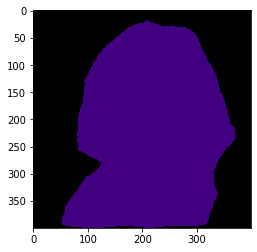

In [8]:
plt.imshow(seg_image_400_400)
plt.show()

0.44294319759297995


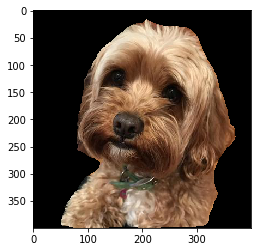

In [9]:
cleaned_image = np.asarray(original_im).copy()
black = 0
for i in range(0,400):
    for j in range(0,400):
        if max(seg_image_400_400[i][j])==0.:
            cleaned_image[i][j]=[0,0,0]  
            black+=1
print(black / (i*j))
plt.imshow(cleaned_image)
plt.show()

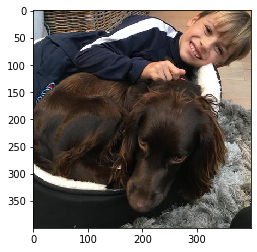

In [10]:
file_name = 'dog_pics/00092_cocker_spaniel.jpg'
original_im = Image.open(file_name)
resized_im, seg_map = MODEL.run(original_im)
seg_image = label_to_color_image(seg_map).astype(np.uint8)
seg_image_400_400 = resize(seg_image, (400,400,3), anti_aliasing=True)
cleaned_image = np.asarray(original_im).copy()
plt.imshow(original_im)
plt.show()

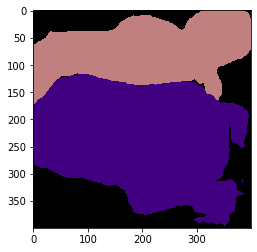

In [11]:
plt.imshow(seg_image_400_400)
plt.show()

In [12]:
seg_image_400_400[200][200]

array([0.25098039, 0.        , 0.50196078])

In [13]:
dog_colour = [0.24313725, 0.        , 0.49411765]

In [14]:
seg_image_400_400.shape

(400, 400, 3)

In [15]:
mask = np.isclose(seg_image_400_400, dog_colour)*1

In [16]:
sum(mask)

array([[  0, 289,   0],
       [  0, 290,   0],
       [  0, 290,   0],
       ...,
       [  0, 333,   0],
       [  0, 336,   0],
       [  0, 341,   0]])

In [17]:
new_mask = np.all(mask, axis = 2)*1

In [18]:
new_mask.shape

(400, 400)

In [19]:
np.sum(new_mask)

0

In [20]:
resized_new_mask = np.reshape(new_mask, (400, 400, 1))

In [21]:
400*400

160000

In [22]:
np.sum(new_mask)/(400*400)

0.0

In [23]:
np.sum(resized_new_mask)/(400*400)

0.0

In [24]:
resized_new_mask.shape

(400, 400, 1)

In [25]:
new_mask[200][200]

0

In [26]:
new_mask[100][50]

0

In [27]:
cleaned_image = resized_new_mask * cleaned_image

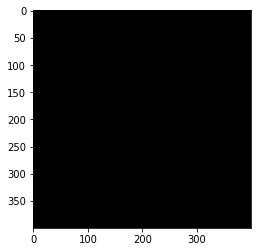

In [28]:
plt.imshow(cleaned_image);

In [41]:
#Write function which takes an image and returns a cleaned image:
def clean_image(file_name, show_pics = 'n'):
    original_im = Image.open(file_name)
    if show_pics == 'y':
        plt.imshow(original_im)
        plt.show()
    resized_im, seg_map = MODEL.run(original_im)
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    seg_image_400_400 = resize(seg_image, (400,400,3), anti_aliasing=True)
    if show_pics == 'y':
        plt.imshow(seg_image_400_400)
        plt.show()
    cleaned_image = np.asarray(original_im).copy()
    dog_pixel = 0
    dog_colour = [0.25098039, 0.        , 0.50196078]
    mask = np.isclose(seg_image_400_400, dog_colour)*1
    new_mask = np.all(mask, axis = 2)*1
    resized_new_mask = np.reshape(new_mask, (400, 400, 1))
    cleaned_image = resized_new_mask * cleaned_image
    per_cent_dog = np.sum(new_mask) / (400*400)
    if show_pics == 'y':
        plt.imshow(cleaned_image)
        plt.show()

    if show_pics == 'y':
        print('% dog pixels: ', per_cent_dog)
    return cleaned_image, per_cent_dog

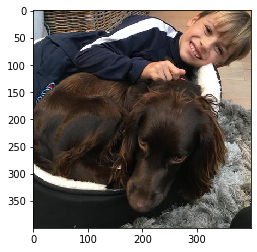

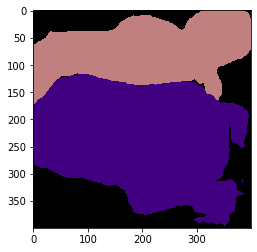

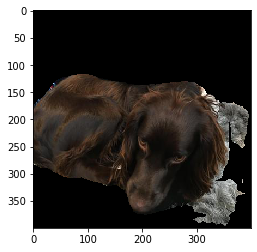

% dog pixels:  0.47988125


(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]]), 0.47988125)

In [42]:
clean_image('dog_pics/00092_cocker_spaniel.jpg', show_pics = 'y')

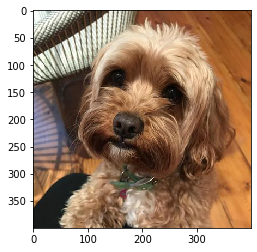

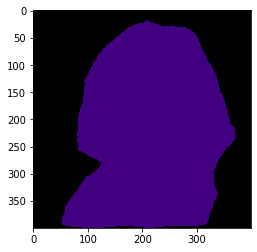

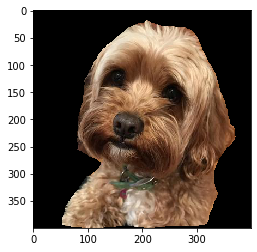

new % dog pixels:  0.55384375


In [34]:
clean_image('dog_pics/00000_cavapoo.jpg', show_pics='y')

In [43]:
temp_img, temp_pc = clean_image('dog_pics/00000_cavapoo.jpg');

In [47]:
int(temp_pc*100)

55

In [83]:
dog_pic_data = np.asarray(image.imread('dog_pics/00000_cavapoo.jpg'))

In [85]:
dog_pic_data.shape==(400,400,3)

True

In [93]:
pic_load_path = 'dog_pics/'
pic_list = sorted(os.listdir(pic_load_path))[1:]
pic_save_path = 'clean_dog_pics/'
i=0
for dog_pic in tqdm_notebook(pic_list):
    print(dog_pic)
    dog_pic_data = np.asarray(image.imread(pic_load_path+dog_pic))
    if dog_pic_data.shape!=(400,400,3):
        dog_pic_data = resize(dog_pic_data,(400,400,3), anti_aliasing=True)
    image.imsave('temp_img.jpg', dog_pic_data)
    clean_dog_pic, p_c_dog = clean_image('temp_img.jpg')
    file_name = dog_pic[:-4]+'_'+str(int(p_c_dog*100))+'.jpg'
    clean_dog_pic = clean_dog_pic/255
    image.imsave(pic_save_path+file_name, clean_dog_pic)
    print(file_name)
    i+=1

00000_bulldog.jpg
00000_bulldog_39.jpg
00001_cross_breed_-_large.jpg
00001_cross_breed_-_large_42.jpg
00002_maltipoo.jpg
00002_maltipoo_57.jpg
00003_pomchi.jpg
00003_pomchi_34.jpg
00004_chihuahua.jpg
00004_chihuahua_27.jpg
00005_cavapoo.jpg
00005_cavapoo_51.jpg
00006_japanese_shiba_inu.jpg
00006_japanese_shiba_inu_17.jpg
00007_pug.jpg
00007_pug_28.jpg
00008_miniature_poodle.jpg
00008_miniature_poodle_44.jpg
00009_cross_breed_-_medium.jpg
00009_cross_breed_-_medium_26.jpg
00010_pug.jpg
00010_pug_47.jpg
00011_jack_russell_terrier.jpg
00011_jack_russell_terrier_34.jpg
00012_cockapoo.jpg
00012_cockapoo_32.jpg
00013_cavapoo.jpg
00013_cavapoo_45.jpg
00014_german_shepherd_dog.jpg
00014_german_shepherd_dog_42.jpg
00015_german_pointer.jpg
00015_german_pointer_30.jpg
00016_jug.jpg
00016_jug_23.jpg
00017_cross_breed_-_large.jpg
00017_cross_breed_-_large_38.jpg
00018_cross_breed_-_medium.jpg
00018_cross_breed_-_medium_74.jpg
00019_cockapoo.jpg
00019_cockapoo_53.jpg
00020_french_bulldog.jpg
00020_f

00151_lurcher_27.jpg
00152_hungarian_wire_haired_vizsla.jpg
00152_hungarian_wire_haired_vizsla_49.jpg
00153_cross_breed_-_medium.jpg
00153_cross_breed_-_medium_18.jpg
00154_staffordshire_bull_terrier.jpg
00154_staffordshire_bull_terrier_8.jpg
00155_cross_breed_-_medium.jpg
00155_cross_breed_-_medium_14.jpg
00156_cross_breed_-_medium.jpg
00156_cross_breed_-_medium_38.jpg
00157_dachshund_(miniature).jpg
00157_dachshund_(miniature)_13.jpg
00158_miniature_goldendoodle.jpg
00158_miniature_goldendoodle_35.jpg
00159_cross_breed_-_medium.jpg
00159_cross_breed_-_medium_63.jpg
00160_dachshund.jpg
00160_dachshund_15.jpg
00161_cross_breed_-_small.jpg
00161_cross_breed_-_small_18.jpg
00162_golden_retriever.jpg
00162_golden_retriever_31.jpg
00163_siberian_husky.jpg
00163_siberian_husky_44.jpg
00164_greyhound.jpg
00164_greyhound_34.jpg
00165_jack_russell_terrier.jpg
00165_jack_russell_terrier_33.jpg
00166_cross_breed_-_large.jpg
00166_cross_breed_-_large_66.jpg
00167_german_shepherd_dog.jpg
00167_ger

00300_miniature_labradoodle_57.jpg
00301_greyhound.jpg
00301_greyhound_33.jpg
00302_great_dane.jpg
00302_great_dane_65.jpg
00303_jack_russell_terrier.jpg
00303_jack_russell_terrier_67.jpg
00304_cross_breed_-_small.jpg
00304_cross_breed_-_small_13.jpg
00305_cockapoo.jpg
00305_cockapoo_35.jpg
00306_border_collie.jpg
00306_border_collie_27.jpg
00307_cross_breed_-_large.jpg
00307_cross_breed_-_large_64.jpg
00308_beagle.jpg
00308_beagle_38.jpg
00309_miniature_schnoodle.jpg
00309_miniature_schnoodle_47.jpg
00310_golden_retriever.jpg
00310_golden_retriever_24.jpg
00311_cavapoo.jpg
00311_cavapoo_7.jpg
00312_french_bulldog.jpg
00312_french_bulldog_24.jpg
00313_cross_breed_-_medium.jpg
00313_cross_breed_-_medium_23.jpg
00314_cavalier_king_charles_spaniel.jpg
00314_cavalier_king_charles_spaniel_30.jpg
00315_french_bulldog.jpg
00315_french_bulldog_23.jpg
00316_cocker_spaniel.jpg
00316_cocker_spaniel_66.jpg
00317_cross_breed_-_large.jpg
00317_cross_breed_-_large_38.jpg
00318_labrador.jpg
00318_labr

00455_cockapoo_40.jpg
00456_cross_breed_-_small.jpg
00456_cross_breed_-_small_32.jpg
00457_beagle.jpg
00457_beagle_52.jpg
00458_lurcher.jpg
00458_lurcher_54.jpg
00459_cross_breed_-_medium.jpg
00459_cross_breed_-_medium_36.jpg
00460_hungarian_vizsla.jpg
00460_hungarian_vizsla_11.jpg
00461_goldendoodle.jpg
00461_goldendoodle_42.jpg
00462_cocker_spaniel.jpg
00462_cocker_spaniel_35.jpg
00463_siberian_husky.jpg
00463_siberian_husky_27.jpg
00464_bichon_frise.jpg
00464_bichon_frise_61.jpg
00465_cockapoo.jpg
00465_cockapoo_13.jpg
00466_jackapoo.jpg
00466_jackapoo_20.jpg
00467_chorkie.jpg
00467_chorkie_62.jpg
00468_cross_breed_-_small.jpg
00468_cross_breed_-_small_53.jpg
00469_shih_tzu.jpg
00469_shih_tzu_38.jpg
00470_beagle.jpg
00470_beagle_10.jpg
00471_cross_breed_-_large.jpg
00471_cross_breed_-_large_49.jpg
00472_cockapoo.jpg
00472_cockapoo_40.jpg
00473_basset_hound.jpg
00473_basset_hound_26.jpg
00474_jack_russell_terrier.jpg
00474_jack_russell_terrier_37.jpg
00475_yorkshire_terrier.jpg
00475

00614_pug_20.jpg
00615_pug.jpg
00615_pug_41.jpg
00616_border_terrier.jpg
00616_border_terrier_48.jpg
00617_cockapoo.jpg
00617_cockapoo_47.jpg
00618_cavapoo.jpg
00618_cavapoo_43.jpg
00619_cross_breed_-_small.jpg
00619_cross_breed_-_small_30.jpg
00620_miniature_schnauzer.jpg
00620_miniature_schnauzer_0.jpg
00621_yorkshire_terrier.jpg
00621_yorkshire_terrier_29.jpg
00622_lurcher.jpg
00622_lurcher_23.jpg
00623_german_shepherd_dog.jpg
00623_german_shepherd_dog_32.jpg
00624_shar_pei.jpg
00624_shar_pei_68.jpg
00625_cross_breed_-_medium.jpg
00625_cross_breed_-_medium_41.jpg
00626_cross_breed_-_medium.jpg
00626_cross_breed_-_medium_40.jpg
00627_labrador.jpg
00627_labrador_60.jpg
00628_french_bulldog.jpg
00628_french_bulldog_59.jpg
00629_chihuahua.jpg
00629_chihuahua_43.jpg
00630_german_shepherd_dog.jpg
00630_german_shepherd_dog_48.jpg
00631_saluki.jpg
00631_saluki_55.jpg
00632_cross_breed_-_small.jpg
00632_cross_breed_-_small_19.jpg
00633_cavalier_king_charles_spaniel.jpg
00633_cavalier_king_ch

00770_labrador_36.jpg
00771_cockapoo.jpg
00771_cockapoo_51.jpg
00772_jack_russell_terrier.jpg
00772_jack_russell_terrier_30.jpg
00773_german_shepherd_dog.jpg
00773_german_shepherd_dog_21.jpg
00774_springador.jpg
00774_springador_45.jpg
00775_cocker_spaniel.jpg
00775_cocker_spaniel_35.jpg
00776_weimaraner.jpg
00776_weimaraner_35.jpg
00777_shih_tzu.jpg
00777_shih_tzu_28.jpg
00778_cross_breed_-_small.jpg
00778_cross_breed_-_small_30.jpg
00779_cavalier_king_charles_spaniel.jpg
00779_cavalier_king_charles_spaniel_30.jpg
00780_cockapoo.jpg
00780_cockapoo_69.jpg
00781_staffordshire_bull_terrier.jpg
00781_staffordshire_bull_terrier_10.jpg
00782_cockapoo.jpg
00782_cockapoo_22.jpg
00783_siberian_husky.jpg
00783_siberian_husky_54.jpg
00784_staffordshire_bull_terrier.jpg
00784_staffordshire_bull_terrier_27.jpg
00785_cockapoo.jpg
00785_cockapoo_47.jpg
00786_cavachon.jpg
00786_cavachon_26.jpg
00787_cross_breed_-_medium.jpg
00787_cross_breed_-_medium_5.jpg
00788_labrador.jpg
00788_labrador_3.jpg
0078

00927_cross_breed_-_medium_27.jpg
00928_cross_breed_-_medium.jpg
00928_cross_breed_-_medium_4.jpg
00929_cross_breed_-_medium.jpg
00929_cross_breed_-_medium_14.jpg
00930_boxer.jpg
00930_boxer_30.jpg
00931_cockapoo.jpg
00931_cockapoo_51.jpg
00932_yorkshire_terrier.jpg
00932_yorkshire_terrier_32.jpg
00933_welsh_collie.jpg
00933_welsh_collie_49.jpg
00934_english_springer_spaniel.jpg
00934_english_springer_spaniel_87.jpg
00935_cockapoo.jpg
00935_cockapoo_79.jpg
00936_beagle.jpg
00936_beagle_8.jpg
00937_staffordshire_bull_terrier.jpg
00937_staffordshire_bull_terrier_22.jpg
00938_whippet.jpg
00938_whippet_33.jpg
00939_dobermann.jpg
00939_dobermann_30.jpg
00940_standard_poodle.jpg
00940_standard_poodle_48.jpg
00941_bichon_frise.jpg
00941_bichon_frise_30.jpg
00942_lhasa_apso.jpg
00942_lhasa_apso_65.jpg
00943_cavapoo.jpg
00943_cavapoo_46.jpg
00944_bearded_collie.jpg
00944_bearded_collie_56.jpg
00945_golden_retriever.jpg
00945_golden_retriever_40.jpg
00946_bulldog.jpg
00946_bulldog_44.jpg
00947_c

01074_dogue_de_bordeaux_33.jpg
01075_staffordshire_bull_terrier.jpg
01075_staffordshire_bull_terrier_57.jpg
01076_cavachon.jpg
01076_cavachon_34.jpg
01077_staffordshire_bull_terrier.jpg
01077_staffordshire_bull_terrier_42.jpg
01078_dogue_de_bordeaux.jpg
01078_dogue_de_bordeaux_36.jpg
01079_cross_breed_-_small.jpg
01079_cross_breed_-_small_55.jpg
01080_cocker_spaniel.jpg
01080_cocker_spaniel_8.jpg
01081_cross_breed_-_small.jpg
01081_cross_breed_-_small_43.jpg
01082_cairn_terrier.jpg
01082_cairn_terrier_20.jpg
01083_great_dane.jpg
01083_great_dane_48.jpg
01084_cairn_terrier.jpg
01084_cairn_terrier_76.jpg
01085_staffordshire_bull_terrier.jpg
01085_staffordshire_bull_terrier_31.jpg
01086_cockapoo.jpg
01086_cockapoo_36.jpg
01087_chihuahua.jpg
01087_chihuahua_37.jpg
01088_cross_breed_-_large.jpg
01088_cross_breed_-_large_53.jpg
01089_cockapoo.jpg
01089_cockapoo_65.jpg
01090_jack_russell_terrier.jpg
01090_jack_russell_terrier_58.jpg
01091_dalmatian.jpg
01091_dalmatian_19.jpg
01092_labrador.jp

01229_cross_breed_-_small_30.jpg
01230_siberian_husky.jpg
01230_siberian_husky_36.jpg
01231_cavalier_king_charles_spaniel.jpg
01231_cavalier_king_charles_spaniel_29.jpg
01232_labrador_retriever.jpg
01232_labrador_retriever_20.jpg
01233_shih-poo.jpg
01233_shih-poo_26.jpg
01234_cross_breed_-_medium.jpg
01234_cross_breed_-_medium_44.jpg
01235_staffordshire_bull_terrier.jpg
01235_staffordshire_bull_terrier_17.jpg
01236_greyhound.jpg
01236_greyhound_14.jpg
01237_labradoodle.jpg
01237_labradoodle_51.jpg
01238_staffordshire_bull_terrier.jpg
01238_staffordshire_bull_terrier_43.jpg
01239_english_springer_spaniel.jpg
01239_english_springer_spaniel_35.jpg
01240_cockapoo.jpg
01240_cockapoo_72.jpg
01241_cross_breed_-_medium.jpg
01241_cross_breed_-_medium_41.jpg
01242_cross_breed_-_medium.jpg
01242_cross_breed_-_medium_38.jpg
01243_jack_russell_terrier.jpg
01243_jack_russell_terrier_39.jpg
01244_cross_breed_-_small.jpg
01244_cross_breed_-_small_27.jpg
01245_german_shepherd_dog.jpg
01245_german_sheph

01383_cross_breed_-_large_70.jpg
01384_rottweiler.jpg
01384_rottweiler_54.jpg
01385_french_bulldog.jpg
01385_french_bulldog_0.jpg
01386_maltese.jpg
01386_maltese_20.jpg
01387_bichon_frise.jpg
01387_bichon_frise_5.jpg
01388_staffordshire_bull_terrier.jpg
01388_staffordshire_bull_terrier_11.jpg
01389_cocker_spaniel.jpg
01389_cocker_spaniel_48.jpg
01390_cross_breed_-_medium.jpg
01390_cross_breed_-_medium_51.jpg
01391_french_bulldog.jpg
01391_french_bulldog_3.jpg
01392_golden_retriever.jpg
01392_golden_retriever_35.jpg
01393_english_springer_spaniel.jpg
01393_english_springer_spaniel_7.jpg
01394_staffordshire_bull_terrier.jpg
01394_staffordshire_bull_terrier_23.jpg
01395_labrador.jpg
01395_labrador_11.jpg
01396_staffordshire_bull_terrier.jpg
01396_staffordshire_bull_terrier_44.jpg
01397_west_highland_white_terrier.jpg
01397_west_highland_white_terrier_14.jpg
01398_west_highland_white_terrier.jpg
01398_west_highland_white_terrier_28.jpg
01399_scottish_terrier.jpg
01399_scottish_terrier_63.j

01535_english_springer_spaniel_45.jpg
01536_cross_breed_-_small.jpg
01536_cross_breed_-_small_42.jpg
01537_labrador.jpg
01537_labrador_9.jpg
01538_maltipoo.jpg
01538_maltipoo_19.jpg
01539_cavachon.jpg
01539_cavachon_8.jpg
01540_cavachon.jpg
01540_cavachon_19.jpg
01541_cockapoo.jpg
01541_cockapoo_26.jpg
01542_cavapoo.jpg
01542_cavapoo_27.jpg
01543_cross_breed_-_medium.jpg
01543_cross_breed_-_medium_13.jpg
01544_sprocker.jpg
01544_sprocker_47.jpg
01545_cross_breed_-_medium.jpg
01545_cross_breed_-_medium_21.jpg
01546_labrador.jpg
01546_labrador_30.jpg
01547_old_tyme_bulldog.jpg
01547_old_tyme_bulldog_71.jpg
01548_cross_breed_-_medium.jpg
01548_cross_breed_-_medium_64.jpg
01549_cocker_spaniel.jpg
01549_cocker_spaniel_4.jpg
01550_goldendoodle.jpg
01550_goldendoodle_45.jpg
01551_border_collie.jpg
01551_border_collie_40.jpg
01552_labrador.jpg
01552_labrador_2.jpg
01553_cocker_spaniel.jpg
01553_cocker_spaniel_30.jpg
01554_cockapoo.jpg
01554_cockapoo_45.jpg
01555_chihuahua.jpg
01555_chihuahua_8

01691_chihuahua_60.jpg
01692_jug.jpg
01692_jug_30.jpg
01693_cocker_spaniel.jpg
01693_cocker_spaniel_61.jpg
01694_pug.jpg
01694_pug_17.jpg
01695_german_shepherd_dog.jpg
01695_german_shepherd_dog_7.jpg
01696_cockapoo.jpg
01696_cockapoo_17.jpg
01697_labrador.jpg
01697_labrador_9.jpg
01698_cocker_spaniel.jpg
01698_cocker_spaniel_39.jpg
01699_labradoodle.jpg
01699_labradoodle_17.jpg
01700_cavapoo.jpg
01700_cavapoo_18.jpg
01701_dobermann.jpg
01701_dobermann_81.jpg
01702_lurcher.jpg
01702_lurcher_12.jpg
01703_labrador.jpg
01703_labrador_23.jpg
01704_cockapoo.jpg
01704_cockapoo_16.jpg
01705_french_bulldog.jpg
01705_french_bulldog_42.jpg
01706_cockapoo.jpg
01706_cockapoo_51.jpg
01707_cross_breed_-_medium.jpg
01707_cross_breed_-_medium_67.jpg
01708_miniature_goldendoodle.jpg
01708_miniature_goldendoodle_59.jpg
01709_cocker_spaniel.jpg
01709_cocker_spaniel_40.jpg
01710_labrador.jpg
01710_labrador_51.jpg
01711_cross_breed_-_medium.jpg
01711_cross_breed_-_medium_20.jpg
01712_greyhound.jpg
01712_gre

01847_pomeranian_72.jpg
01848_border_terrier.jpg
01848_border_terrier_31.jpg
01849_staffordshire_bull_terrier.jpg
01849_staffordshire_bull_terrier_53.jpg
01850_labrador.jpg
01850_labrador_28.jpg
01851_cross_breed_-_medium.jpg
01851_cross_breed_-_medium_56.jpg
01852_smooth_haired_dachshund.jpg
01852_smooth_haired_dachshund_45.jpg
01853_greyhound.jpg
01853_greyhound_38.jpg
01854_sprocker.jpg
01854_sprocker_74.jpg
01855_border_collie.jpg
01855_border_collie_0.jpg
01856_cross_breed_-_small.jpg
01856_cross_breed_-_small_46.jpg
01857_labrador.jpg
01857_labrador_10.jpg
01858_cockapoo.jpg
01858_cockapoo_61.jpg
01859_cocker_spaniel.jpg
01859_cocker_spaniel_49.jpg
01860_cross_breed_-_small.jpg
01860_cross_breed_-_small_36.jpg
01861_american_bulldog.jpg
01861_american_bulldog_7.jpg
01862_cross_breed_-_medium.jpg
01862_cross_breed_-_medium_31.jpg
01863_shar_pei.jpg
01863_shar_pei_34.jpg
01864_schnauzer.jpg
01864_schnauzer_73.jpg
01865_cross_breed_-_small.jpg
01865_cross_breed_-_small_35.jpg
01866_

01997_cross_breed_-_medium_15.jpg
01998_cocker_spaniel.jpg
01998_cocker_spaniel_43.jpg
01999_cross_breed_-_small.jpg
01999_cross_breed_-_small_16.jpg
02000_cross_breed_-_medium.jpg
02000_cross_breed_-_medium_26.jpg
02001_cross_breed_-_medium.jpg
02001_cross_breed_-_medium_39.jpg
02002_cross_breed_-_medium.jpg
02002_cross_breed_-_medium_16.jpg
02003_cross_breed_-_large.jpg
02003_cross_breed_-_large_54.jpg
02004_cavalier_king_charles_spaniel.jpg
02004_cavalier_king_charles_spaniel_48.jpg
02005_cavachon.jpg
02005_cavachon_40.jpg
02006_alaskan_malamute.jpg
02006_alaskan_malamute_57.jpg
02007_old_tyme_bulldog.jpg
02007_old_tyme_bulldog_35.jpg
02008_cross_breed_-_large.jpg
02008_cross_breed_-_large_35.jpg
02009_smooth-coated_chihuahua.jpg
02009_smooth-coated_chihuahua_37.jpg
02010_greyhound.jpg
02010_greyhound_44.jpg
02011_cross_breed_-_small.jpg
02011_cross_breed_-_small_11.jpg
02012_cross_breed_-_medium.jpg
02012_cross_breed_-_medium_45.jpg
02013_jackapoo.jpg
02013_jackapoo_24.jpg
02014_lu

02153_border_terrier_23.jpg
02154_cross_breed_-_large.jpg
02154_cross_breed_-_large_47.jpg
02155_tibetan_terrier.jpg
02155_tibetan_terrier_8.jpg
02156_beagle.jpg
02156_beagle_32.jpg
02157_cross_breed_-_medium.jpg
02157_cross_breed_-_medium_7.jpg
02158_english_springer_spaniel.jpg
02158_english_springer_spaniel_27.jpg
02159_cross_breed_-_large.jpg
02159_cross_breed_-_large_35.jpg
02160_border_collie.jpg
02160_border_collie_36.jpg
02161_golden_retriever.jpg
02161_golden_retriever_36.jpg
02162_akita.jpg
02162_akita_20.jpg
02163_cross_breed_-_small.jpg
02163_cross_breed_-_small_23.jpg
02164_golden_retriever.jpg
02164_golden_retriever_46.jpg
02165_labrador.jpg
02165_labrador_68.jpg
02166_labradoodle.jpg
02166_labradoodle_73.jpg
02167_siberian_husky.jpg
02167_siberian_husky_24.jpg
02168_jackhuahua.jpg
02168_jackhuahua_14.jpg
02169_golden_retriever.jpg
02169_golden_retriever_48.jpg
02170_cavapoo.jpg
02170_cavapoo_37.jpg
02171_german_shepherd_dog.jpg
02171_german_shepherd_dog_6.jpg
02172_cross

02303_siberian_husky_24.jpg
02304_cavachon.jpg
02304_cavachon_25.jpg
02305_cockapoo.jpg
02305_cockapoo_42.jpg
02306_greyhound.jpg
02306_greyhound_10.jpg
02307_cross_breed_-_small.jpg
02307_cross_breed_-_small_28.jpg
02308_cross_breed_-_medium.jpg
02308_cross_breed_-_medium_52.jpg
02309_jack_russell_terrier.jpg
02309_jack_russell_terrier_19.jpg
02310_siberian_husky.jpg
02310_siberian_husky_0.jpg
02311_border_terrier.jpg
02311_border_terrier_30.jpg
02312_border_collie.jpg
02312_border_collie_13.jpg
02313_labrador.jpg
02313_labrador_17.jpg
02314_lhasa_apso.jpg
02314_lhasa_apso_59.jpg
02315_german_pointer.jpg
02315_german_pointer_21.jpg
02316_beagle.jpg
02316_beagle_71.jpg
02317_cross_breed_-_medium.jpg
02317_cross_breed_-_medium_62.jpg
02318_cross_breed_-_large.jpg
02318_cross_breed_-_large_8.jpg
02319_jack_russell_terrier.jpg
02319_jack_russell_terrier_44.jpg
02320_sprocker.jpg
02320_sprocker_20.jpg
02321_cocker_spaniel.jpg
02321_cocker_spaniel_62.jpg
02322_puggle.jpg
02322_puggle_39.jpg

02459_yorkiepoo_59.jpg
02460_staffordshire_bull_terrier.jpg
02460_staffordshire_bull_terrier_40.jpg
02461_staffordshire_bull_terrier.jpg
02461_staffordshire_bull_terrier_30.jpg
02462_chihuahua.jpg
02462_chihuahua_53.jpg
02463_dachshund_(miniature).jpg
02463_dachshund_(miniature)_26.jpg
02464_jack_russell_terrier.jpg
02464_jack_russell_terrier_13.jpg
02465_cross_breed_-_small.jpg
02465_cross_breed_-_small_52.jpg
02466_jack_russell_terrier.jpg
02466_jack_russell_terrier_30.jpg
02467_beagle.jpg
02467_beagle_8.jpg
02468_golden_retriever.jpg
02468_golden_retriever_34.jpg
02469_shar_pei.jpg
02469_shar_pei_33.jpg
02470_basset_hound.jpg
02470_basset_hound_47.jpg
02471_italian_greyhound.jpg
02471_italian_greyhound_33.jpg
02472_yorkshire_terrier.jpg
02472_yorkshire_terrier_14.jpg
02473_hungarian_vizsla.jpg
02473_hungarian_vizsla_40.jpg
02474_cocker_spaniel.jpg
02474_cocker_spaniel_69.jpg
02475_japanese_shiba_inu.jpg
02475_japanese_shiba_inu_45.jpg
02476_german_shepherd_dog.jpg
02476_german_sheph

02611_cross_breed_-_medium_21.jpg
02612_jack_russell_terrier.jpg
02612_jack_russell_terrier_42.jpg
02613_cross_breed_-_small.jpg
02613_cross_breed_-_small_43.jpg
02614_italian_greyhound.jpg
02614_italian_greyhound_25.jpg
02615_jack_russell_terrier.jpg
02615_jack_russell_terrier_28.jpg
02616_cross_breed_-_small.jpg
02616_cross_breed_-_small_38.jpg
02617_parson_russell_terrier.jpg
02617_parson_russell_terrier_12.jpg
02618_parson_russell_terrier.jpg
02618_parson_russell_terrier_29.jpg
02619_english_springer_spaniel.jpg
02619_english_springer_spaniel_36.jpg
02620_sproodle.jpg
02620_sproodle_48.jpg
02621_pomeranian.jpg
02621_pomeranian_50.jpg
02622_english_springer_spaniel.jpg
02622_english_springer_spaniel_37.jpg
02623_border_terrier.jpg
02623_border_terrier_13.jpg
02624_cross_breed_-_medium.jpg
02624_cross_breed_-_medium_11.jpg
02625_miniature_schnauzer.jpg
02625_miniature_schnauzer_53.jpg
02626_miniature_labradoodle.jpg
02626_miniature_labradoodle_22.jpg
02627_cross_breed_-_large.jpg
026

02757_miniature_labradoodle_13.jpg
02758_cross_breed_-_medium.jpg
02758_cross_breed_-_medium_51.jpg
02759_lurcher.jpg
02759_lurcher_41.jpg
02760_toy_poodle.jpg
02760_toy_poodle_3.jpg
02761_french_bulldog.jpg
02761_french_bulldog_31.jpg
02762_cross_breed_-_medium.jpg
02762_cross_breed_-_medium_32.jpg
02763_miniature_pinscher.jpg
02763_miniature_pinscher_25.jpg
02764_miniature_labradoodle.jpg
02764_miniature_labradoodle_35.jpg
02765_french_bulldog.jpg
02765_french_bulldog_19.jpg
02766_cockapoo.jpg
02766_cockapoo_53.jpg
02767_italian_greyhound.jpg
02767_italian_greyhound_0.jpg
02768_pointer.jpg
02768_pointer_31.jpg
02769_leonberger.jpg
02769_leonberger_33.jpg
02770_pug.jpg
02770_pug_29.jpg
02771_cross_breed_-_medium.jpg
02771_cross_breed_-_medium_57.jpg
02772_alaskan_malamute.jpg
02772_alaskan_malamute_32.jpg
02773_cross_breed_-_medium.jpg
02773_cross_breed_-_medium_9.jpg
02774_cockapoo.jpg
02774_cockapoo_47.jpg
02775_miniature_smooth-haired_dachshund.jpg
02775_miniature_smooth-haired_dac

02905_lurcher_24.jpg
02906_cross_breed_-_medium.jpg
02906_cross_breed_-_medium_45.jpg
02907_labrador.jpg
02907_labrador_36.jpg
02908_labradoodle.jpg
02908_labradoodle_45.jpg
02909_cockapoo.jpg
02909_cockapoo_27.jpg
02910_cocker_spaniel.jpg
02910_cocker_spaniel_33.jpg
02911_hungarian_vizsla.jpg
02911_hungarian_vizsla_24.jpg
02912_cross_breed_-_medium.jpg
02912_cross_breed_-_medium_61.jpg
02913_cross_breed_-_medium.jpg
02913_cross_breed_-_medium_53.jpg
02914_french_bulldog.jpg
02914_french_bulldog_44.jpg
02915_french_bulldog.jpg
02915_french_bulldog_19.jpg
02916_cross_breed_-_small.jpg
02916_cross_breed_-_small_40.jpg
02917_jackhuahua.jpg
02917_jackhuahua_37.jpg
02918_border_collie.jpg
02918_border_collie_30.jpg
02919_goldendoodle.jpg
02919_goldendoodle_39.jpg
02920_golden_retriever.jpg
02920_golden_retriever_14.jpg
02921_cross_breed_-_small.jpg
02921_cross_breed_-_small_36.jpg
02922_labradoodle.jpg
02922_labradoodle_43.jpg
02923_border_collie.jpg
02923_border_collie_21.jpg
02924_cross_b

03063_cross_breed_-_large_69.jpg
03064_springador.jpg
03064_springador_39.jpg
03065_chihuahua.jpg
03065_chihuahua_39.jpg
03066_labrador.jpg
03066_labrador_39.jpg
03067_cockapoo.jpg
03067_cockapoo_40.jpg
03068_shih_tzu.jpg
03068_shih_tzu_20.jpg
03069_parson_russell_terrier.jpg
03069_parson_russell_terrier_37.jpg
03070_cross_breed_-_medium.jpg
03070_cross_breed_-_medium_38.jpg
03071_pug.jpg
03071_pug_53.jpg
03072_cross_breed_-_medium.jpg
03072_cross_breed_-_medium_60.jpg
03073_greyhound.jpg
03073_greyhound_39.jpg
03074_cross_breed_-_small.jpg
03074_cross_breed_-_small_79.jpg
03075_golden_retriever.jpg
03075_golden_retriever_20.jpg
03076_cross_breed_-_large.jpg
03076_cross_breed_-_large_14.jpg
03077_cross_breed_-_large.jpg
03077_cross_breed_-_large_24.jpg
03078_cavapoo.jpg
03078_cavapoo_14.jpg
03079_dachshund_(miniature).jpg
03079_dachshund_(miniature)_18.jpg
03080_cross_breed_-_small.jpg
03080_cross_breed_-_small_63.jpg
03081_saluki.jpg
03081_saluki_35.jpg
03082_jackapoo.jpg
03082_jackap

03215_cross_breed_-_medium_58.jpg
03216_sproodle.jpg
03216_sproodle_18.jpg
03217_miniature_labradoodle.jpg
03217_miniature_labradoodle_9.jpg
03218_labrador.jpg
03218_labrador_23.jpg
03219_cavachon.jpg
03219_cavachon_48.jpg
03220_hungarian_vizsla.jpg
03220_hungarian_vizsla_46.jpg
03221_cockapoo.jpg
03221_cockapoo_54.jpg
03222_cross_breed_-_medium.jpg
03222_cross_breed_-_medium_76.jpg
03223_greyhound.jpg
03223_greyhound_73.jpg
03224_cross_breed_-_medium.jpg
03224_cross_breed_-_medium_34.jpg
03225_bull_terrier.jpg
03225_bull_terrier_49.jpg
03226_chihuahua.jpg
03226_chihuahua_19.jpg
03227_dalmatian.jpg
03227_dalmatian_36.jpg
03228_cockapoo.jpg
03228_cockapoo_1.jpg
03229_labradoodle.jpg
03229_labradoodle_45.jpg
03230_cavapoo.jpg
03230_cavapoo_74.jpg
03231_cross_breed_-_medium.jpg
03231_cross_breed_-_medium_24.jpg
03232_staffordshire_bull_terrier.jpg
03232_staffordshire_bull_terrier_23.jpg
03233_french_bulldog.jpg
03233_french_bulldog_35.jpg
03234_staffordshire_bull_terrier.jpg
03234_staffor

03368_sprocker_18.jpg
03369_labradoodle.jpg
03369_labradoodle_28.jpg
03370_labradoodle.jpg
03370_labradoodle_28.jpg
03371_portuguese_podengo.jpg
03371_portuguese_podengo_49.jpg
03372_labradoodle.jpg
03372_labradoodle_12.jpg
03373_norfolk_terrier.jpg
03373_norfolk_terrier_56.jpg
03374_french_bulldog.jpg
03374_french_bulldog_27.jpg
03375_chihuahua.jpg
03375_chihuahua_20.jpg
03376_labradoodle.jpg
03376_labradoodle_64.jpg
03377_greyhound.jpg
03377_greyhound_51.jpg
03378_cockapoo.jpg
03378_cockapoo_23.jpg
03379_labrador_retriever.jpg
03379_labrador_retriever_38.jpg
03380_cavapoo.jpg
03380_cavapoo_21.jpg
03381_sproodle.jpg
03381_sproodle_41.jpg
03382_dachshund.jpg
03382_dachshund_35.jpg
03383_miniature_schnauzer.jpg
03383_miniature_schnauzer_5.jpg
03384_dachshund_(miniature).jpg
03384_dachshund_(miniature)_42.jpg
03385_staffordshire_bull_terrier.jpg
03385_staffordshire_bull_terrier_41.jpg
03386_labrador.jpg
03386_labrador_60.jpg
03387_sprocker.jpg
03387_sprocker_24.jpg
03388_belgian_shepherd

03526_border_terrier_18.jpg
03527_cross_breed_-_small.jpg
03527_cross_breed_-_small_46.jpg
03528_labrador.jpg
03528_labrador_58.jpg
03529_yorkshire_terrier.jpg
03529_yorkshire_terrier_29.jpg
03530_lakeland_terrier.jpg
03530_lakeland_terrier_40.jpg
03531_cockapoo.jpg
03531_cockapoo_61.jpg
03532_labrador.jpg
03532_labrador_5.jpg
03533_french_bulldog.jpg
03533_french_bulldog_39.jpg
03534_cross_breed_-_small.jpg
03534_cross_breed_-_small_50.jpg
03535_king_charles_spaniel.jpg
03535_king_charles_spaniel_40.jpg
03536_cockapoo.jpg
03536_cockapoo_39.jpg
03537_jackapoo.jpg
03537_jackapoo_16.jpg
03538_cavachon.jpg
03538_cavachon_71.jpg
03539_cross_breed_-_medium.jpg
03539_cross_breed_-_medium_39.jpg
03540_cross_breed_-_small.jpg
03540_cross_breed_-_small_91.jpg
03541_labrador.jpg
03541_labrador_43.jpg
03542_cocker_spaniel.jpg
03542_cocker_spaniel_47.jpg
03543_labrador.jpg
03543_labrador_42.jpg
03544_cross_breed_-_medium.jpg
03544_cross_breed_-_medium_52.jpg
03545_labrador.jpg
03545_labrador_58.jp

03679_irish_terrier_54.jpg
03680_cocker_spaniel.jpg
03680_cocker_spaniel_24.jpg
03681_miniature_poodle.jpg
03681_miniature_poodle_44.jpg
03682_cross_breed_-_small.jpg
03682_cross_breed_-_small_10.jpg
03683_cross_breed_-_medium.jpg
03683_cross_breed_-_medium_48.jpg
03684_whippet.jpg
03684_whippet_41.jpg
03685_border_terrier.jpg
03685_border_terrier_17.jpg
03686_bull_terrier.jpg
03686_bull_terrier_27.jpg
03687_staffordshire_bull_terrier.jpg
03687_staffordshire_bull_terrier_23.jpg
03688_cocker_spaniel.jpg
03688_cocker_spaniel_20.jpg
03689_pug.jpg
03689_pug_14.jpg
03690_cocker_spaniel.jpg
03690_cocker_spaniel_11.jpg
03691_labradoodle.jpg
03691_labradoodle_20.jpg
03692_field_spaniel.jpg
03692_field_spaniel_56.jpg
03693_west_highland_white_terrier.jpg
03693_west_highland_white_terrier_9.jpg
03694_labrador_retriever.jpg
03694_labrador_retriever_45.jpg
03695_japanese_akita_inu.jpg
03695_japanese_akita_inu_38.jpg
03696_labradoodle.jpg
03696_labradoodle_41.jpg
03697_labradoodle.jpg
03697_labrado

03831_border_terrier_50.jpg
03832_alaskan_malamute.jpg
03832_alaskan_malamute_29.jpg
03833_miniature_schnauzer.jpg
03833_miniature_schnauzer_29.jpg
03834_english_springer_spaniel.jpg
03834_english_springer_spaniel_42.jpg
03835_wire_fox_terrier.jpg
03835_wire_fox_terrier_37.jpg
03836_wire_fox_terrier.jpg
03836_wire_fox_terrier_61.jpg
03837_bichon_frise.jpg
03837_bichon_frise_64.jpg
03838_jack_russell_terrier.jpg
03838_jack_russell_terrier_38.jpg
03839_goldendoodle.jpg
03839_goldendoodle_60.jpg
03840_dalmatian.jpg
03840_dalmatian_38.jpg
03841_whippet.jpg
03841_whippet_24.jpg
03842_boxer.jpg
03842_boxer_32.jpg
03843_labrador.jpg
03843_labrador_16.jpg
03844_cavachon.jpg
03844_cavachon_7.jpg
03845_labrador.jpg
03845_labrador_24.jpg
03846_labrador.jpg
03846_labrador_21.jpg
03847_cross_breed_-_medium.jpg
03847_cross_breed_-_medium_28.jpg
03848_labrador.jpg
03848_labrador_52.jpg
03849_cockapoo.jpg
03849_cockapoo_24.jpg
03850_bulldog.jpg
03850_bulldog_42.jpg
03851_sprocker.jpg
03851_sprocker_47

03980_sprocker_33.jpg
03981_labrador.jpg
03981_labrador_36.jpg
03982_west_highland_white_terrier.jpg
03982_west_highland_white_terrier_21.jpg
03983_labrador.jpg
03983_labrador_36.jpg
03984_yorkshire_terrier.jpg
03984_yorkshire_terrier_6.jpg
03985_golden_retriever.jpg
03985_golden_retriever_28.jpg
03986_cocker_spaniel.jpg
03986_cocker_spaniel_66.jpg
03987_dachshund_(miniature).jpg
03987_dachshund_(miniature)_49.jpg
03988_cockapoo.jpg
03988_cockapoo_21.jpg
03989_cross_breed_-_medium.jpg
03989_cross_breed_-_medium_11.jpg
03990_cross_breed_-_medium.jpg
03990_cross_breed_-_medium_30.jpg
03991_anatolian_shepherd_dog.jpg
03991_anatolian_shepherd_dog_21.jpg
03992_cocker_spaniel.jpg
03992_cocker_spaniel_4.jpg
03993_border_collie.jpg
03993_border_collie_11.jpg
03994_miniature_schnauzer.jpg
03994_miniature_schnauzer_41.jpg
03995_cocker_spaniel.jpg
03995_cocker_spaniel_17.jpg
03996_boxer.jpg
03996_boxer_35.jpg
03997_miniature_schnauzer.jpg
03997_miniature_schnauzer_73.jpg
03998_cavapoo.jpg
03998_c

04130_cockapoo_19.jpg
04131_cockapoo.jpg
04131_cockapoo_44.jpg
04132_dalmatian.jpg
04132_dalmatian_33.jpg
04133_labradoodle.jpg
04133_labradoodle_38.jpg
04134_cross_breed_-_medium.jpg
04134_cross_breed_-_medium_23.jpg
04135_smooth_haired_dachshund.jpg
04135_smooth_haired_dachshund_19.jpg
04136_cross_breed_-_medium.jpg
04136_cross_breed_-_medium_49.jpg
04137_akita.jpg
04137_akita_37.jpg
04138_old_english_sheepdog.jpg
04138_old_english_sheepdog_54.jpg
04139_toy_poodle.jpg
04139_toy_poodle_37.jpg
04140_yorkshire_terrier.jpg
04140_yorkshire_terrier_88.jpg
04141_pug.jpg
04141_pug_39.jpg
04142_alaskan_malamute.jpg
04142_alaskan_malamute_60.jpg
04143_golden_retriever.jpg
04143_golden_retriever_32.jpg
04144_labradoodle.jpg
04144_labradoodle_56.jpg
04145_cockapoo.jpg
04145_cockapoo_16.jpg
04146_staffordshire_bull_terrier.jpg
04146_staffordshire_bull_terrier_21.jpg
04147_cockapoo.jpg
04147_cockapoo_39.jpg
04148_german_shepherd_dog.jpg
04148_german_shepherd_dog_11.jpg
04149_cross_breed_-_large.jp

04282_border_collie_17.jpg
04283_staffordshire_bull_terrier.jpg
04283_staffordshire_bull_terrier_49.jpg
04284_cross_breed_-_medium.jpg
04284_cross_breed_-_medium_7.jpg
04285_sprocker.jpg
04285_sprocker_15.jpg
04286_cross_breed_-_small.jpg
04286_cross_breed_-_small_17.jpg
04287_cross_breed_-_medium.jpg
04287_cross_breed_-_medium_12.jpg
04288_cocker_spaniel.jpg
04288_cocker_spaniel_46.jpg
04289_cocker_spaniel.jpg
04289_cocker_spaniel_68.jpg
04290_cross_breed_-_medium.jpg
04290_cross_breed_-_medium_21.jpg
04291_dachshund_(miniature).jpg
04291_dachshund_(miniature)_28.jpg
04292_labrador.jpg
04292_labrador_37.jpg
04293_labrador.jpg
04293_labrador_20.jpg
04294_labrador.jpg
04294_labrador_67.jpg
04295_cross_breed_-_small.jpg
04295_cross_breed_-_small_50.jpg
04296_west_highland_white_terrier.jpg
04296_west_highland_white_terrier_24.jpg
04297_french_bulldog.jpg
04297_french_bulldog_59.jpg
04298_cross_breed_-_small.jpg
04298_cross_breed_-_small_75.jpg
04299_labrador.jpg
04299_labrador_45.jpg
043

04436_cocker_spaniel_9.jpg
04437_german_shepherd_dog.jpg
04437_german_shepherd_dog_72.jpg
04438_english_springer_spaniel.jpg
04438_english_springer_spaniel_50.jpg
04439_jack_russell_terrier.jpg
04439_jack_russell_terrier_29.jpg
04440_yorkshire_terrier.jpg
04440_yorkshire_terrier_35.jpg
04441_cross_breed_-_medium.jpg
04441_cross_breed_-_medium_32.jpg
04442_cockapoo.jpg
04442_cockapoo_25.jpg
04443_golden_retriever.jpg
04443_golden_retriever_25.jpg
04444_cocker_spaniel.jpg
04444_cocker_spaniel_20.jpg
04445_dachshund_(miniature).jpg
04445_dachshund_(miniature)_27.jpg
04446_segugio_italiano.jpg
04446_segugio_italiano_38.jpg
04447_westipoo.jpg
04447_westipoo_37.jpg
04448_cockapoo.jpg
04448_cockapoo_11.jpg
04449_rhodesian_ridgeback.jpg
04449_rhodesian_ridgeback_61.jpg
04450_schnauzer.jpg
04450_schnauzer_45.jpg
04451_labrador_retriever.jpg
04451_labrador_retriever_17.jpg
04452_jack_russell_terrier.jpg
04452_jack_russell_terrier_31.jpg
04453_cross_breed_-_large.jpg
04453_cross_breed_-_large_18.

04590_chihuahua_59.jpg
04591_yorkshire_terrier.jpg
04591_yorkshire_terrier_30.jpg
04592_labrador.jpg
04592_labrador_39.jpg
04593_jack_russell_terrier.jpg
04593_jack_russell_terrier_7.jpg
04594_labrador.jpg
04594_labrador_35.jpg
04595_whippet.jpg
04595_whippet_52.jpg
04596_cross_breed_-_large.jpg
04596_cross_breed_-_large_17.jpg
04597_cross_breed_-_medium.jpg
04597_cross_breed_-_medium_20.jpg
04598_cross_breed_-_medium.jpg
04598_cross_breed_-_medium_53.jpg
04599_west_highland_white_terrier.jpg
04599_west_highland_white_terrier_86.jpg
04600_golden_retriever.jpg
04600_golden_retriever_56.jpg
04601_cockapoo.jpg
04601_cockapoo_50.jpg
04602_staffordshire_bull_terrier.jpg
04602_staffordshire_bull_terrier_49.jpg
04603_dachshund_(miniature).jpg
04603_dachshund_(miniature)_31.jpg
04604_cross_breed_-_medium.jpg
04604_cross_breed_-_medium_26.jpg
04605_french_bulldog.jpg
04605_french_bulldog_30.jpg
04606_labrador.jpg
04606_labrador_35.jpg
04607_cross_breed_-_large.jpg
04607_cross_breed_-_large_20.j

04738_labradoodle_39.jpg
04739_whippet.jpg
04739_whippet_12.jpg
04740_dachshund_(miniature).jpg
04740_dachshund_(miniature)_63.jpg
04741_staffordshire_bull_terrier.jpg
04741_staffordshire_bull_terrier_20.jpg
04742_beagle.jpg
04742_beagle_14.jpg
04743_cavapoo.jpg
04743_cavapoo_28.jpg
04744_labradoodle.jpg
04744_labradoodle_35.jpg
04745_cross_breed_-_small.jpg
04745_cross_breed_-_small_16.jpg
04746_cross_breed_-_large.jpg
04746_cross_breed_-_large_49.jpg
04747_english_springer_spaniel.jpg
04747_english_springer_spaniel_56.jpg
04748_cross_breed_-_medium.jpg
04748_cross_breed_-_medium_59.jpg
04749_parson_russell_terrier.jpg
04749_parson_russell_terrier_36.jpg
04750_jack_russell_terrier.jpg
04750_jack_russell_terrier_4.jpg
04751_border_collie.jpg
04751_border_collie_39.jpg
04752_border_terrier.jpg
04752_border_terrier_38.jpg
04753_cockapoo.jpg
04753_cockapoo_70.jpg
04754_cocker_spaniel.jpg
04754_cocker_spaniel_15.jpg
04755_whippet.jpg
04755_whippet_57.jpg
04756_yorkiepoo.jpg
04756_yorkiepoo

04890_cavapoo_59.jpg
04891_cross_breed_-_small.jpg
04891_cross_breed_-_small_13.jpg
04892_lurcher.jpg
04892_lurcher_26.jpg
04893_cross_breed_-_large.jpg
04893_cross_breed_-_large_49.jpg
04894_dandie_dinmont_terrier.jpg
04894_dandie_dinmont_terrier_51.jpg
04895_french_bulldog.jpg
04895_french_bulldog_49.jpg
04896_golden_retriever.jpg
04896_golden_retriever_17.jpg
04897_cross_breed_-_small.jpg
04897_cross_breed_-_small_30.jpg
04898_labradoodle.jpg
04898_labradoodle_22.jpg
04899_miniature_schnauzer.jpg
04899_miniature_schnauzer_19.jpg
04900_cross_breed_-_medium.jpg
04900_cross_breed_-_medium_35.jpg
04901_lurcher.jpg
04901_lurcher_17.jpg
04902_pointer.jpg
04902_pointer_31.jpg
04903_plummer_terrier.jpg
04903_plummer_terrier_25.jpg
04904_cross_breed_-_small.jpg
04904_cross_breed_-_small_76.jpg
04905_cross_breed_-_medium.jpg
04905_cross_breed_-_medium_37.jpg
04906_cross_breed_-_small.jpg
04906_cross_breed_-_small_55.jpg
04907_cross_breed_-_small.jpg
04907_cross_breed_-_small_48.jpg
04908_labr

05038_cross_breed_-_small_24.jpg
05039_jackapoo.jpg
05039_jackapoo_42.jpg
05040_cocker_spaniel.jpg
05040_cocker_spaniel_41.jpg
05041_hungarian_vizsla.jpg
05041_hungarian_vizsla_11.jpg
05042_golden_retriever.jpg
05042_golden_retriever_53.jpg
05043_staffordshire_bull_terrier.jpg
05043_staffordshire_bull_terrier_24.jpg
05044_cross_breed_-_small.jpg
05044_cross_breed_-_small_28.jpg
05045_cocker_spaniel.jpg
05045_cocker_spaniel_11.jpg
05046_labrador.jpg
05046_labrador_54.jpg
05047_staffordshire_bull_terrier.jpg
05047_staffordshire_bull_terrier_19.jpg
05048_staffordshire_bull_terrier.jpg
05048_staffordshire_bull_terrier_10.jpg
05049_cavapoo.jpg
05049_cavapoo_38.jpg
05050_cross_breed_-_small.jpg
05050_cross_breed_-_small_51.jpg
05051_shih_tzu.jpg
05051_shih_tzu_58.jpg
05052_bulldog.jpg
05052_bulldog_56.jpg
05053_cross_breed_-_small.jpg
05053_cross_breed_-_small_40.jpg
05054_cross_breed_-_small.jpg
05054_cross_breed_-_small_67.jpg
05055_french_bulldog.jpg
05055_french_bulldog_16.jpg
05056_bord

05187_portuguese_water_dog_22.jpg
05188_chinese_crested.jpg
05188_chinese_crested_0.jpg
05189_labrador_retriever.jpg
05189_labrador_retriever_24.jpg
05190_golden_retriever.jpg
05190_golden_retriever_25.jpg
05191_labrador.jpg
05191_labrador_10.jpg
05192_west_highland_white_terrier.jpg
05192_west_highland_white_terrier_34.jpg
05193_cross_breed_-_medium.jpg
05193_cross_breed_-_medium_49.jpg
05194_miniature_labradoodle.jpg
05194_miniature_labradoodle_19.jpg
05195_cockapoo.jpg
05195_cockapoo_23.jpg
05196_cross_breed_-_small.jpg
05196_cross_breed_-_small_25.jpg
05197_cockapoo.jpg
05197_cockapoo_9.jpg
05198_cavalier_king_charles_spaniel.jpg
05198_cavalier_king_charles_spaniel_32.jpg
05199_staffordshire_bull_terrier.jpg
05199_staffordshire_bull_terrier_2.jpg
05200_whippet.jpg
05200_whippet_45.jpg
05201_dachshund_(miniature).jpg
05201_dachshund_(miniature)_67.jpg
05202_goldendoodle.jpg
05202_goldendoodle_40.jpg
05203_jack_russell_terrier.jpg
05203_jack_russell_terrier_17.jpg
05204_shih_tzu.jpg


05341_staffordshire_bull_terrier_53.jpg
05342_border_collie.jpg
05342_border_collie_44.jpg
05343_cockapoo.jpg
05343_cockapoo_34.jpg
05344_staffordshire_bull_terrier.jpg
05344_staffordshire_bull_terrier_62.jpg
05345_cockapoo.jpg
05345_cockapoo_59.jpg
05346_cockapoo.jpg
05346_cockapoo_25.jpg
05347_labrador.jpg
05347_labrador_18.jpg
05348_siberian_husky.jpg
05348_siberian_husky_68.jpg
05349_sprocker.jpg
05349_sprocker_24.jpg
05350_labrador.jpg
05350_labrador_53.jpg
05351_cocker_spaniel.jpg
05351_cocker_spaniel_35.jpg
05352_miniature_schnauzer.jpg
05352_miniature_schnauzer_21.jpg
05353_labradoodle.jpg
05353_labradoodle_19.jpg
05354_cross_breed_-_small.jpg
05354_cross_breed_-_small_33.jpg
05355_jack_russell_terrier.jpg
05355_jack_russell_terrier_24.jpg
05356_cocker_spaniel.jpg
05356_cocker_spaniel_41.jpg
05357_cockapoo.jpg
05357_cockapoo_22.jpg
05358_staffordshire_bull_terrier.jpg
05358_staffordshire_bull_terrier_34.jpg
05359_cockapoo.jpg
05359_cockapoo_59.jpg
05360_staffordshire_bull_terri

05493_cross_breed_-_medium_23.jpg
05494_cavachon.jpg
05494_cavachon_20.jpg
05495_staffordshire_bull_terrier.jpg
05495_staffordshire_bull_terrier_51.jpg
05496_cane_corso.jpg
05496_cane_corso_38.jpg
05497_cavachon.jpg
05497_cavachon_73.jpg
05498_cross_breed_-_small.jpg
05498_cross_breed_-_small_8.jpg
05499_cross_breed_-_medium.jpg
05499_cross_breed_-_medium_46.jpg
05500_great_dane.jpg
05500_great_dane_21.jpg
05501_jack_russell_terrier.jpg
05501_jack_russell_terrier_48.jpg
05502_cocker_spaniel.jpg
05502_cocker_spaniel_25.jpg
05503_cross_breed_-_small.jpg
05503_cross_breed_-_small_17.jpg
05504_yorkiepoo.jpg
05504_yorkiepoo_44.jpg
05505_cross_breed_-_medium.jpg
05505_cross_breed_-_medium_80.jpg
05506_staffordshire_bull_terrier.jpg
05506_staffordshire_bull_terrier_49.jpg
05507_lurcher.jpg
05507_lurcher_11.jpg
05508_bichon_frise.jpg
05508_bichon_frise_30.jpg
05509_french_bulldog.jpg
05509_french_bulldog_22.jpg
05510_cross_breed_-_medium.jpg
05510_cross_breed_-_medium_53.jpg
05511_cocker_spani

05647_cocker_spaniel_38.jpg
05648_cross_breed_-_large.jpg
05648_cross_breed_-_large_35.jpg
05649_cross_breed_-_medium.jpg
05649_cross_breed_-_medium_33.jpg
05650_beagle.jpg
05650_beagle_32.jpg
05651_jack_russell_terrier.jpg
05651_jack_russell_terrier_11.jpg
05652_rough_collie.jpg
05652_rough_collie_81.jpg
05653_cross_breed_-_small.jpg
05653_cross_breed_-_small_26.jpg
05654_cavapoo.jpg
05654_cavapoo_61.jpg
05655_cairn_terrier.jpg
05655_cairn_terrier_37.jpg
05656_cockapoo.jpg
05656_cockapoo_34.jpg
05657_cross_breed_-_medium.jpg
05657_cross_breed_-_medium_30.jpg
05658_cross_breed_-_large.jpg
05658_cross_breed_-_large_32.jpg
05659_pug.jpg
05659_pug_78.jpg
05660_jack_russell_terrier.jpg
05660_jack_russell_terrier_12.jpg
05661_labrador.jpg
05661_labrador_72.jpg
05662_labrador.jpg
05662_labrador_31.jpg
05663_pomeranian.jpg
05663_pomeranian_28.jpg
05664_labrador.jpg
05664_labrador_33.jpg
05665_labrador.jpg
05665_labrador_52.jpg
05666_border_collie.jpg
05666_border_collie_38.jpg
05667_cockapoo.

05804_pug_50.jpg
05805_cockapoo.jpg
05805_cockapoo_8.jpg
05806_labrador.jpg
05806_labrador_50.jpg
05807_cross_breed_-_medium.jpg
05807_cross_breed_-_medium_58.jpg
05808_border_collie.jpg
05808_border_collie_24.jpg
05809_cross_breed_-_medium.jpg
05809_cross_breed_-_medium_17.jpg
05810_cavapoo.jpg
05810_cavapoo_57.jpg
05811_cross_breed_-_small.jpg
05811_cross_breed_-_small_37.jpg
05812_cockapoo.jpg
05812_cockapoo_52.jpg
05813_cavapoo.jpg
05813_cavapoo_23.jpg
05814_norfolk_terrier.jpg
05814_norfolk_terrier_36.jpg
05815_cross_breed_-_medium.jpg
05815_cross_breed_-_medium_34.jpg
05816_border_collie.jpg
05816_border_collie_18.jpg
05817_rottweiler.jpg
05817_rottweiler_16.jpg
05818_cavapoo.jpg
05818_cavapoo_63.jpg
05819_french_bulldog.jpg
05819_french_bulldog_35.jpg
05820_border_collie.jpg
05820_border_collie_1.jpg
05821_jack_russell_terrier.jpg
05821_jack_russell_terrier_49.jpg
05822_cross_breed_-_medium.jpg
05822_cross_breed_-_medium_34.jpg
05823_cross_breed_-_medium.jpg
05823_cross_breed_-_

05960_saluki_36.jpg
05961_wire_fox_terrier.jpg
05961_wire_fox_terrier_45.jpg
05962_cross_breed_-_large.jpg
05962_cross_breed_-_large_13.jpg
05963_cocker_spaniel.jpg
05963_cocker_spaniel_36.jpg
05964_cross_breed_-_medium.jpg
05964_cross_breed_-_medium_37.jpg
05965_jack_russell_terrier.jpg
05965_jack_russell_terrier_8.jpg
05966_miniature_labradoodle.jpg
05966_miniature_labradoodle_69.jpg
05967_german_shepherd_dog.jpg
05967_german_shepherd_dog_24.jpg
05968_bichon_frise.jpg
05968_bichon_frise_34.jpg
05969_cockapoo.jpg
05969_cockapoo_24.jpg
05970_cross_breed_-_medium.jpg
05970_cross_breed_-_medium_59.jpg
05971_cockapoo.jpg
05971_cockapoo_71.jpg
05972_cocker_spaniel.jpg
05972_cocker_spaniel_52.jpg
05973_jack_russell_terrier.jpg
05973_jack_russell_terrier_39.jpg
05974_cocker_spaniel.jpg
05974_cocker_spaniel_33.jpg
05975_miniature_poodle.jpg
05975_miniature_poodle_36.jpg
05976_bulldog.jpg
05976_bulldog_38.jpg
05977_border_terrier.jpg
05977_border_terrier_21.jpg
05978_labrador.jpg
05978_labrado

06115_cross_breed_-_large_46.jpg
06116_cross_breed_-_small.jpg
06116_cross_breed_-_small_36.jpg
06117_west_highland_white_terrier.jpg
06117_west_highland_white_terrier_47.jpg
06118_labrador.jpg
06118_labrador_1.jpg
06119_miniature_goldendoodle.jpg
06119_miniature_goldendoodle_25.jpg
06120_cross_breed_-_medium.jpg
06120_cross_breed_-_medium_45.jpg
06121_jack_russell_terrier.jpg
06121_jack_russell_terrier_54.jpg
06122_dachshund_(miniature).jpg
06122_dachshund_(miniature)_34.jpg
06123_cocker_spaniel.jpg
06123_cocker_spaniel_38.jpg
06124_chihuahua.jpg
06124_chihuahua_25.jpg
06125_cavachon.jpg
06125_cavachon_7.jpg
06126_labrador_retriever.jpg
06126_labrador_retriever_28.jpg
06127_english_springer_spaniel.jpg
06127_english_springer_spaniel_49.jpg
06128_cross_breed_-_large.jpg
06128_cross_breed_-_large_30.jpg
06129_cross_breed_-_medium.jpg
06129_cross_breed_-_medium_24.jpg
06130_havanese.jpg
06130_havanese_39.jpg
06131_cross_breed_-_medium.jpg
06131_cross_breed_-_medium_24.jpg
06132_cavachon.

06265_hungarian_wire_haired_vizsla_33.jpg
06266_cross_breed_-_large.jpg
06266_cross_breed_-_large_15.jpg
06267_hungarian_vizsla.jpg
06267_hungarian_vizsla_11.jpg
06268_cavapoo.jpg
06268_cavapoo_24.jpg
06269_cross_breed_-_small.jpg
06269_cross_breed_-_small_62.jpg
06270_golden_retriever.jpg
06270_golden_retriever_50.jpg
06271_cocker_spaniel.jpg
06271_cocker_spaniel_50.jpg
06272_cross_breed_-_medium.jpg
06272_cross_breed_-_medium_68.jpg
06273_golden_retriever.jpg
06273_golden_retriever_7.jpg
06274_rhodesian_ridgeback.jpg
06274_rhodesian_ridgeback_23.jpg
06275_cockapoo.jpg
06275_cockapoo_17.jpg
06276_staffordshire_bull_terrier.jpg
06276_staffordshire_bull_terrier_27.jpg
06277_cross_breed_-_large.jpg
06277_cross_breed_-_large_9.jpg
06278_jack_russell_terrier.jpg
06278_jack_russell_terrier_10.jpg
06279_cross_breed_-_medium.jpg
06279_cross_breed_-_medium_8.jpg
06280_yorkshire_terrier.jpg
06280_yorkshire_terrier_79.jpg
06281_greyhound.jpg
06281_greyhound_44.jpg
06282_irish_red_&_white_setter.

06416_jack_russell_terrier_27.jpg
06417_cross_breed_-_small.jpg
06417_cross_breed_-_small_11.jpg
06418_staffordshire_bull_terrier.jpg
06418_staffordshire_bull_terrier_59.jpg
06419_dachshund_(miniature).jpg
06419_dachshund_(miniature)_34.jpg
06420_american_cocker_spaniel.jpg
06420_american_cocker_spaniel_47.jpg
06421_boxer.jpg
06421_boxer_30.jpg
06422_sprocker.jpg
06422_sprocker_38.jpg
06423_cavachon.jpg
06423_cavachon_24.jpg
06424_english_springer_spaniel.jpg
06424_english_springer_spaniel_20.jpg
06425_labrador.jpg
06425_labrador_18.jpg
06426_clumber_spaniel.jpg
06426_clumber_spaniel_78.jpg
06427_cross_breed_-_large.jpg
06427_cross_breed_-_large_24.jpg
06428_shih_tzu.jpg
06428_shih_tzu_2.jpg
06429_miniature_schnoodle.jpg
06429_miniature_schnoodle_51.jpg
06430_french_bulldog.jpg
06430_french_bulldog_39.jpg
06431_german_shepherd_dog.jpg
06431_german_shepherd_dog_49.jpg
06432_beagle.jpg
06432_beagle_35.jpg
06433_labradoodle.jpg
06433_labradoodle_21.jpg
06434_shih_tzu.jpg
06434_shih_tzu_14

06571_staffordshire_bull_terrier_28.jpg
06572_jack_russell_terrier.jpg
06572_jack_russell_terrier_53.jpg
06573_cross_breed_-_medium.jpg
06573_cross_breed_-_medium_57.jpg
06574_cocker_spaniel.jpg
06574_cocker_spaniel_23.jpg
06575_cockapoo.jpg
06575_cockapoo_33.jpg
06576_boxer.jpg
06576_boxer_17.jpg
06577_cross_breed_-_medium.jpg
06577_cross_breed_-_medium_35.jpg
06578_border_collie.jpg
06578_border_collie_17.jpg
06579_cross_breed_-_medium.jpg
06579_cross_breed_-_medium_38.jpg
06580_border_collie.jpg
06580_border_collie_60.jpg
06581_puggle.jpg
06581_puggle_39.jpg
06582_border_terrier.jpg
06582_border_terrier_55.jpg
06583_golden_retriever.jpg
06583_golden_retriever_56.jpg
06584_goldendoodle.jpg
06584_goldendoodle_20.jpg
06585_labrador.jpg
06585_labrador_26.jpg
06586_cross_breed_-_medium.jpg
06586_cross_breed_-_medium_21.jpg
06587_jack_russell_terrier.jpg
06587_jack_russell_terrier_4.jpg
06588_border_collie.jpg
06588_border_collie_54.jpg
06589_cocker_spaniel.jpg
06589_cocker_spaniel_37.jpg

06726_cross_breed_-_medium_66.jpg
06727_miniature_schnauzer.jpg
06727_miniature_schnauzer_8.jpg
06728_staffordshire_bull_terrier.jpg
06728_staffordshire_bull_terrier_26.jpg
06729_labrador.jpg
06729_labrador_28.jpg
06730_whippet.jpg
06730_whippet_7.jpg
06731_labrador_retriever.jpg
06731_labrador_retriever_51.jpg
06732_labradoodle.jpg
06732_labradoodle_65.jpg
06733_cross_breed_-_medium.jpg
06733_cross_breed_-_medium_30.jpg
06734_border_terrier.jpg
06734_border_terrier_36.jpg
06735_alaskan_malamute.jpg
06735_alaskan_malamute_17.jpg
06736_beagle.jpg
06736_beagle_72.jpg
06737_cavalier_king_charles_spaniel.jpg
06737_cavalier_king_charles_spaniel_14.jpg
06738_cross_breed_-_large.jpg
06738_cross_breed_-_large_26.jpg
06739_staffordshire_bull_terrier.jpg
06739_staffordshire_bull_terrier_53.jpg
06740_labrador.jpg
06740_labrador_20.jpg
06741_pomeranian.jpg
06741_pomeranian_9.jpg
06742_cross_breed_-_small.jpg
06742_cross_breed_-_small_10.jpg
06743_dachshund_(miniature).jpg
06743_dachshund_(miniatur

06880_german_shepherd_dog_6.jpg
06881_shih_tzu.jpg
06881_shih_tzu_11.jpg
06882_cross_breed_-_small.jpg
06882_cross_breed_-_small_59.jpg
06883_labrador.jpg
06883_labrador_61.jpg
06884_cross_breed_-_large.jpg
06884_cross_breed_-_large_80.jpg
06885_dachshund.jpg
06885_dachshund_47.jpg
06886_cross_breed_-_medium.jpg
06886_cross_breed_-_medium_15.jpg
06887_labrador.jpg
06887_labrador_81.jpg
06888_west_highland_white_terrier.jpg
06888_west_highland_white_terrier_19.jpg
06889_cross_breed_-_small.jpg
06889_cross_breed_-_small_16.jpg
06890_whippet.jpg
06890_whippet_9.jpg
06891_tibetan_terrier.jpg
06891_tibetan_terrier_35.jpg
06892_cross_breed_-_medium.jpg
06892_cross_breed_-_medium_16.jpg
06893_yorkshire_terrier.jpg
06893_yorkshire_terrier_35.jpg
06894_cockapoo.jpg
06894_cockapoo_55.jpg
06895_cavapoo.jpg
06895_cavapoo_48.jpg
06896_cross_breed_-_medium.jpg
06896_cross_breed_-_medium_35.jpg
06897_labrador.jpg
06897_labrador_25.jpg
06898_sprocker.jpg
06898_sprocker_44.jpg
06899_cockapoo.jpg
06899_

07032_maltipoo_42.jpg
07033_cocker_spaniel.jpg
07033_cocker_spaniel_10.jpg
07034_cross_breed_-_medium.jpg
07034_cross_breed_-_medium_29.jpg
07035_shih_tzu.jpg
07035_shih_tzu_67.jpg
07036_cocker_spaniel.jpg
07036_cocker_spaniel_48.jpg
07037_cross_breed_-_small.jpg
07037_cross_breed_-_small_10.jpg
07038_cockapoo.jpg
07038_cockapoo_23.jpg
07039_boston_terrier.jpg
07039_boston_terrier_29.jpg
07040_cross_breed_-_large.jpg
07040_cross_breed_-_large_52.jpg
07041_sprocker.jpg
07041_sprocker_56.jpg
07042_lhasa_apso.jpg
07042_lhasa_apso_49.jpg
07043_cross_breed_-_medium.jpg
07043_cross_breed_-_medium_29.jpg
07044_border_collie.jpg
07044_border_collie_71.jpg
07045_cross_breed_-_medium.jpg
07045_cross_breed_-_medium_34.jpg
07046_labrador.jpg
07046_labrador_52.jpg
07047_jack_russell_terrier.jpg
07047_jack_russell_terrier_21.jpg
07048_labrador_retriever.jpg
07048_labrador_retriever_27.jpg
07049_staffordshire_bull_terrier.jpg
07049_staffordshire_bull_terrier_20.jpg
07050_labrador.jpg
07050_labrador_3

07180_shih_tzu_60.jpg
07181_cavalier_king_charles_spaniel.jpg
07181_cavalier_king_charles_spaniel_16.jpg
07182_cockapoo.jpg
07182_cockapoo_58.jpg
07183_cross_breed_-_small.jpg
07183_cross_breed_-_small_33.jpg
07184_dachshund_(miniature).jpg
07184_dachshund_(miniature)_51.jpg
07185_miniature_schnauzer.jpg
07185_miniature_schnauzer_26.jpg
07186_cross_breed_-_small.jpg
07186_cross_breed_-_small_30.jpg
07187_staffordshire_bull_terrier.jpg
07187_staffordshire_bull_terrier_35.jpg
07188_french_bulldog.jpg
07188_french_bulldog_56.jpg
07189_cross_breed_-_small.jpg
07189_cross_breed_-_small_33.jpg
07190_labrador_retriever.jpg
07190_labrador_retriever_29.jpg
07191_cocker_spaniel.jpg
07191_cocker_spaniel_38.jpg
07192_greyhound.jpg
07192_greyhound_31.jpg
07193_french_bulldog.jpg
07193_french_bulldog_13.jpg
07194_staffordshire_bull_terrier.jpg
07194_staffordshire_bull_terrier_62.jpg
07195_yorkshire_terrier.jpg
07195_yorkshire_terrier_56.jpg
07196_labrador.jpg
07196_labrador_47.jpg
07197_staffordshir

07333_hungarian_vizsla_24.jpg
07334_labrador.jpg
07334_labrador_24.jpg
07335_jack_russell_terrier.jpg
07335_jack_russell_terrier_12.jpg
07336_cross_breed_-_large.jpg
07336_cross_breed_-_large_10.jpg
07337_dalmatian.jpg
07337_dalmatian_7.jpg
07338_cross_breed_-_medium.jpg
07338_cross_breed_-_medium_34.jpg
07339_labrador.jpg
07339_labrador_17.jpg
07340_french_bulldog.jpg
07340_french_bulldog_42.jpg
07341_dachshund_(miniature).jpg
07341_dachshund_(miniature)_56.jpg
07342_cockapoo.jpg
07342_cockapoo_57.jpg
07343_german_shepherd_dog.jpg
07343_german_shepherd_dog_32.jpg
07344_beagle.jpg
07344_beagle_31.jpg
07345_bulldog.jpg
07345_bulldog_26.jpg
07346_cross_breed_-_medium.jpg
07346_cross_breed_-_medium_32.jpg
07347_cross_breed_-_large.jpg
07347_cross_breed_-_large_22.jpg
07348_lurcher.jpg
07348_lurcher_29.jpg
07349_lhasa_apso.jpg
07349_lhasa_apso_31.jpg
07350_jackhuahua.jpg
07350_jackhuahua_7.jpg
07351_cross_breed_-_small.jpg
07351_cross_breed_-_small_29.jpg
07352_akita.jpg
07352_akita_62.jpg

07491_cross_breed_-_small_21.jpg
07492_labrador.jpg
07492_labrador_28.jpg
07493_cocker_spaniel.jpg
07493_cocker_spaniel_6.jpg
07494_cross_breed_-_small.jpg
07494_cross_breed_-_small_85.jpg
07495_cocker_spaniel.jpg
07495_cocker_spaniel_46.jpg
07496_staffordshire_bull_terrier.jpg
07496_staffordshire_bull_terrier_15.jpg
07497_cocker_spaniel.jpg
07497_cocker_spaniel_24.jpg
07498_cocker_spaniel.jpg
07498_cocker_spaniel_7.jpg
07499_cross_breed_-_large.jpg
07499_cross_breed_-_large_10.jpg
07500_labrador.jpg
07500_labrador_26.jpg
07501_westipoo.jpg
07501_westipoo_38.jpg
07502_cavachon.jpg
07502_cavachon_36.jpg
07503_jack_russell_terrier.jpg
07503_jack_russell_terrier_49.jpg
07504_dobermann.jpg
07504_dobermann_36.jpg
07505_cocker_spaniel.jpg
07505_cocker_spaniel_9.jpg
07506_jack_russell_terrier.jpg
07506_jack_russell_terrier_25.jpg
07507_cross_breed_-_small.jpg
07507_cross_breed_-_small_0.jpg
07508_jack_russell_terrier.jpg
07508_jack_russell_terrier_12.jpg
07509_cocker_spaniel.jpg
07509_cocker_

07649_cross_breed_-_small_22.jpg
07650_cocker_spaniel.jpg
07650_cocker_spaniel_48.jpg
07651_french_bulldog.jpg
07651_french_bulldog_0.jpg
07652_border_terrier.jpg
07652_border_terrier_11.jpg
07653_lhasa_apso.jpg
07653_lhasa_apso_40.jpg
07654_cockapoo.jpg
07654_cockapoo_71.jpg
07655_cockapoo.jpg
07655_cockapoo_48.jpg
07656_border_terrier.jpg
07656_border_terrier_36.jpg
07657_yorkiepoo.jpg
07657_yorkiepoo_15.jpg
07658_cockapoo.jpg
07658_cockapoo_73.jpg
07659_jack_russell_terrier.jpg
07659_jack_russell_terrier_35.jpg
07660_cockapoo.jpg
07660_cockapoo_58.jpg
07661_cross_breed_-_medium.jpg
07661_cross_breed_-_medium_23.jpg
07662_cocker_spaniel.jpg
07662_cocker_spaniel_31.jpg
07663_miniature_schnauzer.jpg
07663_miniature_schnauzer_51.jpg
07664_cross_breed_-_medium.jpg
07664_cross_breed_-_medium_58.jpg
07665_chug.jpg
07665_chug_19.jpg
07666_boxer.jpg
07666_boxer_19.jpg
07667_shih_tzu.jpg
07667_shih_tzu_37.jpg
07668_bichon_frise.jpg
07668_bichon_frise_35.jpg
07669_basset_fauve_de_bretagne.jpg


07808_jack_russell_terrier_37.jpg
07809_cross_breed_-_large.jpg
07809_cross_breed_-_large_43.jpg
07810_shar_pei.jpg
07810_shar_pei_17.jpg
07811_american_bulldog.jpg
07811_american_bulldog_38.jpg
07812_english_springer_spaniel.jpg
07812_english_springer_spaniel_19.jpg
07813_cocker_spaniel.jpg
07813_cocker_spaniel_14.jpg
07814_cocker_spaniel.jpg
07814_cocker_spaniel_12.jpg
07815_bulldog.jpg
07815_bulldog_40.jpg
07816_cocker_spaniel.jpg
07816_cocker_spaniel_85.jpg
07817_cocker_spaniel.jpg
07817_cocker_spaniel_9.jpg
07818_sprocker.jpg
07818_sprocker_58.jpg
07819_cross_breed_-_medium.jpg
07819_cross_breed_-_medium_6.jpg
07820_german_shepherd_dog.jpg
07820_german_shepherd_dog_13.jpg
07821_hungarian_vizsla.jpg
07821_hungarian_vizsla_67.jpg
07822_flat_coated_retriever.jpg
07822_flat_coated_retriever_13.jpg
07823_bedlington_terrier.jpg
07823_bedlington_terrier_47.jpg
07824_sprocker.jpg
07824_sprocker_52.jpg
07825_french_bulldog.jpg
07825_french_bulldog_39.jpg
07826_lhasa_apso.jpg
07826_lhasa_ap

07961_cockapoo_43.jpg
07962_patterdale_terrier.jpg
07962_patterdale_terrier_55.jpg
07963_cockapoo.jpg
07963_cockapoo_32.jpg
07964_cross_breed_-_small.jpg
07964_cross_breed_-_small_32.jpg
07965_cross_breed_-_medium.jpg
07965_cross_breed_-_medium_15.jpg
07966_cross_breed_-_large.jpg
07966_cross_breed_-_large_40.jpg
07967_bichon_frise.jpg
07967_bichon_frise_38.jpg
07968_cockapoo.jpg
07968_cockapoo_15.jpg
07969_greyhound.jpg
07969_greyhound_20.jpg
07970_pug.jpg
07970_pug_86.jpg
07971_cross_breed_-_small.jpg
07971_cross_breed_-_small_54.jpg
07972_cross_breed_-_small.jpg
07972_cross_breed_-_small_13.jpg
07973_cross_breed_-_large.jpg
07973_cross_breed_-_large_47.jpg
07974_siberian_husky.jpg
07974_siberian_husky_7.jpg
07975_jack_russell_terrier.jpg
07975_jack_russell_terrier_62.jpg
07976_jack_russell_terrier.jpg
07976_jack_russell_terrier_68.jpg
07977_siberian_husky.jpg
07977_siberian_husky_20.jpg
07978_lurcher.jpg
07978_lurcher_45.jpg
07979_english_springer_spaniel.jpg
07979_english_springer_

08114_cockapoo_44.jpg
08115_staffordshire_bull_terrier.jpg
08115_staffordshire_bull_terrier_65.jpg
08116_siberian_husky.jpg
08116_siberian_husky_42.jpg
08117_brittany.jpg
08117_brittany_19.jpg
08118_weimaraner.jpg
08118_weimaraner_13.jpg
08119_cross_breed_-_medium.jpg
08119_cross_breed_-_medium_56.jpg
08120_pomeranian.jpg
08120_pomeranian_44.jpg
08121_sprollie.jpg
08121_sprollie_20.jpg
08122_cocker_spaniel.jpg
08122_cocker_spaniel_20.jpg
08123_cross_breed_-_small.jpg
08123_cross_breed_-_small_22.jpg
08124_west_highland_white_terrier.jpg
08124_west_highland_white_terrier_20.jpg
08125_cocker_spaniel.jpg
08125_cocker_spaniel_11.jpg
08126_cocker_spaniel.jpg
08126_cocker_spaniel_28.jpg
08127_border_terrier.jpg
08127_border_terrier_24.jpg
08128_cockapoo.jpg
08128_cockapoo_27.jpg
08129_cross_breed_-_small.jpg
08129_cross_breed_-_small_32.jpg
08130_cocker_spaniel.jpg
08130_cocker_spaniel_38.jpg
08131_kerry_blue_terrier.jpg
08131_kerry_blue_terrier_51.jpg
08132_beagle.jpg
08132_beagle_26.jpg
08

08267_staffordshire_bull_terrier_68.jpg
08268_labrador.jpg
08268_labrador_47.jpg
08269_whippet.jpg
08269_whippet_30.jpg
08270_border_collie.jpg
08270_border_collie_41.jpg
08271_cocker_spaniel.jpg
08271_cocker_spaniel_11.jpg
08272_german_shepherd_dog.jpg
08272_german_shepherd_dog_55.jpg
08273_portuguese_water_dog.jpg
08273_portuguese_water_dog_42.jpg
08274_english_springer_spaniel.jpg
08274_english_springer_spaniel_35.jpg
08275_shih_tzu.jpg
08275_shih_tzu_23.jpg
08276_west_highland_white_terrier.jpg
08276_west_highland_white_terrier_50.jpg
08277_goldendoodle.jpg
08277_goldendoodle_14.jpg
08278_staffordshire_bull_terrier.jpg
08278_staffordshire_bull_terrier_32.jpg
08279_border_collie.jpg
08279_border_collie_23.jpg
08280_cross_breed_-_small.jpg
08280_cross_breed_-_small_32.jpg
08281_miniature_schnauzer.jpg
08281_miniature_schnauzer_35.jpg
08282_cross_breed_-_medium.jpg
08282_cross_breed_-_medium_68.jpg
08283_cavapoo.jpg
08283_cavapoo_42.jpg
08284_norfolk_terrier.jpg
08284_norfolk_terrier_

08420_staffordshire_bull_terrier_15.jpg
08421_dachshund_(miniature).jpg
08421_dachshund_(miniature)_27.jpg
08422_jack_russell_terrier.jpg
08422_jack_russell_terrier_35.jpg
08423_cavalier_king_charles_spaniel.jpg
08423_cavalier_king_charles_spaniel_19.jpg
08424_staffordshire_bull_terrier.jpg
08424_staffordshire_bull_terrier_33.jpg
08425_golden_retriever.jpg
08425_golden_retriever_15.jpg
08426_dachshund.jpg
08426_dachshund_20.jpg
08427_shar_pei.jpg
08427_shar_pei_42.jpg
08428_border_collie.jpg
08428_border_collie_18.jpg
08429_shar_pei.jpg
08429_shar_pei_27.jpg
08430_west_highland_white_terrier.jpg
08430_west_highland_white_terrier_50.jpg
08431_cross_breed_-_small.jpg
08431_cross_breed_-_small_44.jpg
08432_cavalier_king_charles_spaniel.jpg
08432_cavalier_king_charles_spaniel_61.jpg
08433_lurcher.jpg
08433_lurcher_0.jpg
08434_cocker_spaniel.jpg
08434_cocker_spaniel_73.jpg
08435_beagle.jpg
08435_beagle_14.jpg
08436_rottweiler.jpg
08436_rottweiler_12.jpg
08437_labrador_retriever.jpg
08437_la

08572_soft-coated_wheaten_terrier_86.jpg
08573_cross_breed_-_small.jpg
08573_cross_breed_-_small_63.jpg
08574_staffordshire_bull_terrier.jpg
08574_staffordshire_bull_terrier_42.jpg
08575_cocker_spaniel.jpg
08575_cocker_spaniel_38.jpg
08576_border_collie.jpg
08576_border_collie_54.jpg
08577_labradoodle.jpg
08577_labradoodle_66.jpg
08578_cockapoo.jpg
08578_cockapoo_54.jpg
08579_labrador.jpg
08579_labrador_16.jpg
08580_miniature_schnauzer.jpg
08580_miniature_schnauzer_2.jpg
08581_dobermann.jpg
08581_dobermann_53.jpg
08582_labrador.jpg
08582_labrador_24.jpg
08583_labrador.jpg
08583_labrador_54.jpg
08584_miniature_labradoodle.jpg
08584_miniature_labradoodle_28.jpg
08585_miniature_labradoodle.jpg
08585_miniature_labradoodle_36.jpg
08586_cross_breed_-_medium.jpg
08586_cross_breed_-_medium_55.jpg
08587_cavalier_king_charles_spaniel.jpg
08587_cavalier_king_charles_spaniel_67.jpg
08588_lhasa_apso.jpg
08588_lhasa_apso_25.jpg
08589_sprocker.jpg
08589_sprocker_28.jpg
08590_cross_breed_-_small.jpg
0

08725_cocker_spaniel_39.jpg
08726_pomeranian.jpg
08726_pomeranian_21.jpg
08727_patterdale_terrier.jpg
08727_patterdale_terrier_28.jpg
08728_dachshund.jpg
08728_dachshund_26.jpg
08729_whippet.jpg
08729_whippet_9.jpg
08730_cocker_spaniel.jpg
08730_cocker_spaniel_27.jpg
08731_cavalier_king_charles_spaniel.jpg
08731_cavalier_king_charles_spaniel_41.jpg
08732_jack_russell_terrier.jpg
08732_jack_russell_terrier_31.jpg
08733_cross_breed_-_small.jpg
08733_cross_breed_-_small_74.jpg
08734_golden_retriever.jpg
08734_golden_retriever_79.jpg
08735_border_terrier.jpg
08735_border_terrier_35.jpg
08736_goldendoodle.jpg
08736_goldendoodle_16.jpg
08737_cross_breed_-_small.jpg
08737_cross_breed_-_small_34.jpg
08738_golden_retriever.jpg
08738_golden_retriever_17.jpg
08739_cross_breed_-_small.jpg
08739_cross_breed_-_small_27.jpg
08740_staffordshire_bull_terrier.jpg
08740_staffordshire_bull_terrier_19.jpg
08741_french_bulldog.jpg
08741_french_bulldog_29.jpg
08742_staffordshire_bull_terrier.jpg
08742_staffo

08877_labrador_56.jpg
08878_chihuahua.jpg
08878_chihuahua_69.jpg
08879_labrador.jpg
08879_labrador_1.jpg
08880_cross_breed_-_small.jpg
08880_cross_breed_-_small_24.jpg
08881_patterdale_terrier.jpg
08881_patterdale_terrier_69.jpg
08882_yorkshire_terrier.jpg
08882_yorkshire_terrier_15.jpg
08883_cross_breed_-_small.jpg
08883_cross_breed_-_small_12.jpg
08884_labrador.jpg
08884_labrador_45.jpg
08885_puggle.jpg
08885_puggle_17.jpg
08886_shih_tzu.jpg
08886_shih_tzu_39.jpg
08887_yorkshire_terrier.jpg
08887_yorkshire_terrier_15.jpg
08888_yorkshire_terrier.jpg
08888_yorkshire_terrier_55.jpg
08889_english_springer_spaniel.jpg
08889_english_springer_spaniel_85.jpg
08890_cross_breed_-_small.jpg
08890_cross_breed_-_small_52.jpg
08891_labrador.jpg
08891_labrador_48.jpg
08892_labrador.jpg
08892_labrador_49.jpg
08893_english_springer_spaniel.jpg
08893_english_springer_spaniel_64.jpg
08894_cross_breed_-_large.jpg
08894_cross_breed_-_large_2.jpg
08895_lurcher.jpg
08895_lurcher_51.jpg
08896_greyhound.jpg


09030_jack_russell_terrier_20.jpg
09031_cross_breed_-_small.jpg
09031_cross_breed_-_small_54.jpg
09032_labrador.jpg
09032_labrador_40.jpg
09033_lurcher.jpg
09033_lurcher_29.jpg
09034_cross_breed_-_medium.jpg
09034_cross_breed_-_medium_32.jpg
09035_lurcher.jpg
09035_lurcher_23.jpg
09036_cross_breed_-_large.jpg
09036_cross_breed_-_large_61.jpg
09037_cocker_spaniel.jpg
09037_cocker_spaniel_31.jpg
09038_alaskan_malamute.jpg
09038_alaskan_malamute_83.jpg
09039_golden_retriever.jpg
09039_golden_retriever_43.jpg
09040_puggle.jpg
09040_puggle_4.jpg
09041_staffordshire_bull_terrier.jpg
09041_staffordshire_bull_terrier_40.jpg
09042_cocker_spaniel.jpg
09042_cocker_spaniel_58.jpg
09043_lhasa_apso.jpg
09043_lhasa_apso_10.jpg
09044_cocker_spaniel.jpg
09044_cocker_spaniel_44.jpg
09045_border_collie.jpg
09045_border_collie_71.jpg
09046_border_collie.jpg
09046_border_collie_37.jpg
09047_cocker_spaniel.jpg
09047_cocker_spaniel_30.jpg
09048_labrador.jpg
09048_labrador_10.jpg
09049_cross_breed_-_small.jpg

09180_cross_breed_-_small_11.jpg
09181_yorkshire_terrier.jpg
09181_yorkshire_terrier_35.jpg
09182_french_bulldog.jpg
09182_french_bulldog_20.jpg
09183_labradoodle.jpg
09183_labradoodle_41.jpg
09184_cross_breed_-_medium.jpg
09184_cross_breed_-_medium_48.jpg
09185_cross_breed_-_small.jpg
09185_cross_breed_-_small_51.jpg
09186_german_pointer.jpg
09186_german_pointer_20.jpg
09187_dachshund_(miniature).jpg
09187_dachshund_(miniature)_11.jpg
09188_yorkshire_terrier.jpg
09188_yorkshire_terrier_59.jpg
09189_dogue_de_bordeaux.jpg
09189_dogue_de_bordeaux_54.jpg
09190_cross_breed_-_medium.jpg
09190_cross_breed_-_medium_69.jpg
09191_cross_breed_-_small.jpg
09191_cross_breed_-_small_29.jpg
09192_sprocker.jpg
09192_sprocker_31.jpg
09193_siberian_husky.jpg
09193_siberian_husky_35.jpg
09194_shih_tzu.jpg
09194_shih_tzu_28.jpg
09195_weimaraner.jpg
09195_weimaraner_16.jpg
09196_cross_breed_-_small.jpg
09196_cross_breed_-_small_21.jpg
09197_shetland_sheepdog.jpg
09197_shetland_sheepdog_14.jpg
09198_cardig

09325_german_shepherd_dog_27.jpg
09326_cross_breed_-_small.jpg
09326_cross_breed_-_small_47.jpg
09327_cross_breed_-_medium.jpg
09327_cross_breed_-_medium_52.jpg
09328_dachshund_(miniature).jpg
09328_dachshund_(miniature)_37.jpg
09329_rottweiler.jpg
09329_rottweiler_48.jpg
09330_french_bulldog.jpg
09330_french_bulldog_42.jpg
09331_border_collie.jpg
09331_border_collie_22.jpg
09332_french_bulldog.jpg
09332_french_bulldog_8.jpg
09333_cross_breed_-_large.jpg
09333_cross_breed_-_large_65.jpg
09334_yorkiepoo.jpg
09334_yorkiepoo_15.jpg
09335_jack_russell_terrier.jpg
09335_jack_russell_terrier_67.jpg
09336_norfolk_terrier.jpg
09336_norfolk_terrier_23.jpg
09337_portuguese_water_dog.jpg
09337_portuguese_water_dog_26.jpg
09338_cross_breed_-_small.jpg
09338_cross_breed_-_small_27.jpg
09339_golden_retriever.jpg
09339_golden_retriever_55.jpg
09340_dobermann.jpg
09340_dobermann_55.jpg
09341_staffordshire_bull_terrier.jpg
09341_staffordshire_bull_terrier_31.jpg
09342_pug.jpg
09342_pug_63.jpg
09343_sta

09477_american_pitbull_48.jpg
09478_miniature_poodle.jpg
09478_miniature_poodle_12.jpg
09479_alaskan_malamute.jpg
09479_alaskan_malamute_61.jpg
09480_lurcher.jpg
09480_lurcher_27.jpg
09481_staffordshire_bull_terrier.jpg
09481_staffordshire_bull_terrier_35.jpg
09482_cross_breed_-_large.jpg
09482_cross_breed_-_large_45.jpg
09483_staffordshire_bull_terrier.jpg
09483_staffordshire_bull_terrier_75.jpg
09484_cross_breed_-_small.jpg
09484_cross_breed_-_small_67.jpg
09485_english_springer_spaniel.jpg
09485_english_springer_spaniel_66.jpg
09486_cocker_spaniel.jpg
09486_cocker_spaniel_21.jpg
09487_puggle.jpg
09487_puggle_36.jpg
09488_pomeranian.jpg
09488_pomeranian_36.jpg
09489_staffordshire_bull_terrier.jpg
09489_staffordshire_bull_terrier_45.jpg
09490_cocker_spaniel.jpg
09490_cocker_spaniel_56.jpg
09491_boxer.jpg
09491_boxer_41.jpg
09492_bichon_frise.jpg
09492_bichon_frise_33.jpg
09493_shih_tzu.jpg
09493_shih_tzu_20.jpg
09494_labrador.jpg
09494_labrador_21.jpg
09495_cocker_spaniel.jpg
09495_co

09629_cross_breed_-_small_68.jpg
09630_german_shepherd_dog.jpg
09630_german_shepherd_dog_37.jpg
09631_cross_breed_-_medium.jpg
09631_cross_breed_-_medium_18.jpg
09632_miniature_poodle.jpg
09632_miniature_poodle_63.jpg
09633_yorkiepoo.jpg
09633_yorkiepoo_27.jpg
09634_labrador.jpg
09634_labrador_63.jpg
09635_staffordshire_bull_terrier.jpg
09635_staffordshire_bull_terrier_63.jpg
09636_jack_russell_terrier.jpg
09636_jack_russell_terrier_65.jpg
09637_cavachon.jpg
09637_cavachon_25.jpg
09638_cross_breed_-_medium.jpg
09638_cross_breed_-_medium_49.jpg
09639_cross_breed_-_small.jpg
09639_cross_breed_-_small_52.jpg
09640_lurcher.jpg
09640_lurcher_28.jpg
09641_cross_breed_-_medium.jpg
09641_cross_breed_-_medium_38.jpg
09642_lhasa_apso.jpg
09642_lhasa_apso_0.jpg
09643_jack_russell_terrier.jpg
09643_jack_russell_terrier_41.jpg
09644_cairn_terrier.jpg
09644_cairn_terrier_34.jpg
09645_french_bulldog.jpg
09645_french_bulldog_16.jpg
09646_siberian_husky.jpg
09646_siberian_husky_48.jpg
09647_pug.jpg
096

09786_cross_breed_-_medium_45.jpg
09787_dogue_de_bordeaux.jpg
09787_dogue_de_bordeaux_35.jpg
09788_dogue_de_bordeaux.jpg
09788_dogue_de_bordeaux_11.jpg
09789_lhasa_apso.jpg
09789_lhasa_apso_32.jpg
09790_pug.jpg
09790_pug_7.jpg
09791_siberian_husky.jpg
09791_siberian_husky_0.jpg
09792_cross_breed_-_small.jpg
09792_cross_breed_-_small_29.jpg
09793_border_collie.jpg
09793_border_collie_36.jpg
09794_cocker_spaniel.jpg
09794_cocker_spaniel_51.jpg
09795_cockapoo.jpg
09795_cockapoo_62.jpg
09796_cocker_spaniel.jpg
09796_cocker_spaniel_37.jpg
09797_cavalier_king_charles_spaniel.jpg
09797_cavalier_king_charles_spaniel_45.jpg
09798_wired_haired_dachshund.jpg
09798_wired_haired_dachshund_16.jpg
09799_cocker_spaniel.jpg
09799_cocker_spaniel_25.jpg
09800_dachshund.jpg
09800_dachshund_25.jpg
09801_dachshund_(miniature).jpg
09801_dachshund_(miniature)_27.jpg
09802_cross_breed_-_small.jpg
09802_cross_breed_-_small_28.jpg
09803_jackapoo.jpg
09803_jackapoo_25.jpg
09804_kerry_blue_terrier.jpg
09804_kerry_

09937_cavalier_king_charles_spaniel_67.jpg
09938_yorkshire_terrier.jpg
09938_yorkshire_terrier_0.jpg
09939_cocker_spaniel.jpg
09939_cocker_spaniel_7.jpg
09940_german_shepherd_dog.jpg
09940_german_shepherd_dog_49.jpg
09941_shih_tzu.jpg
09941_shih_tzu_25.jpg
09942_boxer.jpg
09942_boxer_44.jpg
09943_shih_tzu.jpg
09943_shih_tzu_53.jpg
09944_goldendoodle.jpg
09944_goldendoodle_40.jpg
09945_chihuahua.jpg
09945_chihuahua_2.jpg
09946_english_springer_spaniel.jpg
09946_english_springer_spaniel_21.jpg
09947_american_bulldog.jpg
09947_american_bulldog_38.jpg
09948_labrador_retriever.jpg
09948_labrador_retriever_15.jpg
09949_cross_breed_-_medium.jpg
09949_cross_breed_-_medium_7.jpg
09950_staffordshire_bull_terrier.jpg
09950_staffordshire_bull_terrier_59.jpg
09951_cocker_spaniel.jpg
09951_cocker_spaniel_27.jpg
09952_lurcher.jpg
09952_lurcher_27.jpg
09953_jack_russell_terrier.jpg
09953_jack_russell_terrier_11.jpg
09954_beagle.jpg
09954_beagle_51.jpg
09955_german_shepherd_dog.jpg
09955_german_shepher

10091_cavalier_king_charles_spaniel_53.jpg
10092_labrador_retriever.jpg
10092_labrador_retriever_47.jpg
10093_lurcher.jpg
10093_lurcher_2.jpg
10094_welsh_collie.jpg
10094_welsh_collie_33.jpg
10095_english_springer_spaniel.jpg
10095_english_springer_spaniel_4.jpg
10096_cross_breed_-_medium.jpg
10096_cross_breed_-_medium_30.jpg
10097_cockapoo.jpg
10097_cockapoo_45.jpg
10098_staffordshire_bull_terrier.jpg
10098_staffordshire_bull_terrier_21.jpg
10099_scottish_terrier.jpg
10099_scottish_terrier_19.jpg
10100_border_collie.jpg
10100_border_collie_24.jpg
10101_miniature_labradoodle.jpg
10101_miniature_labradoodle_56.jpg
10102_sprocker.jpg
10102_sprocker_73.jpg
10103_labradoodle.jpg
10103_labradoodle_51.jpg
10104_cross_breed_-_medium.jpg
10104_cross_breed_-_medium_52.jpg
10105_cocker_spaniel.jpg
10105_cocker_spaniel_2.jpg
10106_cavalier_king_charles_spaniel.jpg
10106_cavalier_king_charles_spaniel_36.jpg
10107_golden_retriever.jpg
10107_golden_retriever_16.jpg
10108_cross_breed_-_medium.jpg
101

10246_tibetan_terrier_7.jpg
10247_labradoodle.jpg
10247_labradoodle_5.jpg
10248_samoyed.jpg
10248_samoyed_53.jpg
10249_dobermann.jpg
10249_dobermann_40.jpg
10250_dobermann.jpg
10250_dobermann_35.jpg
10251_cross_breed_-_medium.jpg
10251_cross_breed_-_medium_18.jpg
10252_staffordshire_bull_terrier.jpg
10252_staffordshire_bull_terrier_13.jpg
10253_cocker_spaniel.jpg
10253_cocker_spaniel_21.jpg
10254_shih_tzu.jpg
10254_shih_tzu_29.jpg
10255_rough_collie.jpg
10255_rough_collie_65.jpg
10256_cockapoo.jpg
10256_cockapoo_29.jpg
10257_border_terrier.jpg
10257_border_terrier_59.jpg
10258_jackhuahua.jpg
10258_jackhuahua_58.jpg
10259_german_shepherd_dog.jpg
10259_german_shepherd_dog_25.jpg
10260_cross_breed_-_small.jpg
10260_cross_breed_-_small_51.jpg
10261_shih_tzu.jpg
10261_shih_tzu_73.jpg
10262_cocker_spaniel.jpg
10262_cocker_spaniel_8.jpg
10263_cross_breed_-_medium.jpg
10263_cross_breed_-_medium_15.jpg
10264_cavapoo.jpg
10264_cavapoo_58.jpg
10265_bulldog.jpg
10265_bulldog_75.jpg
10266_american_

10403_cavalier_king_charles_spaniel_5.jpg
10404_cross_breed_-_medium.jpg
10404_cross_breed_-_medium_61.jpg
10405_labrador.jpg
10405_labrador_4.jpg
10406_labrador.jpg
10406_labrador_36.jpg
10407_golden_retriever.jpg
10407_golden_retriever_78.jpg
10408_staffordshire_bull_terrier.jpg
10408_staffordshire_bull_terrier_39.jpg
10409_cavapoo.jpg
10409_cavapoo_66.jpg
10410_cross_breed_-_large.jpg
10410_cross_breed_-_large_34.jpg
10411_cocker_spaniel.jpg
10411_cocker_spaniel_29.jpg
10412_border_terrier.jpg
10412_border_terrier_63.jpg
10413_jack_russell_terrier.jpg
10413_jack_russell_terrier_54.jpg
10414_cockapoo.jpg
10414_cockapoo_13.jpg
10415_siberian_husky.jpg
10415_siberian_husky_20.jpg
10416_lurcher.jpg
10416_lurcher_32.jpg
10417_cavachon.jpg
10417_cavachon_36.jpg
10418_cross_breed_-_medium.jpg
10418_cross_breed_-_medium_24.jpg
10419_cavalier_king_charles_spaniel.jpg
10419_cavalier_king_charles_spaniel_50.jpg
10420_labrador.jpg
10420_labrador_66.jpg
10421_staffordshire_bull_terrier.jpg
10421

10555_maltipoo_55.jpg
10556_german_shepherd_dog.jpg
10556_german_shepherd_dog_27.jpg
10557_cocker_spaniel.jpg
10557_cocker_spaniel_47.jpg
10558_hungarian_wire_haired_vizsla.jpg
10558_hungarian_wire_haired_vizsla_27.jpg
10559_cross_breed_-_small.jpg
10559_cross_breed_-_small_38.jpg
10560_yorkshire_terrier.jpg
10560_yorkshire_terrier_9.jpg
10561_staffador.jpg
10561_staffador_21.jpg
10562_border_collie.jpg
10562_border_collie_20.jpg
10563_flat_coated_retriever.jpg
10563_flat_coated_retriever_50.jpg
10564_shih_tzu.jpg
10564_shih_tzu_66.jpg
10565_shih-poo.jpg
10565_shih-poo_68.jpg
10566_cross_breed_-_medium.jpg
10566_cross_breed_-_medium_7.jpg
10567_cocker_spaniel.jpg
10567_cocker_spaniel_47.jpg
10568_schnauzer.jpg
10568_schnauzer_21.jpg
10569_border_collie.jpg
10569_border_collie_17.jpg
10570_cavalier_king_charles_spaniel.jpg
10570_cavalier_king_charles_spaniel_51.jpg
10571_staffordshire_bull_terrier.jpg
10571_staffordshire_bull_terrier_15.jpg
10572_cross_breed_-_medium.jpg
10572_cross_bre

10713_yorkshire_terrier_29.jpg
10714_labradoodle.jpg
10714_labradoodle_51.jpg
10715_dachshund_(miniature).jpg
10715_dachshund_(miniature)_43.jpg
10716_cross_breed_-_medium.jpg
10716_cross_breed_-_medium_56.jpg
10717_cross_breed_-_small.jpg
10717_cross_breed_-_small_41.jpg
10718_maltese.jpg
10718_maltese_62.jpg
10719_smooth-coated_chihuahua.jpg
10719_smooth-coated_chihuahua_71.jpg
10720_jack_russell_terrier.jpg
10720_jack_russell_terrier_17.jpg
10721_beagle.jpg
10721_beagle_53.jpg
10722_cross_breed_-_small.jpg
10722_cross_breed_-_small_26.jpg
10723_cavalier_king_charles_spaniel.jpg
10723_cavalier_king_charles_spaniel_33.jpg
10724_labrador.jpg
10724_labrador_24.jpg
10725_cross_breed_-_small.jpg
10725_cross_breed_-_small_72.jpg
10726_border_collie.jpg
10726_border_collie_7.jpg
10727_border_collie.jpg
10727_border_collie_16.jpg
10728_cavachon.jpg
10728_cavachon_66.jpg
10729_pug.jpg
10729_pug_20.jpg
10730_cross_breed_-_small.jpg
10730_cross_breed_-_small_13.jpg
10731_cockapoo.jpg
10731_cock

10861_cockapoo_40.jpg
10862_english_springer_spaniel.jpg
10862_english_springer_spaniel_72.jpg
10863_cavalier_king_charles_spaniel.jpg
10863_cavalier_king_charles_spaniel_59.jpg
10864_cross_breed_-_medium.jpg
10864_cross_breed_-_medium_33.jpg
10865_bichon_frise.jpg
10865_bichon_frise_55.jpg
10866_cocker_spaniel.jpg
10866_cocker_spaniel_28.jpg
10867_miniature_schnauzer.jpg
10867_miniature_schnauzer_49.jpg
10868_cross_breed_-_medium.jpg
10868_cross_breed_-_medium_31.jpg
10869_beagle.jpg
10869_beagle_36.jpg
10870_yorkshire_terrier.jpg
10870_yorkshire_terrier_34.jpg
10871_sproodle.jpg
10871_sproodle_53.jpg
10872_labrador.jpg
10872_labrador_14.jpg
10873_cross_breed_-_small.jpg
10873_cross_breed_-_small_51.jpg
10874_lurcher.jpg
10874_lurcher_36.jpg
10875_cross_breed_-_small.jpg
10875_cross_breed_-_small_56.jpg
10876_english_springer_spaniel.jpg
10876_english_springer_spaniel_14.jpg
10877_west_highland_white_terrier.jpg
10877_west_highland_white_terrier_33.jpg
10878_tibetan_terrier.jpg
10878_

11013_cockapoo_61.jpg
11014_miniature_poodle.jpg
11014_miniature_poodle_21.jpg
11015_cockapoo.jpg
11015_cockapoo_32.jpg
11016_dachshund.jpg
11016_dachshund_9.jpg
11017_cross_breed_-_medium.jpg
11017_cross_breed_-_medium_46.jpg
11018_german_shepherd_dog.jpg
11018_german_shepherd_dog_36.jpg
11019_labrador_retriever.jpg
11019_labrador_retriever_18.jpg
11020_cross_breed_-_small.jpg
11020_cross_breed_-_small_20.jpg
11021_cavalier_king_charles_spaniel.jpg
11021_cavalier_king_charles_spaniel_44.jpg
11022_german_shepherd_dog.jpg
11022_german_shepherd_dog_64.jpg
11023_shih_tzu.jpg
11023_shih_tzu_12.jpg
11024_cross_breed_-_medium.jpg
11024_cross_breed_-_medium_40.jpg
11025_northern_inuit.jpg
11025_northern_inuit_65.jpg
11026_cross_breed_-_medium.jpg
11026_cross_breed_-_medium_47.jpg
11027_standard_poodle.jpg
11027_standard_poodle_10.jpg
11028_border_collie.jpg
11028_border_collie_54.jpg
11029_beagle.jpg
11029_beagle_14.jpg
11030_sprocker.jpg
11030_sprocker_35.jpg
11031_german_shepherd_dog.jpg
11

11164_cross_breed_-_small_81.jpg
11165_beagle.jpg
11165_beagle_69.jpg
11166_french_bulldog.jpg
11166_french_bulldog_47.jpg
11167_cockapoo.jpg
11167_cockapoo_48.jpg
11168_cross_breed_-_small.jpg
11168_cross_breed_-_small_61.jpg
11169_jack_russell_terrier.jpg
11169_jack_russell_terrier_52.jpg
11170_cross_breed_-_small.jpg
11170_cross_breed_-_small_27.jpg
11171_labrador.jpg
11171_labrador_37.jpg
11172_cross_breed_-_small.jpg
11172_cross_breed_-_small_16.jpg
11173_pug.jpg
11173_pug_6.jpg
11174_cockapoo.jpg
11174_cockapoo_35.jpg
11175_cross_breed_-_small.jpg
11175_cross_breed_-_small_30.jpg
11176_english_springer_spaniel.jpg
11176_english_springer_spaniel_55.jpg
11177_cross_breed_-_small.jpg
11177_cross_breed_-_small_26.jpg
11178_labradoodle.jpg
11178_labradoodle_55.jpg
11179_dachshund_(miniature).jpg
11179_dachshund_(miniature)_9.jpg
11180_lhasa_apso.jpg
11180_lhasa_apso_70.jpg
11181_miniature_pinscher.jpg
11181_miniature_pinscher_27.jpg
11182_bichon_frise.jpg
11182_bichon_frise_17.jpg
111

11324_cross_breed_-_small_37.jpg
11325_lurcher.jpg
11325_lurcher_29.jpg
11326_dobermann.jpg
11326_dobermann_5.jpg
11327_beagle.jpg
11327_beagle_17.jpg
11328_cavapoo.jpg
11328_cavapoo_46.jpg
11329_cross_breed_-_medium.jpg
11329_cross_breed_-_medium_43.jpg
11330_labrador.jpg
11330_labrador_48.jpg
11331_labrador.jpg
11331_labrador_46.jpg
11332_jack_russell_terrier.jpg
11332_jack_russell_terrier_22.jpg
11333_hungarian_vizsla.jpg
11333_hungarian_vizsla_45.jpg
11334_cross_breed_-_small.jpg
11334_cross_breed_-_small_52.jpg
11335_yorkshire_terrier.jpg
11335_yorkshire_terrier_79.jpg
11336_cross_breed_-_small.jpg
11336_cross_breed_-_small_76.jpg
11337_lurcher.jpg
11337_lurcher_12.jpg
11338_cross_breed_-_medium.jpg
11338_cross_breed_-_medium_56.jpg
11339_cross_breed_-_medium.jpg
11339_cross_breed_-_medium_32.jpg
11340_cavapoo.jpg
11340_cavapoo_23.jpg
11341_tibetan_terrier.jpg
11341_tibetan_terrier_23.jpg
11342_cross_breed_-_medium.jpg
11342_cross_breed_-_medium_55.jpg
11343_cocker_spaniel.jpg
113

11480_beagle_34.jpg
11481_staffordshire_bull_terrier.jpg
11481_staffordshire_bull_terrier_47.jpg
11482_cross_breed_-_medium.jpg
11482_cross_breed_-_medium_54.jpg
11483_standard_poodle.jpg
11483_standard_poodle_70.jpg
11484_cross_breed_-_medium.jpg
11484_cross_breed_-_medium_17.jpg
11485_airedale_terrier.jpg
11485_airedale_terrier_53.jpg
11486_cavapoo.jpg
11486_cavapoo_55.jpg
11487_toy_poodle.jpg
11487_toy_poodle_54.jpg
11488_cross_breed_-_large.jpg
11488_cross_breed_-_large_57.jpg
11489_cockapoo.jpg
11489_cockapoo_30.jpg
11490_labrador.jpg
11490_labrador_24.jpg
11491_whippet.jpg
11491_whippet_0.jpg
11492_cocker_spaniel.jpg
11492_cocker_spaniel_59.jpg
11493_yorkiepoo.jpg
11493_yorkiepoo_31.jpg
11494_french_bulldog.jpg
11494_french_bulldog_49.jpg
11495_cavapoo.jpg
11495_cavapoo_53.jpg
11496_yorkshire_terrier.jpg
11496_yorkshire_terrier_53.jpg
11497_cockapoo.jpg
11497_cockapoo_7.jpg
11498_labrador.jpg
11498_labrador_0.jpg
11499_cavapoo.jpg
11499_cavapoo_33.jpg
11500_bulldog.jpg
11500_bull

11634_cross_breed_-_small_4.jpg
11635_cocker_spaniel.jpg
11635_cocker_spaniel_37.jpg
11636_dachshund_(miniature).jpg
11636_dachshund_(miniature)_46.jpg
11637_miniature_poodle.jpg
11637_miniature_poodle_32.jpg
11638_cross_breed_-_medium.jpg
11638_cross_breed_-_medium_40.jpg
11639_cocker_spaniel.jpg
11639_cocker_spaniel_17.jpg
11640_pug.jpg
11640_pug_34.jpg
11641_cocker_spaniel.jpg
11641_cocker_spaniel_47.jpg
11642_labrador.jpg
11642_labrador_48.jpg
11643_labrador.jpg
11643_labrador_39.jpg
11644_miniature_schnauzer.jpg
11644_miniature_schnauzer_40.jpg
11645_cocker_spaniel.jpg
11645_cocker_spaniel_36.jpg
11646_pomeranian.jpg
11646_pomeranian_22.jpg
11647_maltese.jpg
11647_maltese_20.jpg
11648_cross_breed_-_small.jpg
11648_cross_breed_-_small_7.jpg
11649_hungarian_vizsla.jpg
11649_hungarian_vizsla_27.jpg
11650_cocker_spaniel.jpg
11650_cocker_spaniel_26.jpg
11651_cross_breed_-_small.jpg
11651_cross_breed_-_small_49.jpg
11652_shih_tzu.jpg
11652_shih_tzu_64.jpg
11653_cavalier_king_charles_spa

11787_miniature_schnauzer_75.jpg
11788_scottish_terrier.jpg
11788_scottish_terrier_54.jpg
11789_pug.jpg
11789_pug_31.jpg
11790_chihuahua.jpg
11790_chihuahua_34.jpg
11791_staffordshire_bull_terrier.jpg
11791_staffordshire_bull_terrier_29.jpg
11792_cocker_spaniel.jpg
11792_cocker_spaniel_35.jpg
11793_lucas_terrier.jpg
11793_lucas_terrier_36.jpg
11794_dachshund_(miniature).jpg
11794_dachshund_(miniature)_53.jpg
11795_border_collie.jpg
11795_border_collie_10.jpg
11796_boston_terrier.jpg
11796_boston_terrier_22.jpg
11797_dachshund.jpg
11797_dachshund_50.jpg
11798_golden_retriever.jpg
11798_golden_retriever_31.jpg
11799_jug.jpg
11799_jug_9.jpg
11800_dachshund.jpg
11800_dachshund_12.jpg
11801_bulldog.jpg
11801_bulldog_34.jpg
11802_standard_schnoodle.jpg
11802_standard_schnoodle_20.jpg
11803_french_bulldog.jpg
11803_french_bulldog_59.jpg
11804_cavapoo.jpg
11804_cavapoo_32.jpg
11805_jack_russell_terrier.jpg
11805_jack_russell_terrier_54.jpg
11806_french_bulldog.jpg
11806_french_bulldog_17.jpg
1

11947_pug_21.jpg
11948_cavapoo.jpg
11948_cavapoo_24.jpg
11949_cavalier_king_charles_spaniel.jpg
11949_cavalier_king_charles_spaniel_13.jpg
11950_jack_russell_terrier.jpg
11950_jack_russell_terrier_19.jpg
11951_cross_breed_-_small.jpg
11951_cross_breed_-_small_58.jpg
11952_french_bulldog.jpg
11952_french_bulldog_32.jpg
11953_patterdale_terrier.jpg
11953_patterdale_terrier_19.jpg
11954_cocker_spaniel.jpg
11954_cocker_spaniel_55.jpg
11955_pomeranian.jpg
11955_pomeranian_99.jpg
11956_french_bulldog.jpg
11956_french_bulldog_36.jpg
11957_labrador.jpg
11957_labrador_31.jpg
11958_weimaraner.jpg
11958_weimaraner_37.jpg
11959_boston_terrier.jpg
11959_boston_terrier_51.jpg
11960_cavapoo.jpg
11960_cavapoo_24.jpg
11961_cockapoo.jpg
11961_cockapoo_33.jpg
11962_cockapoo.jpg
11962_cockapoo_59.jpg
11963_border_terrier.jpg
11963_border_terrier_51.jpg
11964_jackhuahua.jpg
11964_jackhuahua_22.jpg
11965_beagle.jpg
11965_beagle_12.jpg
11966_cross_breed_-_medium.jpg
11966_cross_breed_-_medium_44.jpg
11967_co

12098_scottish_terrier_32.jpg
12099_chihuahua.jpg
12099_chihuahua_29.jpg
12100_coton_de_tulear.jpg
12100_coton_de_tulear_27.jpg
12101_whippet.jpg
12101_whippet_20.jpg
12102_cross_breed_-_small.jpg
12102_cross_breed_-_small_51.jpg
12103_pomeranian.jpg
12103_pomeranian_32.jpg
12104_yorkshire_terrier.jpg
12104_yorkshire_terrier_35.jpg
12105_wired_haired_dachshund.jpg
12105_wired_haired_dachshund_18.jpg
12106_border_collie.jpg
12106_border_collie_40.jpg
12107_cavapoo.jpg
12107_cavapoo_36.jpg
12108_miniature_labradoodle.jpg
12108_miniature_labradoodle_36.jpg
12109_labrador.jpg
12109_labrador_28.jpg
12110_rough_collie.jpg
12110_rough_collie_16.jpg
12111_border_terrier.jpg
12111_border_terrier_13.jpg
12112_cross_breed_-_small.jpg
12112_cross_breed_-_small_38.jpg
12113_lurcher.jpg
12113_lurcher_21.jpg
12114_tibetan_spaniel.jpg
12114_tibetan_spaniel_34.jpg
12115_affenpinscher.jpg
12115_affenpinscher_24.jpg
12116_cross_breed_-_small.jpg
12116_cross_breed_-_small_38.jpg
12117_maltese.jpg
12117_ma

12249_russian_toy_terrier_0.jpg
12250_jackapoo.jpg
12250_jackapoo_53.jpg
12251_shih_tzu.jpg
12251_shih_tzu_16.jpg
12252_lhasa_apso.jpg
12252_lhasa_apso_36.jpg
12253_cockapoo.jpg
12253_cockapoo_39.jpg
12254_jack_russell_terrier.jpg
12254_jack_russell_terrier_40.jpg
12255_dachshund_(miniature).jpg
12255_dachshund_(miniature)_17.jpg
12256_cockapoo.jpg
12256_cockapoo_47.jpg
12257_cross_breed_-_medium.jpg
12257_cross_breed_-_medium_25.jpg
12258_cross_breed_-_medium.jpg
12258_cross_breed_-_medium_17.jpg
12259_border_terrier.jpg
12259_border_terrier_8.jpg
12260_dachshund.jpg
12260_dachshund_73.jpg
12261_cross_breed_-_medium.jpg
12261_cross_breed_-_medium_48.jpg
12262_shih-poo.jpg
12262_shih-poo_43.jpg
12263_sprocker.jpg
12263_sprocker_55.jpg
12264_cockapoo.jpg
12264_cockapoo_13.jpg
12265_dachshund_(miniature).jpg
12265_dachshund_(miniature)_59.jpg
12266_shih_tzu.jpg
12266_shih_tzu_8.jpg
12267_french_bulldog.jpg
12267_french_bulldog_28.jpg
12268_labradoodle.jpg
12268_labradoodle_52.jpg
12269_d

12397_dachshund_16.jpg
12398_lurcher.jpg
12398_lurcher_35.jpg
12399_irish_terrier.jpg
12399_irish_terrier_47.jpg
12400_cross_breed_-_medium.jpg
12400_cross_breed_-_medium_10.jpg
12401_chihuahua.jpg
12401_chihuahua_56.jpg
12402_beagle.jpg
12402_beagle_32.jpg
12403_miniature_poodle.jpg
12403_miniature_poodle_32.jpg
12404_cavapoo.jpg
12404_cavapoo_20.jpg
12405_cross_breed_-_large.jpg
12405_cross_breed_-_large_10.jpg
12406_german_shepherd_dog.jpg
12406_german_shepherd_dog_10.jpg
12407_miniature_labradoodle.jpg
12407_miniature_labradoodle_30.jpg
12408_border_terrier.jpg
12408_border_terrier_30.jpg
12409_cocker_spaniel.jpg
12409_cocker_spaniel_36.jpg
12410_cross_breed_-_small.jpg
12410_cross_breed_-_small_44.jpg
12411_chihuahua.jpg
12411_chihuahua_12.jpg
12412_cockapoo.jpg
12412_cockapoo_43.jpg
12413_labrador.jpg
12413_labrador_27.jpg
12414_cocker_spaniel.jpg
12414_cocker_spaniel_31.jpg
12415_cocker_spaniel.jpg
12415_cocker_spaniel_56.jpg
12416_cavalier_king_charles_spaniel.jpg
12416_cavalie

12548_italian_greyhound_0.jpg
12549_cross_breed_-_small.jpg
12549_cross_breed_-_small_39.jpg
12550_cross_breed_-_small.jpg
12550_cross_breed_-_small_46.jpg
12551_shih-poo.jpg
12551_shih-poo_34.jpg
12552_griffon_bruxellois.jpg
12552_griffon_bruxellois_44.jpg
12553_cross_breed_-_medium.jpg
12553_cross_breed_-_medium_38.jpg
12554_cockapoo.jpg
12554_cockapoo_37.jpg
12555_cairn_terrier.jpg
12555_cairn_terrier_31.jpg
12556_miniature_schnauzer.jpg
12556_miniature_schnauzer_32.jpg
12557_maltese.jpg
12557_maltese_34.jpg
12558_labradoodle.jpg
12558_labradoodle_5.jpg
12559_cross_breed_-_small.jpg
12559_cross_breed_-_small_34.jpg
12560_dachshund_(miniature).jpg
12560_dachshund_(miniature)_22.jpg
12561_norfolk_terrier.jpg
12561_norfolk_terrier_42.jpg
12562_maltipoo.jpg
12562_maltipoo_15.jpg
12563_jack_russell_terrier.jpg
12563_jack_russell_terrier_55.jpg
12564_jack_russell_terrier.jpg
12564_jack_russell_terrier_12.jpg
12565_miniature_goldendoodle.jpg
12565_miniature_goldendoodle_63.jpg
12566_french

12703_jack_russell_terrier_76.jpg
12704_lhasa_apso.jpg
12704_lhasa_apso_32.jpg
12705_dachshund_(miniature).jpg
12705_dachshund_(miniature)_0.jpg
12706_cross_breed_-_small.jpg
12706_cross_breed_-_small_52.jpg
12707_cross_breed_-_small.jpg
12707_cross_breed_-_small_28.jpg
12708_french_bulldog.jpg
12708_french_bulldog_52.jpg
12709_siberian_husky.jpg
12709_siberian_husky_47.jpg
12710_cockapoo.jpg
12710_cockapoo_48.jpg
12711_cocker_spaniel.jpg
12711_cocker_spaniel_10.jpg
12712_cockapoo.jpg
12712_cockapoo_17.jpg
12713_french_bulldog.jpg
12713_french_bulldog_22.jpg
12714_dachshund_(miniature).jpg
12714_dachshund_(miniature)_56.jpg
12715_pug.jpg
12715_pug_86.jpg
12716_flat_coated_retriever.jpg
12716_flat_coated_retriever_32.jpg
12717_french_bulldog.jpg
12717_french_bulldog_61.jpg
12718_staffordshire_bull_terrier.jpg
12718_staffordshire_bull_terrier_54.jpg
12719_cocker_spaniel.jpg
12719_cocker_spaniel_72.jpg
12720_newfoundland.jpg
12720_newfoundland_24.jpg
12721_cross_breed_-_medium.jpg
12721_c

12851_cross_breed_-_medium_29.jpg
12852_bichon_frise.jpg
12852_bichon_frise_42.jpg
12853_shih_tzu.jpg
12853_shih_tzu_18.jpg
12854_giant_schnauzer.jpg
12854_giant_schnauzer_56.jpg
12855_cross_breed_-_small.jpg
12855_cross_breed_-_small_55.jpg
12856_maltese.jpg
12856_maltese_18.jpg
12857_cavachon.jpg
12857_cavachon_45.jpg
12858_english_springer_spaniel.jpg
12858_english_springer_spaniel_7.jpg
12859_cockapoo.jpg
12859_cockapoo_32.jpg
12860_labrador.jpg
12860_labrador_56.jpg
12861_dachshund_(miniature).jpg
12861_dachshund_(miniature)_48.jpg
12862_australian_shepherd.jpg
12862_australian_shepherd_26.jpg
12863_cross_breed_-_medium.jpg
12863_cross_breed_-_medium_35.jpg
12864_boston_terrier.jpg
12864_boston_terrier_49.jpg
12865_cavachon.jpg
12865_cavachon_45.jpg
12866_cavalier_king_charles_spaniel.jpg
12866_cavalier_king_charles_spaniel_28.jpg
12867_chihuahua.jpg
12867_chihuahua_75.jpg
12868_cross_breed_-_medium.jpg
12868_cross_breed_-_medium_16.jpg
12869_cross_breed_-_small.jpg
12869_cross_br

12998_miniature_schnauzer_68.jpg
12999_golden_retriever.jpg
12999_golden_retriever_50.jpg
13000_beagle.jpg
13000_beagle_68.jpg
13001_pug.jpg
13001_pug_40.jpg
13002_long_haired_pyrenean_sheepdog.jpg
13002_long_haired_pyrenean_sheepdog_9.jpg
13003_cockapoo.jpg
13003_cockapoo_24.jpg
13004_cocker_spaniel.jpg
13004_cocker_spaniel_32.jpg
13005_dachshund_(miniature).jpg
13005_dachshund_(miniature)_26.jpg
13006_cavapoo.jpg
13006_cavapoo_46.jpg
13007_labrador.jpg
13007_labrador_36.jpg
13008_cross_breed_-_medium.jpg
13008_cross_breed_-_medium_39.jpg
13009_lurcher.jpg
13009_lurcher_42.jpg
13010_bichon_frise.jpg
13010_bichon_frise_43.jpg
13011_labrador.jpg
13011_labrador_20.jpg
13012_cockapoo.jpg
13012_cockapoo_29.jpg
13013_cockapoo.jpg
13013_cockapoo_35.jpg
13014_boston_terrier.jpg
13014_boston_terrier_33.jpg
13015_cavalier_king_charles_spaniel.jpg
13015_cavalier_king_charles_spaniel_59.jpg
13016_cavapoo.jpg
13016_cavapoo_59.jpg
13017_labradoodle.jpg
13017_labradoodle_28.jpg
13018_dachshund_(mini

13150_cross_breed_-_medium_38.jpg
13151_toy_poodle.jpg
13151_toy_poodle_43.jpg
13152_west_highland_white_terrier.jpg
13152_west_highland_white_terrier_40.jpg
13153_bull_terrier.jpg
13153_bull_terrier_5.jpg
13154_labrador.jpg
13154_labrador_33.jpg
13155_dachshund_(miniature).jpg
13155_dachshund_(miniature)_21.jpg
13156_cockapoo.jpg
13156_cockapoo_31.jpg
13157_whippet.jpg
13157_whippet_36.jpg
13158_miniature_schnauzer.jpg
13158_miniature_schnauzer_8.jpg
13159_cockapoo.jpg
13159_cockapoo_33.jpg
13160_french_bulldog.jpg
13160_french_bulldog_43.jpg
13161_cross_breed_-_medium.jpg
13161_cross_breed_-_medium_56.jpg
13162_irish_terrier.jpg
13162_irish_terrier_24.jpg
13163_labrador.jpg
13163_labrador_7.jpg
13164_cockapoo.jpg
13164_cockapoo_48.jpg
13165_cocker_spaniel.jpg
13165_cocker_spaniel_67.jpg
13166_cross_breed_-_small.jpg
13166_cross_breed_-_small_16.jpg
13167_cross_breed_-_medium.jpg
13167_cross_breed_-_medium_28.jpg
13168_french_bulldog.jpg
13168_french_bulldog_44.jpg
13169_labradoodle.j

13299_cavalier_king_charles_spaniel_27.jpg
13300_yorkshire_terrier.jpg
13300_yorkshire_terrier_38.jpg
13301_cross_breed_-_small.jpg
13301_cross_breed_-_small_50.jpg
13302_dachshund_(miniature).jpg
13302_dachshund_(miniature)_50.jpg
13303_japanese_shiba_inu.jpg
13303_japanese_shiba_inu_62.jpg
13304_labrador.jpg
13304_labrador_29.jpg
13305_basset_fauve_de_bretagne.jpg
13305_basset_fauve_de_bretagne_23.jpg
13306_cross_breed_-_medium.jpg
13306_cross_breed_-_medium_22.jpg
13307_pug.jpg
13307_pug_14.jpg
13308_cockapoo.jpg
13308_cockapoo_50.jpg
13309_ibizan_hound.jpg
13309_ibizan_hound_28.jpg
13310_cockapoo.jpg
13310_cockapoo_19.jpg
13311_miniature_labradoodle.jpg
13311_miniature_labradoodle_0.jpg
13312_labradoodle.jpg
13312_labradoodle_20.jpg
13313_miniature_schnauzer.jpg
13313_miniature_schnauzer_61.jpg
13314_shih_tzu.jpg
13314_shih_tzu_64.jpg
13315_dalmatian.jpg
13315_dalmatian_24.jpg
13316_whippet.jpg
13316_whippet_44.jpg
13317_whippet.jpg
13317_whippet_39.jpg
13318_miniature_labradoodle.

13449_cocker_spaniel_23.jpg
13450_cross_breed_-_small.jpg
13450_cross_breed_-_small_37.jpg
13451_french_bulldog.jpg
13451_french_bulldog_21.jpg
13452_cross_breed_-_small.jpg
13452_cross_breed_-_small_24.jpg
13453_pug.jpg
13453_pug_34.jpg
13454_cross_breed_-_medium.jpg
13454_cross_breed_-_medium_59.jpg
13455_shih_tzu.jpg
13455_shih_tzu_25.jpg
13456_jack_russell_terrier.jpg
13456_jack_russell_terrier_14.jpg
13457_miniature_long-haired_dachshund.jpg
13457_miniature_long-haired_dachshund_9.jpg
13458_cross_breed_-_medium.jpg
13458_cross_breed_-_medium_31.jpg
13459_scottish_terrier.jpg
13459_scottish_terrier_43.jpg
13460_maltipoo.jpg
13460_maltipoo_25.jpg
13461_french_bulldog.jpg
13461_french_bulldog_43.jpg
13462_cocker_spaniel.jpg
13462_cocker_spaniel_43.jpg
13463_miniature_labradoodle.jpg
13463_miniature_labradoodle_33.jpg
13464_french_bulldog.jpg
13464_french_bulldog_50.jpg
13465_cross_breed_-_medium.jpg
13465_cross_breed_-_medium_9.jpg
13466_french_bulldog.jpg
13466_french_bulldog_26.jpg

13602_miniature_poodle_35.jpg
13603_bearded_collie.jpg
13603_bearded_collie_42.jpg
13604_cross_breed_-_medium.jpg
13604_cross_breed_-_medium_12.jpg
13605_cavapoo.jpg
13605_cavapoo_32.jpg
13606_west_highland_white_terrier.jpg
13606_west_highland_white_terrier_3.jpg
13607_miniature_labradoodle.jpg
13607_miniature_labradoodle_42.jpg
13608_jack_russell_terrier.jpg
13608_jack_russell_terrier_12.jpg
13609_cross_breed_-_small.jpg
13609_cross_breed_-_small_12.jpg
13610_cockapoo.jpg
13610_cockapoo_35.jpg
13611_cockapoo.jpg
13611_cockapoo_65.jpg
13612_maltipoo.jpg
13612_maltipoo_42.jpg
13613_labrador.jpg
13613_labrador_11.jpg
13614_staffordshire_bull_terrier.jpg
13614_staffordshire_bull_terrier_30.jpg
13615_cockapoo.jpg
13615_cockapoo_35.jpg
13616_whippet.jpg
13616_whippet_55.jpg
13617_cavalier_king_charles_spaniel.jpg
13617_cavalier_king_charles_spaniel_40.jpg
13618_labradoodle.jpg
13618_labradoodle_17.jpg
13619_pug.jpg
13619_pug_30.jpg
13620_cocker_spaniel.jpg
13620_cocker_spaniel_25.jpg
13621

13752_cross_breed_-_medium_49.jpg
13753_labrador.jpg
13753_labrador_45.jpg
13754_yorkshire_terrier.jpg
13754_yorkshire_terrier_51.jpg
13755_cross_breed_-_medium.jpg
13755_cross_breed_-_medium_38.jpg
13756_portuguese_water_dog.jpg
13756_portuguese_water_dog_39.jpg
13757_maltese.jpg
13757_maltese_38.jpg
13758_sprocker.jpg
13758_sprocker_27.jpg
13759_cross_breed_-_large.jpg
13759_cross_breed_-_large_30.jpg
13760_cavapoo.jpg
13760_cavapoo_22.jpg
13761_cockapoo.jpg
13761_cockapoo_52.jpg
13762_cane_corso.jpg
13762_cane_corso_5.jpg
13763_cavalier_king_charles_spaniel.jpg
13763_cavalier_king_charles_spaniel_6.jpg
13764_cavapoo.jpg
13764_cavapoo_63.jpg
13765_jack_russell_terrier.jpg
13765_jack_russell_terrier_9.jpg
13766_cross_breed_-_small.jpg
13766_cross_breed_-_small_32.jpg
13767_cavapoo.jpg
13767_cavapoo_39.jpg
13768_chihuahua.jpg
13768_chihuahua_38.jpg
13769_whippet.jpg
13769_whippet_13.jpg
13770_labrador.jpg
13770_labrador_31.jpg
13771_cross_breed_-_small.jpg
13771_cross_breed_-_small_6.j

13907_cross_breed_-_small_6.jpg
13908_boxer.jpg
13908_boxer_69.jpg
13909_bedlington_terrier.jpg
13909_bedlington_terrier_2.jpg
13910_jackapoo.jpg
13910_jackapoo_29.jpg
13911_pomeranian.jpg
13911_pomeranian_66.jpg
13912_miniature_schnauzer.jpg
13912_miniature_schnauzer_42.jpg
13913_irish_terrier.jpg
13913_irish_terrier_29.jpg
13914_welsh_springer_spaniel.jpg
13914_welsh_springer_spaniel_38.jpg
13915_cavalier_king_charles_spaniel.jpg
13915_cavalier_king_charles_spaniel_43.jpg
13916_dachshund_(miniature).jpg
13916_dachshund_(miniature)_1.jpg
13917_cross_breed_-_small.jpg
13917_cross_breed_-_small_12.jpg
13918_chihuahua.jpg
13918_chihuahua_86.jpg
13919_pomeranian.jpg
13919_pomeranian_33.jpg
13920_dachshund_(miniature).jpg
13920_dachshund_(miniature)_24.jpg
13921_dachshund_(miniature).jpg
13921_dachshund_(miniature)_57.jpg
13922_cross_breed_-_small.jpg
13922_cross_breed_-_small_27.jpg
13923_labradoodle.jpg
13923_labradoodle_31.jpg
13924_cockapoo.jpg
13924_cockapoo_35.jpg
13925_cavapoo.jpg
1

14053_cross_breed_-_small_31.jpg
14054_border_collie.jpg
14054_border_collie_34.jpg
14055_golden_retriever.jpg
14055_golden_retriever_26.jpg
14056_yorkshire_terrier.jpg
14056_yorkshire_terrier_65.jpg
14057_dachshund_(miniature).jpg
14057_dachshund_(miniature)_50.jpg
14058_basset_hound.jpg
14058_basset_hound_53.jpg
14059_cockapoo.jpg
14059_cockapoo_42.jpg
14060_bolognese.jpg
14060_bolognese_41.jpg
14061_labrador.jpg
14061_labrador_6.jpg
14062_french_bulldog.jpg
14062_french_bulldog_23.jpg
14063_shih_tzu.jpg
14063_shih_tzu_84.jpg
14064_belgian_shepherd_dog.jpg
14064_belgian_shepherd_dog_17.jpg
14065_cavapoo.jpg
14065_cavapoo_81.jpg
14066_cavalier_king_charles_spaniel.jpg
14066_cavalier_king_charles_spaniel_46.jpg
14067_cross_breed_-_medium.jpg
14067_cross_breed_-_medium_44.jpg
14068_whippet.jpg
14068_whippet_28.jpg
14069_cocker_spaniel.jpg
14069_cocker_spaniel_23.jpg
14070_jug.jpg
14070_jug_44.jpg
14071_cockapoo.jpg
14071_cockapoo_61.jpg
14072_cavalier_king_charles_spaniel.jpg
14072_cava

14210_cross_breed_-_medium_30.jpg
14211_long_haired_dachshund.jpg
14211_long_haired_dachshund_2.jpg
14212_maltipoo.jpg
14212_maltipoo_58.jpg
14213_miniature_schnauzer.jpg
14213_miniature_schnauzer_53.jpg
14214_pomeranian.jpg
14214_pomeranian_42.jpg
14215_dachshund_(miniature).jpg
14215_dachshund_(miniature)_19.jpg
14216_cross_breed_-_large.jpg
14216_cross_breed_-_large_11.jpg
14217_whippet.jpg
14217_whippet_18.jpg
14218_miniature_goldendoodle.jpg
14218_miniature_goldendoodle_15.jpg
14219_bulldog.jpg
14219_bulldog_27.jpg
14220_french_bulldog.jpg
14220_french_bulldog_41.jpg
14221_dachshund_(miniature).jpg
14221_dachshund_(miniature)_26.jpg
14222_cross_breed_-_medium.jpg
14222_cross_breed_-_medium_52.jpg
14223_cockapoo.jpg
14223_cockapoo_56.jpg
14224_cross_breed_-_large.jpg
14224_cross_breed_-_large_41.jpg
14225_french_bulldog.jpg
14225_french_bulldog_29.jpg
14226_cockapoo.jpg
14226_cockapoo_44.jpg
14227_yorkshire_terrier.jpg
14227_yorkshire_terrier_21.jpg
14228_portuguese_podengo.jpg
142

14359_bulldog_41.jpg
14360_dachshund.jpg
14360_dachshund_5.jpg
14361_cockapoo.jpg
14361_cockapoo_32.jpg
14362_border_collie.jpg
14362_border_collie_40.jpg
14363_maltese.jpg
14363_maltese_39.jpg
14364_labradoodle.jpg
14364_labradoodle_68.jpg
14365_cocker_spaniel.jpg
14365_cocker_spaniel_34.jpg
14366_bernese_mountain_dog.jpg
14366_bernese_mountain_dog_19.jpg
14367_old_tyme_bulldog.jpg
14367_old_tyme_bulldog_31.jpg
14368_jack_russell_terrier.jpg
14368_jack_russell_terrier_13.jpg
14369_french_bulldog.jpg
14369_french_bulldog_63.jpg
14370_labradoodle.jpg
14370_labradoodle_33.jpg
14371_labrador.jpg
14371_labrador_52.jpg
14372_chorkie.jpg
14372_chorkie_53.jpg
14373_labradoodle.jpg
14373_labradoodle_17.jpg
14374_shih_tzu.jpg
14374_shih_tzu_25.jpg
14375_cross_breed_-_medium.jpg
14375_cross_breed_-_medium_47.jpg
14376_miniature_labradoodle.jpg
14376_miniature_labradoodle_34.jpg
14377_labrador.jpg
14377_labrador_42.jpg
14378_cross_breed_-_small.jpg
14378_cross_breed_-_small_63.jpg
14379_yorkshire

14512_cross_breed_-_medium_26.jpg
14513_labrador.jpg
14513_labrador_33.jpg
14514_cocker_spaniel.jpg
14514_cocker_spaniel_48.jpg
14515_cross_breed_-_medium.jpg
14515_cross_breed_-_medium_21.jpg
14516_german_shepherd_dog.jpg
14516_german_shepherd_dog_30.jpg
14517_dachshund.jpg
14517_dachshund_44.jpg
14518_bichon_frise.jpg
14518_bichon_frise_25.jpg
14519_whippet.jpg
14519_whippet_23.jpg
14520_cross_breed_-_large.jpg
14520_cross_breed_-_large_17.jpg
14521_alaskan_malamute.jpg
14521_alaskan_malamute_64.jpg
14522_whippet.jpg
14522_whippet_26.jpg
14523_whippet.jpg
14523_whippet_73.jpg
14524_labrador_retriever.jpg
14524_labrador_retriever_19.jpg
14525_labrador_retriever.jpg
14525_labrador_retriever_39.jpg
14526_cockapoo.jpg
14526_cockapoo_33.jpg
14527_miniature_schnauzer.jpg
14527_miniature_schnauzer_12.jpg
14528_cross_breed_-_small.jpg
14528_cross_breed_-_small_20.jpg
14529_pomeranian.jpg
14529_pomeranian_37.jpg
14530_labrador.jpg
14530_labrador_65.jpg
14531_pomeranian.jpg
14531_pomeranian_41

14660_jack_russell_terrier_42.jpg
14661_beagle.jpg
14661_beagle_46.jpg
14662_greyhound.jpg
14662_greyhound_35.jpg
14663_golden_retriever.jpg
14663_golden_retriever_66.jpg
14664_dachshund.jpg
14664_dachshund_9.jpg
14665_labrador.jpg
14665_labrador_44.jpg
14666_dachshund_(miniature).jpg
14666_dachshund_(miniature)_42.jpg
14667_dachshund_(miniature).jpg
14667_dachshund_(miniature)_78.jpg
14668_cross_breed_-_small.jpg
14668_cross_breed_-_small_22.jpg
14669_alaskan_malamute.jpg
14669_alaskan_malamute_51.jpg
14670_cross_breed_-_small.jpg
14670_cross_breed_-_small_62.jpg
14671_cavapoo.jpg
14671_cavapoo_77.jpg
14672_cocker_spaniel.jpg
14672_cocker_spaniel_46.jpg
14673_labrador.jpg
14673_labrador_26.jpg
14674_siberian_husky.jpg
14674_siberian_husky_8.jpg
14675_scottish_terrier.jpg
14675_scottish_terrier_2.jpg
14676_saluki.jpg
14676_saluki_58.jpg
14677_french_bulldog.jpg
14677_french_bulldog_17.jpg
14678_cross_breed_-_small.jpg
14678_cross_breed_-_small_74.jpg
14679_labrador.jpg
14679_labrador_1

14812_border_collie_44.jpg
14813_lakeland_terrier.jpg
14813_lakeland_terrier_32.jpg
14814_goldendoodle.jpg
14814_goldendoodle_15.jpg
14815_cross_breed_-_medium.jpg
14815_cross_breed_-_medium_27.jpg
14816_goldendoodle.jpg
14816_goldendoodle_45.jpg
14817_golden_retriever.jpg
14817_golden_retriever_64.jpg
14818_corgi.jpg
14818_corgi_96.jpg
14819_labrador.jpg
14819_labrador_30.jpg
14820_golden_retriever.jpg
14820_golden_retriever_42.jpg
14821_beagle.jpg
14821_beagle_34.jpg
14822_welsh_terrier.jpg
14822_welsh_terrier_49.jpg
14823_cross_breed_-_small.jpg
14823_cross_breed_-_small_79.jpg
14824_cockapoo.jpg
14824_cockapoo_47.jpg
14825_labradoodle.jpg
14825_labradoodle_24.jpg
14826_labrador.jpg
14826_labrador_10.jpg
14827_dachshund.jpg
14827_dachshund_49.jpg
14828_jack_russell_terrier.jpg
14828_jack_russell_terrier_21.jpg
14829_labrador.jpg
14829_labrador_40.jpg
14830_cockapoo.jpg
14830_cockapoo_28.jpg
14831_cross_breed_-_medium.jpg
14831_cross_breed_-_medium_7.jpg
14832_cross_breed_-_medium.jp

14961_cross_breed_-_small_30.jpg
14962_cross_breed_-_medium.jpg
14962_cross_breed_-_medium_59.jpg
14963_labradoodle.jpg
14963_labradoodle_12.jpg
14964_weimaraner.jpg
14964_weimaraner_54.jpg
14965_cocker_spaniel.jpg
14965_cocker_spaniel_16.jpg
14966_bichon_frise.jpg
14966_bichon_frise_23.jpg
14967_french_bulldog.jpg
14967_french_bulldog_43.jpg
14968_dachshund_(miniature).jpg
14968_dachshund_(miniature)_12.jpg
14969_tibetan_terrier.jpg
14969_tibetan_terrier_46.jpg
14970_cockapoo.jpg
14970_cockapoo_71.jpg
14971_american_cocker_spaniel.jpg
14971_american_cocker_spaniel_18.jpg
14972_australian_shepherd.jpg
14972_australian_shepherd_48.jpg
14973_cavapoo.jpg
14973_cavapoo_31.jpg
14974_cross_breed_-_small.jpg
14974_cross_breed_-_small_24.jpg
14975_french_bulldog.jpg
14975_french_bulldog_28.jpg
14976_whippet.jpg
14976_whippet_28.jpg
14977_cross_breed_-_small.jpg
14977_cross_breed_-_small_8.jpg
14978_cocker_spaniel.jpg
14978_cocker_spaniel_38.jpg
14979_whippet.jpg
14979_whippet_4.jpg
14980_puggl

15115_cross_breed_-_medium_32.jpg
15116_border_terrier.jpg
15116_border_terrier_39.jpg
15117_cross_breed_-_medium.jpg
15117_cross_breed_-_medium_63.jpg
15118_miniature_smooth-haired_dachshund.jpg
15118_miniature_smooth-haired_dachshund_12.jpg
15119_australian_shepherd.jpg
15119_australian_shepherd_60.jpg
15120_jack_russell_terrier.jpg
15120_jack_russell_terrier_34.jpg
15121_cavapoo.jpg
15121_cavapoo_18.jpg
15122_miniature_schnauzer.jpg
15122_miniature_schnauzer_31.jpg
15123_smooth-coated_chihuahua.jpg
15123_smooth-coated_chihuahua_35.jpg
15124_cross_breed_-_medium.jpg
15124_cross_breed_-_medium_54.jpg
15125_japanese_chin.jpg
15125_japanese_chin_57.jpg
15126_cross_breed_-_medium.jpg
15126_cross_breed_-_medium_14.jpg
15127_cross_breed_-_medium.jpg
15127_cross_breed_-_medium_22.jpg
15128_cross_breed_-_medium.jpg
15128_cross_breed_-_medium_23.jpg
15129_havanese.jpg
15129_havanese_16.jpg
15130_cross_breed_-_medium.jpg
15130_cross_breed_-_medium_38.jpg
15131_cross_breed_-_medium.jpg
15131_cr

15264_english_springer_spaniel_33.jpg
15265_cross_breed_-_small.jpg
15265_cross_breed_-_small_44.jpg
15266_cross_breed_-_medium.jpg
15266_cross_breed_-_medium_5.jpg
15267_labradoodle.jpg
15267_labradoodle_45.jpg
15268_cockapoo.jpg
15268_cockapoo_14.jpg
15269_cockapoo.jpg
15269_cockapoo_34.jpg
15270_corgi.jpg
15270_corgi_62.jpg
15271_cross_breed_-_small.jpg
15271_cross_breed_-_small_57.jpg
15272_cross_breed_-_small.jpg
15272_cross_breed_-_small_23.jpg
15273_cross_breed_-_small.jpg
15273_cross_breed_-_small_52.jpg
15274_cross_breed_-_small.jpg
15274_cross_breed_-_small_43.jpg
15275_labrador_retriever.jpg
15275_labrador_retriever_42.jpg
15276_irish_terrier.jpg
15276_irish_terrier_58.jpg
15277_jackhuahua.jpg
15277_jackhuahua_20.jpg
15278_cross_breed_-_medium.jpg
15278_cross_breed_-_medium_47.jpg
15279_yorkshire_terrier.jpg
15279_yorkshire_terrier_29.jpg
15280_golden_retriever.jpg
15280_golden_retriever_6.jpg
15281_pomeranian.jpg
15281_pomeranian_28.jpg
15282_goldendoodle.jpg
15282_goldendo

15418_cross_breed_-_medium_42.jpg
15419_golden_retriever.jpg
15419_golden_retriever_53.jpg
15420_portuguese_podengo.jpg
15420_portuguese_podengo_34.jpg
15421_cocker_spaniel.jpg
15421_cocker_spaniel_32.jpg
15422_miniature_schnauzer.jpg
15422_miniature_schnauzer_34.jpg
15423_basset_hound.jpg
15423_basset_hound_55.jpg
15424_cross_breed_-_medium.jpg
15424_cross_breed_-_medium_14.jpg
15425_cross_breed_-_medium.jpg
15425_cross_breed_-_medium_8.jpg
15426_dachshund_(miniature).jpg
15426_dachshund_(miniature)_35.jpg
15427_beagle.jpg
15427_beagle_18.jpg
15428_jack_russell_terrier.jpg
15428_jack_russell_terrier_27.jpg
15429_saluki.jpg
15429_saluki_19.jpg
15430_cavalier_king_charles_spaniel.jpg
15430_cavalier_king_charles_spaniel_41.jpg
15431_lurcher.jpg
15431_lurcher_25.jpg
15432_labrador.jpg
15432_labrador_27.jpg
15433_shih_tzu.jpg
15433_shih_tzu_54.jpg
15434_cross_breed_-_small.jpg
15434_cross_breed_-_small_13.jpg
15435_border_collie.jpg
15435_border_collie_33.jpg
15436_cavapoo.jpg
15436_cavapo

15570_dachshund_61.jpg
15571_cavachon.jpg
15571_cavachon_2.jpg
15572_dachshund_(miniature).jpg
15572_dachshund_(miniature)_89.jpg
15573_chihuahua.jpg
15573_chihuahua_9.jpg
15574_cross_breed_-_small.jpg
15574_cross_breed_-_small_29.jpg
15575_cross_breed_-_medium.jpg
15575_cross_breed_-_medium_50.jpg
15576_labrador.jpg
15576_labrador_66.jpg
15577_staffordshire_bull_terrier.jpg
15577_staffordshire_bull_terrier_36.jpg
15578_samoyed.jpg
15578_samoyed_90.jpg
15579_dobermann.jpg
15579_dobermann_41.jpg
15580_cross_breed_-_small.jpg
15580_cross_breed_-_small_21.jpg
15581_labrador.jpg
15581_labrador_93.jpg
15582_english_springer_spaniel.jpg
15582_english_springer_spaniel_60.jpg
15583_bull_terrier.jpg
15583_bull_terrier_23.jpg
15584_cross_breed_-_large.jpg
15584_cross_breed_-_large_21.jpg
15585_boston_terrier.jpg
15585_boston_terrier_1.jpg
15586_cross_breed_-_medium.jpg
15586_cross_breed_-_medium_34.jpg
15587_lurcher.jpg
15587_lurcher_22.jpg
15588_italian_greyhound.jpg
15588_italian_greyhound_27.

15722_cross_breed_-_small_50.jpg
15723_yorkiepoo.jpg
15723_yorkiepoo_45.jpg
15724_cocker_spaniel.jpg
15724_cocker_spaniel_16.jpg
15725_maltipoo.jpg
15725_maltipoo_60.jpg
15726_cross_breed_-_small.jpg
15726_cross_breed_-_small_60.jpg
15727_cross_breed_-_large.jpg
15727_cross_breed_-_large_24.jpg
15728_cross_breed_-_medium.jpg
15728_cross_breed_-_medium_27.jpg
15729_chihuahua.jpg
15729_chihuahua_29.jpg
15730_cross_breed_-_small.jpg
15730_cross_breed_-_small_68.jpg
15731_mastiff.jpg
15731_mastiff_13.jpg
15732_italian_greyhound.jpg
15732_italian_greyhound_5.jpg
15733_long_haired_dachshund.jpg
15733_long_haired_dachshund_21.jpg
15734_german_shepherd_dog.jpg
15734_german_shepherd_dog_33.jpg
15735_goldendoodle.jpg
15735_goldendoodle_42.jpg
15736_tibetan_terrier.jpg
15736_tibetan_terrier_37.jpg
15737_cockapoo.jpg
15737_cockapoo_31.jpg
15738_miniature_poodle.jpg
15738_miniature_poodle_52.jpg
15739_cross_breed_-_medium.jpg
15739_cross_breed_-_medium_56.jpg
15740_french_bulldog.jpg
15740_french_b

15876_chihuahua_25.jpg
15877_german_pointer.jpg
15877_german_pointer_56.jpg
15878_whippet.jpg
15878_whippet_47.jpg
15879_labrador.jpg
15879_labrador_34.jpg
15880_cocker_spaniel.jpg
15880_cocker_spaniel_13.jpg
15881_border_collie.jpg
15881_border_collie_44.jpg
15882_cross_breed_-_medium.jpg
15882_cross_breed_-_medium_40.jpg
15883_cross_breed_-_small.jpg
15883_cross_breed_-_small_43.jpg
15884_french_bulldog.jpg
15884_french_bulldog_65.jpg
15885_french_bulldog.jpg
15885_french_bulldog_24.jpg
15886_cross_breed_-_small.jpg
15886_cross_breed_-_small_50.jpg
15887_bichon_frise.jpg
15887_bichon_frise_39.jpg
15888_beagle.jpg
15888_beagle_38.jpg
15889_yorkshire_terrier.jpg
15889_yorkshire_terrier_80.jpg
15890_norfolk_terrier.jpg
15890_norfolk_terrier_12.jpg
15891_chihuahua.jpg
15891_chihuahua_46.jpg
15892_staffordshire_bull_terrier.jpg
15892_staffordshire_bull_terrier_39.jpg
15893_belgian_shepherd_dog.jpg
15893_belgian_shepherd_dog_3.jpg
15894_beagle.jpg
15894_beagle_26.jpg
15895_german_pointer.j

16028_cockapoo_38.jpg
16029_chihuahua.jpg
16029_chihuahua_51.jpg
16030_cross_breed_-_small.jpg
16030_cross_breed_-_small_24.jpg
16031_cross_breed_-_large.jpg
16031_cross_breed_-_large_46.jpg
16032_cross_breed_-_small.jpg
16032_cross_breed_-_small_25.jpg
16033_cross_breed_-_medium.jpg
16033_cross_breed_-_medium_31.jpg
16034_golden_retriever.jpg
16034_golden_retriever_54.jpg
16035_cross_breed_-_medium.jpg
16035_cross_breed_-_medium_14.jpg
16036_cross_breed_-_small.jpg
16036_cross_breed_-_small_30.jpg
16037_staffordshire_bull_terrier.jpg
16037_staffordshire_bull_terrier_74.jpg
16038_border_collie.jpg
16038_border_collie_72.jpg
16039_cross_breed_-_small.jpg
16039_cross_breed_-_small_12.jpg
16040_shih_tzu.jpg
16040_shih_tzu_91.jpg
16041_cockapoo.jpg
16041_cockapoo_54.jpg
16042_bulldog.jpg
16042_bulldog_68.jpg
16043_beagle.jpg
16043_beagle_13.jpg
16044_cavachon.jpg
16044_cavachon_19.jpg
16045_french_bulldog.jpg
16045_french_bulldog_30.jpg
16046_cross_breed_-_small.jpg
16046_cross_breed_-_sma

16172_cavapoo_25.jpg
16173_cavapoo.jpg
16173_cavapoo_63.jpg
16174_cross_breed_-_medium.jpg
16174_cross_breed_-_medium_6.jpg
16175_cockapoo.jpg
16175_cockapoo_32.jpg
16176_yorkshire_terrier.jpg
16176_yorkshire_terrier_33.jpg
16177_cross_breed_-_small.jpg
16177_cross_breed_-_small_37.jpg
16178_cross_breed_-_small.jpg
16178_cross_breed_-_small_38.jpg
16179_beagle.jpg
16179_beagle_37.jpg
16180_cross_breed_-_small.jpg
16180_cross_breed_-_small_8.jpg
16181_australian_shepherd.jpg
16181_australian_shepherd_21.jpg
16182_cross_breed_-_small.jpg
16182_cross_breed_-_small_2.jpg
16183_cockapoo.jpg
16183_cockapoo_51.jpg
16184_cross_breed_-_medium.jpg
16184_cross_breed_-_medium_47.jpg
16185_irish_terrier.jpg
16185_irish_terrier_27.jpg
16186_golden_retriever.jpg
16186_golden_retriever_42.jpg
16187_cockapoo.jpg
16187_cockapoo_63.jpg
16188_cross_breed_-_small.jpg
16188_cross_breed_-_small_80.jpg
16189_tibetan_terrier.jpg
16189_tibetan_terrier_29.jpg
16190_german_pointer.jpg
16190_german_pointer_22.jpg


16331_border_collie_22.jpg
16332_staffordshire_bull_terrier.jpg
16332_staffordshire_bull_terrier_6.jpg
16333_cocker_spaniel.jpg
16333_cocker_spaniel_84.jpg
16334_golden_retriever.jpg
16334_golden_retriever_39.jpg
16335_cockapoo.jpg
16335_cockapoo_29.jpg
16336_dachshund_(miniature).jpg
16336_dachshund_(miniature)_22.jpg
16337_lurcher.jpg
16337_lurcher_31.jpg
16338_cavapoo.jpg
16338_cavapoo_10.jpg
16339_australian_shepherd.jpg
16339_australian_shepherd_8.jpg
16340_cross_breed_-_small.jpg
16340_cross_breed_-_small_42.jpg
16341_cocker_spaniel.jpg
16341_cocker_spaniel_41.jpg
16342_cockapoo.jpg
16342_cockapoo_43.jpg
16343_pomeranian.jpg
16343_pomeranian_40.jpg
16344_cross_breed_-_small.jpg
16344_cross_breed_-_small_49.jpg
16345_labrador_retriever.jpg
16345_labrador_retriever_26.jpg
16346_smooth-coated_chihuahua.jpg
16346_smooth-coated_chihuahua_20.jpg
16347_cocker_spaniel.jpg
16347_cocker_spaniel_50.jpg
16348_cross_breed_-_large.jpg
16348_cross_breed_-_large_12.jpg
16349_cavalier_king_charle

16481_jack_russell_terrier_40.jpg
16482_chihuahua.jpg
16482_chihuahua_36.jpg
16483_cross_breed_-_medium.jpg
16483_cross_breed_-_medium_11.jpg
16484_cross_breed_-_small.jpg
16484_cross_breed_-_small_20.jpg
16485_shih_tzu.jpg
16485_shih_tzu_52.jpg
16486_miniature_poodle.jpg
16486_miniature_poodle_63.jpg
16487_cross_breed_-_large.jpg
16487_cross_breed_-_large_46.jpg
16488_shih_tzu.jpg
16488_shih_tzu_61.jpg
16489_japanese_spitz.jpg
16489_japanese_spitz_26.jpg
16490_golden_retriever.jpg
16490_golden_retriever_68.jpg
16491_cross_breed_-_medium.jpg
16491_cross_breed_-_medium_31.jpg
16492_yorkshire_terrier.jpg
16492_yorkshire_terrier_29.jpg
16493_yorkshire_terrier.jpg
16493_yorkshire_terrier_33.jpg
16494_cavalier_king_charles_spaniel.jpg
16494_cavalier_king_charles_spaniel_51.jpg
16495_cross_breed_-_medium.jpg
16495_cross_breed_-_medium_49.jpg
16496_cocker_spaniel.jpg
16496_cocker_spaniel_31.jpg
16497_lurcher.jpg
16497_lurcher_10.jpg
16498_miniature_smooth-haired_dachshund.jpg
16498_miniature_

16630_miniature_schnauzer_30.jpg
16631_cross_breed_-_medium.jpg
16631_cross_breed_-_medium_46.jpg
16632_cross_breed_-_medium.jpg
16632_cross_breed_-_medium_29.jpg
16633_cross_breed_-_small.jpg
16633_cross_breed_-_small_44.jpg
16634_cross_breed_-_small.jpg
16634_cross_breed_-_small_24.jpg
16635_cocker_spaniel.jpg
16635_cocker_spaniel_73.jpg
16636_cross_breed_-_small.jpg
16636_cross_breed_-_small_44.jpg
16637_pug.jpg
16637_pug_28.jpg
16638_beagle.jpg
16638_beagle_6.jpg
16639_yorkshire_terrier.jpg
16639_yorkshire_terrier_13.jpg
16640_cavapoo.jpg
16640_cavapoo_32.jpg
16641_bernese_mountain_dog.jpg
16641_bernese_mountain_dog_25.jpg
16642_cross_breed_-_large.jpg
16642_cross_breed_-_large_38.jpg
16643_miniature_poodle.jpg
16643_miniature_poodle_43.jpg
16644_pomeranian.jpg
16644_pomeranian_26.jpg
16645_pug.jpg
16645_pug_27.jpg
16646_cross_breed_-_small.jpg
16646_cross_breed_-_small_54.jpg
16647_english_springer_spaniel.jpg
16647_english_springer_spaniel_72.jpg
16648_english_springer_spaniel.jp

16778_nova_scotia_duck_tolling_retriever_35.jpg
16779_sprocker.jpg
16779_sprocker_6.jpg
16780_cross_breed_-_medium.jpg
16780_cross_breed_-_medium_27.jpg
16781_staffordshire_bull_terrier.jpg
16781_staffordshire_bull_terrier_19.jpg
16782_german_shepherd_dog.jpg
16782_german_shepherd_dog_45.jpg
16783_staffordshire_bull_terrier.jpg
16783_staffordshire_bull_terrier_39.jpg
16784_english_springer_spaniel.jpg
16784_english_springer_spaniel_72.jpg
16785_italian_greyhound.jpg
16785_italian_greyhound_21.jpg
16786_cocker_spaniel.jpg
16786_cocker_spaniel_29.jpg
16787_pomeranian.jpg
16787_pomeranian_0.jpg
16788_cross_breed_-_medium.jpg
16788_cross_breed_-_medium_26.jpg
16789_labrador.jpg
16789_labrador_37.jpg
16790_labrador_retriever.jpg
16790_labrador_retriever_35.jpg
16791_labrador.jpg
16791_labrador_41.jpg
16792_cross_breed_-_medium.jpg
16792_cross_breed_-_medium_28.jpg
16793_cross_breed_-_small.jpg
16793_cross_breed_-_small_32.jpg
16794_klein_german_spitz.jpg
16794_klein_german_spitz_43.jpg
1679

16931_cockapoo_27.jpg
16932_labrador.jpg
16932_labrador_21.jpg
16933_cockapoo.jpg
16933_cockapoo_43.jpg
16934_cavalier_king_charles_spaniel.jpg
16934_cavalier_king_charles_spaniel_14.jpg
16935_pomeranian.jpg
16935_pomeranian_44.jpg
16936_corgi.jpg
16936_corgi_39.jpg
16937_weimaraner.jpg
16937_weimaraner_27.jpg
16938_west_highland_white_terrier.jpg
16938_west_highland_white_terrier_9.jpg
16939_cockapoo.jpg
16939_cockapoo_21.jpg
16940_cross_breed_-_large.jpg
16940_cross_breed_-_large_33.jpg
16941_cocker_spaniel.jpg
16941_cocker_spaniel_20.jpg
16942_maltese.jpg
16942_maltese_46.jpg
16943_english_springer_spaniel.jpg
16943_english_springer_spaniel_28.jpg
16944_australian_kelpie.jpg
16944_australian_kelpie_37.jpg
16945_japanese_shiba_inu.jpg
16945_japanese_shiba_inu_23.jpg
16946_jack_russell_terrier.jpg
16946_jack_russell_terrier_62.jpg
16947_italian_greyhound.jpg
16947_italian_greyhound_24.jpg
16948_cross_breed_-_medium.jpg
16948_cross_breed_-_medium_19.jpg
16949_labrador.jpg
16949_labrado

17086_labradoodle_22.jpg
17087_cockapoo.jpg
17087_cockapoo_38.jpg
17088_cross_breed_-_small.jpg
17088_cross_breed_-_small_16.jpg
17089_labrador.jpg
17089_labrador_35.jpg
17090_cavapoo.jpg
17090_cavapoo_32.jpg
17091_cross_breed_-_medium.jpg
17091_cross_breed_-_medium_26.jpg
17092_miniature_bull_terrier.jpg
17092_miniature_bull_terrier_58.jpg
17093_cross_breed_-_medium.jpg
17093_cross_breed_-_medium_12.jpg
17094_dachshund_(miniature).jpg
17094_dachshund_(miniature)_30.jpg
17095_siberian_husky.jpg
17095_siberian_husky_33.jpg
17096_whippet.jpg
17096_whippet_19.jpg
17097_parson_russell_terrier.jpg
17097_parson_russell_terrier_16.jpg
17098_cross_breed_-_medium.jpg
17098_cross_breed_-_medium_65.jpg
17099_boxer.jpg
17099_boxer_31.jpg
17100_cross_breed_-_medium.jpg
17100_cross_breed_-_medium_34.jpg
17101_boston_terrier.jpg
17101_boston_terrier_42.jpg
17102_beagle.jpg
17102_beagle_25.jpg
17103_chow_chow.jpg
17103_chow_chow_28.jpg
17104_french_bulldog.jpg
17104_french_bulldog_23.jpg
17105_cocker_

17237_english_springer_spaniel_4.jpg
17238_french_bulldog.jpg
17238_french_bulldog_47.jpg
17239_labrador.jpg
17239_labrador_43.jpg
17240_bulldog.jpg
17240_bulldog_34.jpg
17241_beagle.jpg
17241_beagle_30.jpg
17242_cockapoo.jpg
17242_cockapoo_52.jpg
17243_cane_corso.jpg
17243_cane_corso_61.jpg
17244_cross_breed_-_medium.jpg
17244_cross_breed_-_medium_43.jpg
17245_maltese.jpg
17245_maltese_53.jpg
17246_cockapoo.jpg
17246_cockapoo_31.jpg
17247_cross_breed_-_large.jpg
17247_cross_breed_-_large_34.jpg
17248_bichon_frise.jpg
17248_bichon_frise_29.jpg
17249_bichon_frise.jpg
17249_bichon_frise_12.jpg
17250_cockapoo.jpg
17250_cockapoo_19.jpg
17251_jackhuahua.jpg
17251_jackhuahua_37.jpg
17252_chorkie.jpg
17252_chorkie_0.jpg
17253_standard_poodle.jpg
17253_standard_poodle_0.jpg
17254_cross_breed_-_medium.jpg
17254_cross_breed_-_medium_7.jpg
17255_cross_breed_-_small.jpg
17255_cross_breed_-_small_31.jpg
17256_cross_breed_-_small.jpg
17256_cross_breed_-_small_18.jpg
17257_alaskan_malamute.jpg
17257_

17393_kooikerhondje_4.jpg
17394_yorkshire_terrier.jpg
17394_yorkshire_terrier_42.jpg
17395_cross_breed_-_small.jpg
17395_cross_breed_-_small_29.jpg
17396_cockapoo.jpg
17396_cockapoo_30.jpg
17397_cavapoo.jpg
17397_cavapoo_27.jpg
17398_tibetan_terrier.jpg
17398_tibetan_terrier_41.jpg
17399_cockapoo.jpg
17399_cockapoo_36.jpg
17400_cocker_spaniel.jpg
17400_cocker_spaniel_60.jpg
17401_jackhuahua.jpg
17401_jackhuahua_68.jpg
17402_cross_breed_-_medium.jpg
17402_cross_breed_-_medium_36.jpg
17403_siberian_husky.jpg
17403_siberian_husky_13.jpg
17404_cross_breed_-_medium.jpg
17404_cross_breed_-_medium_15.jpg
17405_australian_shepherd.jpg
17405_australian_shepherd_42.jpg
17406_cocker_spaniel.jpg
17406_cocker_spaniel_38.jpg
17407_flat_coated_retriever.jpg
17407_flat_coated_retriever_22.jpg
17408_lakeland_terrier.jpg
17408_lakeland_terrier_33.jpg
17409_cocker_spaniel.jpg
17409_cocker_spaniel_13.jpg
17410_miniature_labradoodle.jpg
17410_miniature_labradoodle_48.jpg
17411_golden_retriever.jpg
17411_go

17543_siberian_husky_37.jpg
17544_weimaraner.jpg
17544_weimaraner_28.jpg
17545_cockapoo.jpg
17545_cockapoo_78.jpg
17546_staffordshire_bull_terrier.jpg
17546_staffordshire_bull_terrier_45.jpg
17547_shih_tzu.jpg
17547_shih_tzu_60.jpg
17548_cocker_spaniel.jpg
17548_cocker_spaniel_64.jpg
17549_cross_breed_-_small.jpg
17549_cross_breed_-_small_7.jpg
17550_corgi.jpg
17550_corgi_35.jpg
17551_french_bulldog.jpg
17551_french_bulldog_53.jpg
17552_akita.jpg
17552_akita_46.jpg
17553_labradoodle.jpg
17553_labradoodle_51.jpg
17554_border_terrier.jpg
17554_border_terrier_33.jpg
17555_cockador.jpg
17555_cockador_21.jpg
17556_whippet.jpg
17556_whippet_30.jpg
17557_cockapoo.jpg
17557_cockapoo_62.jpg
17558_cockapoo.jpg
17558_cockapoo_31.jpg
17559_hungarian_vizsla.jpg
17559_hungarian_vizsla_43.jpg
17560_miniature_schnauzer.jpg
17560_miniature_schnauzer_64.jpg
17561_labrador.jpg
17561_labrador_27.jpg
17562_west_highland_white_terrier.jpg
17562_west_highland_white_terrier_5.jpg
17563_staffordshire_bull_terr

17696_cockapoo_49.jpg
17697_staffordshire_bull_terrier.jpg
17697_staffordshire_bull_terrier_17.jpg
17698_border_terrier.jpg
17698_border_terrier_41.jpg
17699_french_bulldog.jpg
17699_french_bulldog_42.jpg
17700_cairn_terrier.jpg
17700_cairn_terrier_3.jpg
17701_boxer.jpg
17701_boxer_27.jpg
17702_boston_terrier.jpg
17702_boston_terrier_26.jpg
17703_bichon_frise.jpg
17703_bichon_frise_54.jpg
17704_labradoodle.jpg
17704_labradoodle_58.jpg
17705_yorkshire_terrier.jpg
17705_yorkshire_terrier_49.jpg
17706_english_springer_spaniel.jpg
17706_english_springer_spaniel_11.jpg
17707_cross_breed_-_medium.jpg
17707_cross_breed_-_medium_63.jpg
17708_west_highland_white_terrier.jpg
17708_west_highland_white_terrier_37.jpg
17709_whippet.jpg
17709_whippet_31.jpg
17710_cross_breed_-_medium.jpg
17710_cross_breed_-_medium_53.jpg
17711_golden_retriever.jpg
17711_golden_retriever_80.jpg
17712_cocker_spaniel.jpg
17712_cocker_spaniel_29.jpg
17713_lurcher.jpg
17713_lurcher_59.jpg
17714_cross_breed_-_medium.jpg
1

17848_goldendoodle_88.jpg
17849_corgi.jpg
17849_corgi_19.jpg
17850_cross_breed_-_medium.jpg
17850_cross_breed_-_medium_7.jpg
17851_miniature_schnoodle.jpg
17851_miniature_schnoodle_39.jpg
17852_miniature_schnauzer.jpg
17852_miniature_schnauzer_57.jpg
17853_bull_terrier.jpg
17853_bull_terrier_50.jpg
17854_tibetan_terrier.jpg
17854_tibetan_terrier_40.jpg
17855_dachshund_(miniature).jpg
17855_dachshund_(miniature)_52.jpg
17856_cavapoo.jpg
17856_cavapoo_66.jpg
17857_whippet.jpg
17857_whippet_38.jpg
17858_whippet.jpg
17858_whippet_58.jpg
17859_long-coated_chihuahua.jpg
17859_long-coated_chihuahua_51.jpg
17860_irish_terrier.jpg
17860_irish_terrier_17.jpg
17861_maltese.jpg
17861_maltese_67.jpg
17862_border_terrier.jpg
17862_border_terrier_31.jpg
17863_miniature_schnauzer.jpg
17863_miniature_schnauzer_54.jpg
17864_dachshund.jpg
17864_dachshund_64.jpg
17865_black_&_tan_english_toy_terrier.jpg
17865_black_&_tan_english_toy_terrier_25.jpg
17866_miniature_wire-haired_dachshund.jpg
17866_miniature_

17995_miniature_poodle_6.jpg
17996_beagle.jpg
17996_beagle_45.jpg
17997_miniature_labradoodle.jpg
17997_miniature_labradoodle_97.jpg
17998_catalan_sheepdog.jpg
17998_catalan_sheepdog_33.jpg
17999_boxer.jpg
17999_boxer_69.jpg
18000_cockapoo.jpg
18000_cockapoo_20.jpg
18001_smooth-coated_chihuahua.jpg
18001_smooth-coated_chihuahua_0.jpg
18002_cockapoo.jpg
18002_cockapoo_51.jpg
18003_french_bulldog.jpg
18003_french_bulldog_27.jpg
18004_cockapoo.jpg
18004_cockapoo_8.jpg
18005_cockapoo.jpg
18005_cockapoo_51.jpg
18006_french_bulldog.jpg
18006_french_bulldog_36.jpg
18007_cross_breed_-_medium.jpg
18007_cross_breed_-_medium_55.jpg
18008_havanese.jpg
18008_havanese_20.jpg
18009_cocker_spaniel.jpg
18009_cocker_spaniel_25.jpg
18010_cross_breed_-_medium.jpg
18010_cross_breed_-_medium_2.jpg
18011_labrador.jpg
18011_labrador_38.jpg
18012_staffordshire_bull_terrier.jpg
18012_staffordshire_bull_terrier_37.jpg
18013_labrador.jpg
18013_labrador_24.jpg
18014_scottish_terrier.jpg
18014_scottish_terrier_53.j

18144_french_bulldog_26.jpg
18145_cavachon.jpg
18145_cavachon_29.jpg
18146_jackhuahua.jpg
18146_jackhuahua_30.jpg
18147_cross_breed_-_medium.jpg
18147_cross_breed_-_medium_31.jpg
18148_cross_breed_-_medium.jpg
18148_cross_breed_-_medium_63.jpg
18149_jackhuahua.jpg
18149_jackhuahua_67.jpg
18150_german_shepherd_dog.jpg
18150_german_shepherd_dog_19.jpg
18151_labrador.jpg
18151_labrador_61.jpg
18152_irish_terrier.jpg
18152_irish_terrier_14.jpg
18153_maltipoo.jpg
18153_maltipoo_28.jpg
18154_golden_retriever.jpg
18154_golden_retriever_66.jpg
18155_miniature_goldendoodle.jpg
18155_miniature_goldendoodle_48.jpg
18156_toy_poodle.jpg
18156_toy_poodle_31.jpg
18157_chorkie.jpg
18157_chorkie_9.jpg
18158_jack_russell_terrier.jpg
18158_jack_russell_terrier_22.jpg
18159_english_springer_spaniel.jpg
18159_english_springer_spaniel_30.jpg
18160_cockapoo.jpg
18160_cockapoo_60.jpg
18161_french_bulldog.jpg
18161_french_bulldog_62.jpg
18162_goldendoodle.jpg
18162_goldendoodle_23.jpg
18163_boxer.jpg
18163_box

18302_west_highland_white_terrier_84.jpg
18303_border_collie.jpg
18303_border_collie_55.jpg
18304_siberian_husky.jpg
18304_siberian_husky_56.jpg
18305_lurcher.jpg
18305_lurcher_19.jpg
18306_shih_tzu.jpg
18306_shih_tzu_60.jpg
18307_cross_breed_-_small.jpg
18307_cross_breed_-_small_38.jpg
18308_jack_russell_terrier.jpg
18308_jack_russell_terrier_16.jpg
18309_shih_tzu.jpg
18309_shih_tzu_83.jpg
18310_sprocker.jpg
18310_sprocker_55.jpg
18311_french_bulldog.jpg
18311_french_bulldog_24.jpg
18312_cavapoo.jpg
18312_cavapoo_60.jpg
18313_cross_breed_-_medium.jpg
18313_cross_breed_-_medium_17.jpg
18314_dachshund_(miniature).jpg
18314_dachshund_(miniature)_34.jpg
18315_cross_breed_-_medium.jpg
18315_cross_breed_-_medium_7.jpg
18316_portuguese_water_dog.jpg
18316_portuguese_water_dog_33.jpg
18317_cockapoo.jpg
18317_cockapoo_41.jpg
18318_maltese.jpg
18318_maltese_22.jpg
18319_cockapoo.jpg
18319_cockapoo_51.jpg
18320_cocker_spaniel.jpg
18320_cocker_spaniel_28.jpg
18321_chorkie.jpg
18321_chorkie_10.jpg

18453_pomeranian_88.jpg
18454_west_highland_white_terrier.jpg
18454_west_highland_white_terrier_20.jpg
18455_cockapoo.jpg
18455_cockapoo_30.jpg
18456_cockapoo.jpg
18456_cockapoo_31.jpg
18457_staffordshire_bull_terrier.jpg
18457_staffordshire_bull_terrier_21.jpg
18458_cross_breed_-_small.jpg
18458_cross_breed_-_small_29.jpg
18459_staffordshire_bull_terrier.jpg
18459_staffordshire_bull_terrier_17.jpg
18460_cross_breed_-_small.jpg
18460_cross_breed_-_small_54.jpg
18461_cross_breed_-_large.jpg
18461_cross_breed_-_large_42.jpg
18462_cross_breed_-_medium.jpg
18462_cross_breed_-_medium_45.jpg
18463_cross_breed_-_medium.jpg
18463_cross_breed_-_medium_31.jpg
18464_cross_breed_-_small.jpg
18464_cross_breed_-_small_52.jpg
18465_cavapoo.jpg
18465_cavapoo_22.jpg
18466_hungarian_vizsla.jpg
18466_hungarian_vizsla_21.jpg
18467_cross_breed_-_large.jpg
18467_cross_breed_-_large_23.jpg
18468_cockapoo.jpg
18468_cockapoo_60.jpg
18469_bichon_frise.jpg
18469_bichon_frise_3.jpg
18470_staffordshire_bull_terrie

18608_hungarian_wire_haired_vizsla_36.jpg
18609_miniature_schnauzer.jpg
18609_miniature_schnauzer_33.jpg
18610_bichon_frise.jpg
18610_bichon_frise_69.jpg
18611_shih_tzu.jpg
18611_shih_tzu_15.jpg
18612_miniature_labradoodle.jpg
18612_miniature_labradoodle_29.jpg
18613_cross_breed_-_small.jpg
18613_cross_breed_-_small_30.jpg
18614_cocker_spaniel.jpg
18614_cocker_spaniel_62.jpg
18615_bichon_frise.jpg
18615_bichon_frise_16.jpg
18616_miniature_schnauzer.jpg
18616_miniature_schnauzer_38.jpg
18617_labrador.jpg
18617_labrador_22.jpg
18618_cockapoo.jpg
18618_cockapoo_30.jpg
18619_jackapoo.jpg
18619_jackapoo_36.jpg
18620_cross_breed_-_small.jpg
18620_cross_breed_-_small_57.jpg
18621_labrador.jpg
18621_labrador_29.jpg
18622_cavapoo.jpg
18622_cavapoo_40.jpg
18623_border_collie.jpg
18623_border_collie_58.jpg
18624_cross_breed_-_small.jpg
18624_cross_breed_-_small_25.jpg
18625_jackapoo.jpg
18625_jackapoo_37.jpg
18626_dachshund_(miniature).jpg
18626_dachshund_(miniature)_26.jpg
18627_cross_breed_-_sm

18762_goldendoodle_8.jpg
18763_boston_terrier.jpg
18763_boston_terrier_29.jpg
18764_cross_breed_-_small.jpg
18764_cross_breed_-_small_43.jpg
18765_cross_breed_-_small.jpg
18765_cross_breed_-_small_38.jpg
18766_jack_russell_terrier.jpg
18766_jack_russell_terrier_22.jpg
18767_beagle.jpg
18767_beagle_21.jpg
18768_french_bulldog.jpg
18768_french_bulldog_26.jpg
18769_lhasa_apso.jpg
18769_lhasa_apso_29.jpg
18770_havanese.jpg
18770_havanese_29.jpg
18771_french_bulldog.jpg
18771_french_bulldog_19.jpg
18772_cross_breed_-_small.jpg
18772_cross_breed_-_small_74.jpg
18773_cockapoo.jpg
18773_cockapoo_54.jpg
18774_cockapoo.jpg
18774_cockapoo_21.jpg
18775_hungarian_wire_haired_vizsla.jpg
18775_hungarian_wire_haired_vizsla_11.jpg
18776_west_highland_white_terrier.jpg
18776_west_highland_white_terrier_62.jpg
18777_standard_schnoodle.jpg
18777_standard_schnoodle_36.jpg
18778_chihuahua.jpg
18778_chihuahua_16.jpg
18779_english_springer_spaniel.jpg
18779_english_springer_spaniel_30.jpg
18780_cavapoo.jpg
18

18912_cavachon_92.jpg
18913_jack_russell_terrier.jpg
18913_jack_russell_terrier_29.jpg
18914_labrador_retriever.jpg
18914_labrador_retriever_36.jpg
18915_yorkshire_terrier.jpg
18915_yorkshire_terrier_6.jpg
18916_lakeland_terrier.jpg
18916_lakeland_terrier_60.jpg
18917_dobermann.jpg
18917_dobermann_0.jpg
18918_miniature_schnauzer.jpg
18918_miniature_schnauzer_50.jpg
18919_cocker_spaniel.jpg
18919_cocker_spaniel_15.jpg
18920_cross_breed_-_small.jpg
18920_cross_breed_-_small_39.jpg
18921_shih_tzu.jpg
18921_shih_tzu_30.jpg
18922_cockapoo.jpg
18922_cockapoo_32.jpg
18923_cockapoo.jpg
18923_cockapoo_64.jpg
18924_labrador.jpg
18924_labrador_57.jpg
18925_labradoodle.jpg
18925_labradoodle_30.jpg
18926_cross_breed_-_large.jpg
18926_cross_breed_-_large_22.jpg
18927_labrador.jpg
18927_labrador_47.jpg
18928_cross_breed_-_small.jpg
18928_cross_breed_-_small_44.jpg
18929_cross_breed_-_small.jpg
18929_cross_breed_-_small_28.jpg
18930_pug.jpg
18930_pug_15.jpg
18931_havanese.jpg
18931_havanese_27.jpg
189

19066_boston_terrier_34.jpg
19067_cross_breed_-_medium.jpg
19067_cross_breed_-_medium_38.jpg
19068_cross_breed_-_large.jpg
19068_cross_breed_-_large_68.jpg
19069_greater_swiss_mountain_dog.jpg
19069_greater_swiss_mountain_dog_29.jpg
19070_parson_russell_terrier.jpg
19070_parson_russell_terrier_14.jpg
19071_st._bernard.jpg
19071_st._bernard_49.jpg
19072_cockapoo.jpg
19072_cockapoo_13.jpg
19073_labrador.jpg
19073_labrador_17.jpg
19074_pomeranian.jpg
19074_pomeranian_44.jpg
19075_cockapoo.jpg
19075_cockapoo_56.jpg
19076_samoyed.jpg
19076_samoyed_69.jpg
19077_cross_breed_-_small.jpg
19077_cross_breed_-_small_35.jpg
19078_labrador.jpg
19078_labrador_46.jpg
19079_cockapoo.jpg
19079_cockapoo_19.jpg
19080_english_springer_spaniel.jpg
19080_english_springer_spaniel_6.jpg
19081_siberian_husky.jpg
19081_siberian_husky_18.jpg
19082_cross_breed_-_small.jpg
19082_cross_breed_-_small_49.jpg
19083_rhodesian_ridgeback.jpg
19083_rhodesian_ridgeback_14.jpg
19084_cavapoo.jpg
19084_cavapoo_9.jpg
19085_cros

19221_border_collie_39.jpg
19222_cavapoo.jpg
19222_cavapoo_29.jpg
19223_staffordshire_bull_terrier.jpg
19223_staffordshire_bull_terrier_30.jpg
19224_whippet.jpg
19224_whippet_31.jpg
19225_french_bulldog.jpg
19225_french_bulldog_38.jpg
19226_labrador.jpg
19226_labrador_92.jpg
19227_miniature_labradoodle.jpg
19227_miniature_labradoodle_43.jpg
19228_bichon_frise.jpg
19228_bichon_frise_20.jpg
19229_english_springer_spaniel.jpg
19229_english_springer_spaniel_57.jpg
19230_pomeranian.jpg
19230_pomeranian_14.jpg
19231_cross_breed_-_medium.jpg
19231_cross_breed_-_medium_45.jpg
19232_samoyed.jpg
19232_samoyed_42.jpg
19233_hungarian_vizsla.jpg
19233_hungarian_vizsla_7.jpg
19234_cross_breed_-_small.jpg
19234_cross_breed_-_small_49.jpg
19235_cross_breed_-_medium.jpg
19235_cross_breed_-_medium_58.jpg
19236_miniature_pinscher.jpg
19236_miniature_pinscher_41.jpg
19237_cross_breed_-_medium.jpg
19237_cross_breed_-_medium_15.jpg
19238_dachshund_(miniature).jpg
19238_dachshund_(miniature)_31.jpg
19239_coc

19375_pug_57.jpg
19376_american_cocker_spaniel.jpg
19376_american_cocker_spaniel_15.jpg
19377_tibetan_terrier.jpg
19377_tibetan_terrier_41.jpg
19378_whippet.jpg
19378_whippet_32.jpg
19379_cross_breed_-_small.jpg
19379_cross_breed_-_small_45.jpg
19380_bichon_frise.jpg
19380_bichon_frise_0.jpg
19381_staffordshire_bull_terrier.jpg
19381_staffordshire_bull_terrier_32.jpg
19382_cross_breed_-_medium.jpg
19382_cross_breed_-_medium_42.jpg
19383_dachshund.jpg
19383_dachshund_46.jpg
19384_japanese_shiba_inu.jpg
19384_japanese_shiba_inu_40.jpg
19385_cockapoo.jpg
19385_cockapoo_35.jpg
19386_french_bulldog.jpg
19386_french_bulldog_53.jpg
19387_whippet.jpg
19387_whippet_31.jpg
19388_german_shepherd_dog.jpg
19388_german_shepherd_dog_38.jpg
19389_siberian_husky.jpg
19389_siberian_husky_52.jpg
19390_miniature_schnauzer.jpg
19390_miniature_schnauzer_24.jpg
19391_cross_breed_-_medium.jpg
19391_cross_breed_-_medium_8.jpg
19392_staffordshire_bull_terrier.jpg
19392_staffordshire_bull_terrier_66.jpg
19393_wh

19528_american_cocker_spaniel_23.jpg
19529_cross_breed_-_medium.jpg
19529_cross_breed_-_medium_55.jpg
19530_dachshund_(miniature).jpg
19530_dachshund_(miniature)_44.jpg
19531_cocker_spaniel.jpg
19531_cocker_spaniel_44.jpg
19532_staffordshire_bull_terrier.jpg
19532_staffordshire_bull_terrier_26.jpg
19533_cross_breed_-_small.jpg
19533_cross_breed_-_small_60.jpg
19534_welsh_springer_spaniel.jpg
19534_welsh_springer_spaniel_27.jpg
19535_cross_breed_-_medium.jpg
19535_cross_breed_-_medium_26.jpg
19536_shih-poo.jpg
19536_shih-poo_36.jpg
19537_cocker_spaniel.jpg
19537_cocker_spaniel_59.jpg
19538_english_springer_spaniel.jpg
19538_english_springer_spaniel_68.jpg
19539_pomeranian.jpg
19539_pomeranian_14.jpg
19540_cockapoo.jpg
19540_cockapoo_42.jpg
19541_cavachon.jpg
19541_cavachon_70.jpg
19542_bichon_frise.jpg
19542_bichon_frise_19.jpg
19543_sprocker.jpg
19543_sprocker_37.jpg
19544_lurcher.jpg
19544_lurcher_53.jpg
19545_cross_breed_-_medium.jpg
19545_cross_breed_-_medium_41.jpg
19546_boston_ter

19679_yorkshire_terrier_67.jpg
19680_staffordshire_bull_terrier.jpg
19680_staffordshire_bull_terrier_33.jpg
19681_pharaoh_hound.jpg
19681_pharaoh_hound_12.jpg
19682_cross_breed_-_small.jpg
19682_cross_breed_-_small_10.jpg
19683_cross_breed_-_large.jpg
19683_cross_breed_-_large_23.jpg
19684_cross_breed_-_small.jpg
19684_cross_breed_-_small_22.jpg
19685_cavapoo.jpg
19685_cavapoo_20.jpg
19686_alaskan_malamute.jpg
19686_alaskan_malamute_14.jpg
19687_cocker_spaniel.jpg
19687_cocker_spaniel_44.jpg
19688_airedale_terrier.jpg
19688_airedale_terrier_43.jpg
19689_cross_breed_-_large.jpg
19689_cross_breed_-_large_20.jpg
19690_dachshund.jpg
19690_dachshund_18.jpg
19691_dachshund_(miniature).jpg
19691_dachshund_(miniature)_22.jpg
19692_labrador.jpg
19692_labrador_38.jpg
19693_french_bulldog.jpg
19693_french_bulldog_34.jpg
19694_yorkiepoo.jpg
19694_yorkiepoo_55.jpg
19695_cross_breed_-_small.jpg
19695_cross_breed_-_small_63.jpg
19696_miniature_poodle.jpg
19696_miniature_poodle_17.jpg
19697_cross_bree

19832_west_highland_white_terrier_34.jpg
19833_border_collie.jpg
19833_border_collie_10.jpg
19834_cross_breed_-_medium.jpg
19834_cross_breed_-_medium_45.jpg
19835_pembroke_welsh_corgi.jpg
19835_pembroke_welsh_corgi_28.jpg
19836_jack_russell_terrier.jpg
19836_jack_russell_terrier_59.jpg
19837_border_terrier.jpg
19837_border_terrier_95.jpg
19838_miniature_schnauzer.jpg
19838_miniature_schnauzer_37.jpg
19839_chihuahua.jpg
19839_chihuahua_63.jpg
19840_yorkshire_terrier.jpg
19840_yorkshire_terrier_34.jpg
19841_miniature_schnauzer.jpg
19841_miniature_schnauzer_60.jpg
19842_cross_breed_-_small.jpg
19842_cross_breed_-_small_51.jpg
19843_shih_tzu.jpg
19843_shih_tzu_44.jpg
19844_cross_breed_-_medium.jpg
19844_cross_breed_-_medium_48.jpg
19845_chihuahua.jpg
19845_chihuahua_30.jpg
19846_staffordshire_bull_terrier.jpg
19846_staffordshire_bull_terrier_28.jpg
19847_french_bulldog.jpg
19847_french_bulldog_52.jpg
19848_lurcher.jpg
19848_lurcher_9.jpg
19849_shih_tzu.jpg
19849_shih_tzu_54.jpg
19850_yorks

19985_cocker_spaniel_43.jpg
19986_cocker_spaniel.jpg
19986_cocker_spaniel_5.jpg
19987_border_terrier.jpg
19987_border_terrier_51.jpg
19988_whippet.jpg
19988_whippet_48.jpg
19989_cross_breed_-_medium.jpg
19989_cross_breed_-_medium_16.jpg
19990_pug.jpg
19990_pug_28.jpg
19991_cross_breed_-_large.jpg
19991_cross_breed_-_large_8.jpg
19992_french_bulldog.jpg
19992_french_bulldog_60.jpg
19993_cross_breed_-_medium.jpg
19993_cross_breed_-_medium_27.jpg
19994_labrador.jpg
19994_labrador_64.jpg
19995_maltese.jpg
19995_maltese_51.jpg
19996_parson_russell_terrier.jpg
19996_parson_russell_terrier_44.jpg
19997_dachshund_(miniature).jpg
19997_dachshund_(miniature)_72.jpg
19998_labrador.jpg
19998_labrador_26.jpg
19999_french_bulldog.jpg
19999_french_bulldog_70.jpg
20000_cavapoo.jpg
20000_cavapoo_61.jpg
20001_cockapoo.jpg
20001_cockapoo_55.jpg
20002_cross_breed_-_small.jpg
20002_cross_breed_-_small_33.jpg
20003_yorkshire_terrier.jpg
20003_yorkshire_terrier_26.jpg
20004_english_springer_spaniel.jpg
20004

20139_cavapoo_46.jpg
20140_cross_breed_-_small.jpg
20140_cross_breed_-_small_42.jpg
20141_shar_pei.jpg
20141_shar_pei_40.jpg
20142_shih_tzu.jpg
20142_shih_tzu_61.jpg
20143_labrador.jpg
20143_labrador_28.jpg
20144_cross_breed_-_medium.jpg
20144_cross_breed_-_medium_28.jpg
20145_chihuahua.jpg
20145_chihuahua_0.jpg
20146_staffordshire_bull_terrier.jpg
20146_staffordshire_bull_terrier_40.jpg
20147_cross_breed_-_large.jpg
20147_cross_breed_-_large_49.jpg
20148_cross_breed_-_medium.jpg
20148_cross_breed_-_medium_19.jpg
20149_cross_breed_-_medium.jpg
20149_cross_breed_-_medium_50.jpg
20150_lurcher.jpg
20150_lurcher_31.jpg
20151_cross_breed_-_medium.jpg
20151_cross_breed_-_medium_29.jpg
20152_cross_breed_-_medium.jpg
20152_cross_breed_-_medium_32.jpg
20153_cross_breed_-_medium.jpg
20153_cross_breed_-_medium_8.jpg
20154_yorkshire_terrier.jpg
20154_yorkshire_terrier_44.jpg
20155_french_bulldog.jpg
20155_french_bulldog_46.jpg
20156_cockapoo.jpg
20156_cockapoo_22.jpg
20157_cross_breed_-_small.jpg


20292_english_springer_spaniel_23.jpg
20293_french_bulldog.jpg
20293_french_bulldog_37.jpg
20294_golden_retriever.jpg
20294_golden_retriever_30.jpg
20295_cockapoo.jpg
20295_cockapoo_52.jpg
20296_chihuahua.jpg
20296_chihuahua_3.jpg
20297_miniature_schnauzer.jpg
20297_miniature_schnauzer_26.jpg
20298_boston_terrier.jpg
20298_boston_terrier_18.jpg
20299_cockapoo.jpg
20299_cockapoo_4.jpg
20300_cross_breed_-_small.jpg
20300_cross_breed_-_small_49.jpg
20301_miniature_labradoodle.jpg
20301_miniature_labradoodle_40.jpg
20302_cross_breed_-_small.jpg
20302_cross_breed_-_small_10.jpg
20303_labrador.jpg
20303_labrador_17.jpg
20304_pomeranian.jpg
20304_pomeranian_33.jpg
20305_cross_breed_-_large.jpg
20305_cross_breed_-_large_24.jpg
20306_cocker_spaniel.jpg
20306_cocker_spaniel_25.jpg
20307_cross_breed_-_medium.jpg
20307_cross_breed_-_medium_17.jpg
20308_miniature_schnauzer.jpg
20308_miniature_schnauzer_18.jpg
20309_staffordshire_bull_terrier.jpg
20309_staffordshire_bull_terrier_66.jpg
20310_cross_b

20444_cross_breed_-_small_74.jpg
20445_parson_russell_terrier.jpg
20445_parson_russell_terrier_31.jpg
20446_miniature_labradoodle.jpg
20446_miniature_labradoodle_45.jpg
20447_french_bulldog.jpg
20447_french_bulldog_37.jpg
20448_labrador_retriever.jpg
20448_labrador_retriever_20.jpg
20449_pomeranian.jpg
20449_pomeranian_76.jpg
20450_french_bulldog.jpg
20450_french_bulldog_0.jpg
20451_chesapeake_bay_retriever.jpg
20451_chesapeake_bay_retriever_55.jpg
20452_siberian_husky.jpg
20452_siberian_husky_41.jpg
20453_cross_breed_-_small.jpg
20453_cross_breed_-_small_42.jpg
20454_chihuahua.jpg
20454_chihuahua_16.jpg
20455_bull_terrier.jpg
20455_bull_terrier_29.jpg
20456_cross_breed_-_large.jpg
20456_cross_breed_-_large_49.jpg
20457_west_highland_white_terrier.jpg
20457_west_highland_white_terrier_65.jpg
20458_cockapoo.jpg
20458_cockapoo_31.jpg
20459_french_bulldog.jpg
20459_french_bulldog_24.jpg
20460_cavapoo.jpg
20460_cavapoo_21.jpg
20461_cocker_spaniel.jpg
20461_cocker_spaniel_22.jpg
20462_cocke

20592_cavachon_48.jpg
20593_west_highland_white_terrier.jpg
20593_west_highland_white_terrier_25.jpg
20594_boxer.jpg
20594_boxer_30.jpg
20595_cockapoo.jpg
20595_cockapoo_39.jpg
20596_beagle.jpg
20596_beagle_25.jpg
20597_golden_retriever.jpg
20597_golden_retriever_60.jpg
20598_cross_breed_-_medium.jpg
20598_cross_breed_-_medium_39.jpg
20599_northern_inuit.jpg
20599_northern_inuit_23.jpg
20600_cavapoo.jpg
20600_cavapoo_15.jpg
20601_labradoodle.jpg
20601_labradoodle_46.jpg
20602_german_shepherd_dog.jpg
20602_german_shepherd_dog_23.jpg
20603_german_shepherd_dog.jpg
20603_german_shepherd_dog_12.jpg
20604_beagle.jpg
20604_beagle_14.jpg
20605_cockapoo.jpg
20605_cockapoo_25.jpg
20606_cavachon.jpg
20606_cavachon_12.jpg
20607_staffordshire_bull_terrier.jpg
20607_staffordshire_bull_terrier_36.jpg
20608_labradoodle.jpg
20608_labradoodle_22.jpg
20609_chihuahua.jpg
20609_chihuahua_32.jpg
20610_west_highland_white_terrier.jpg
20610_west_highland_white_terrier_73.jpg
20611_staffordshire_bull_terrier.j

20743_tibetan_terrier_72.jpg
20744_cross_breed_-_small.jpg
20744_cross_breed_-_small_38.jpg
20745_cross_breed_-_medium.jpg
20745_cross_breed_-_medium_3.jpg
20746_golden_retriever.jpg
20746_golden_retriever_40.jpg
20747_border_collie.jpg
20747_border_collie_20.jpg
20748_beagle.jpg
20748_beagle_23.jpg
20749_cross_breed_-_small.jpg
20749_cross_breed_-_small_53.jpg
20750_cockapoo.jpg
20750_cockapoo_16.jpg
20751_yorkshire_terrier.jpg
20751_yorkshire_terrier_67.jpg
20752_staffordshire_bull_terrier.jpg
20752_staffordshire_bull_terrier_27.jpg
20753_jack_russell_terrier.jpg
20753_jack_russell_terrier_29.jpg
20754_goldendoodle.jpg
20754_goldendoodle_32.jpg
20755_great_dane.jpg
20755_great_dane_56.jpg
20756_hungarian_vizsla.jpg
20756_hungarian_vizsla_26.jpg
20757_puggle.jpg
20757_puggle_25.jpg
20758_smooth_haired_dachshund.jpg
20758_smooth_haired_dachshund_46.jpg
20759_cocker_spaniel.jpg
20759_cocker_spaniel_44.jpg
20760_cross_breed_-_medium.jpg
20760_cross_breed_-_medium_71.jpg
20761_german_shep

20893_labrador_32.jpg
20894_cross_breed_-_small.jpg
20894_cross_breed_-_small_8.jpg
20895_jack_russell_terrier.jpg
20895_jack_russell_terrier_60.jpg
20896_pointer.jpg
20896_pointer_17.jpg
20897_cavalier_king_charles_spaniel.jpg
20897_cavalier_king_charles_spaniel_64.jpg
20898_french_bulldog.jpg
20898_french_bulldog_53.jpg
20899_cross_breed_-_small.jpg
20899_cross_breed_-_small_23.jpg
20900_cockapoo.jpg
20900_cockapoo_65.jpg
20901_cross_breed_-_medium.jpg
20901_cross_breed_-_medium_67.jpg
20902_cross_breed_-_medium.jpg
20902_cross_breed_-_medium_8.jpg
20903_beagle.jpg
20903_beagle_16.jpg
20904_yorkshire_terrier.jpg
20904_yorkshire_terrier_63.jpg
20905_cross_breed_-_medium.jpg
20905_cross_breed_-_medium_23.jpg
20906_labrador.jpg
20906_labrador_46.jpg
20907_german_shepherd_dog.jpg
20907_german_shepherd_dog_38.jpg
20908_lhasa_apso.jpg
20908_lhasa_apso_16.jpg
20909_beagle.jpg
20909_beagle_10.jpg
20910_jack_russell_terrier.jpg
20910_jack_russell_terrier_58.jpg
20911_boston_terrier.jpg
20911_

21048_cockapoo_38.jpg
21049_cavapoo.jpg
21049_cavapoo_57.jpg
21050_labrador.jpg
21050_labrador_38.jpg
21051_pomeranian.jpg
21051_pomeranian_1.jpg
21052_pomeranian.jpg
21052_pomeranian_18.jpg
21053_cockapoo.jpg
21053_cockapoo_53.jpg
21054_puggle.jpg
21054_puggle_40.jpg
21055_dachshund_(miniature).jpg
21055_dachshund_(miniature)_55.jpg
21056_cavalier_king_charles_spaniel.jpg
21056_cavalier_king_charles_spaniel_25.jpg
21057_shar_pei.jpg
21057_shar_pei_13.jpg
21058_cockapoo.jpg
21058_cockapoo_27.jpg
21059_bulldog.jpg
21059_bulldog_29.jpg
21060_maltese.jpg
21060_maltese_32.jpg
21061_cocker_spaniel.jpg
21061_cocker_spaniel_42.jpg
21062_parson_russell_terrier.jpg
21062_parson_russell_terrier_17.jpg
21063_cross_breed_-_medium.jpg
21063_cross_breed_-_medium_30.jpg
21064_labrador.jpg
21064_labrador_62.jpg
21065_labrador.jpg
21065_labrador_25.jpg
21066_chihuahua.jpg
21066_chihuahua_28.jpg
21067_cross_breed_-_large.jpg
21067_cross_breed_-_large_28.jpg
21068_german_shepherd_dog.jpg
21068_german_she

21207_chow_chow_0.jpg
21208_springador.jpg
21208_springador_13.jpg
21209_italian_greyhound.jpg
21209_italian_greyhound_22.jpg
21210_cavapoo.jpg
21210_cavapoo_63.jpg
21211_labradoodle.jpg
21211_labradoodle_33.jpg
21212_miniature_schnauzer.jpg
21212_miniature_schnauzer_58.jpg
21213_parson_russell_terrier.jpg
21213_parson_russell_terrier_35.jpg
21214_labrador.jpg
21214_labrador_67.jpg
21215_labrador.jpg
21215_labrador_9.jpg
21216_cross_breed_-_large.jpg
21216_cross_breed_-_large_64.jpg
21217_cross_breed_-_small.jpg
21217_cross_breed_-_small_67.jpg
21218_hungarian_vizsla.jpg
21218_hungarian_vizsla_41.jpg
21219_whippet.jpg
21219_whippet_50.jpg
21220_boxer.jpg
21220_boxer_90.jpg
21221_boxer.jpg
21221_boxer_25.jpg
21222_cavalier_king_charles_spaniel.jpg
21222_cavalier_king_charles_spaniel_41.jpg
21223_bichon_frise.jpg
21223_bichon_frise_22.jpg
21224_whippet.jpg
21224_whippet_43.jpg
21225_labrador.jpg
21225_labrador_27.jpg
21226_chihuahua.jpg
21226_chihuahua_42.jpg
21227_cross_breed_-_large.jp

21362_siberian_husky_71.jpg
21363_cavalier_king_charles_spaniel.jpg
21363_cavalier_king_charles_spaniel_89.jpg
21364_chihuahua.jpg
21364_chihuahua_34.jpg
21365_staffordshire_bull_terrier.jpg
21365_staffordshire_bull_terrier_36.jpg
21366_cockapoo.jpg
21366_cockapoo_8.jpg
21367_cavachon.jpg
21367_cavachon_32.jpg
21368_cockapoo.jpg
21368_cockapoo_18.jpg
21369_german_shepherd_dog.jpg
21369_german_shepherd_dog_6.jpg
21370_cavapoo.jpg
21370_cavapoo_73.jpg
21371_cross_breed_-_medium.jpg
21371_cross_breed_-_medium_79.jpg
21372_cockapoo.jpg
21372_cockapoo_50.jpg
21373_cockapoo.jpg
21373_cockapoo_39.jpg
21374_bichon_frise.jpg
21374_bichon_frise_60.jpg
21375_cross_breed_-_small.jpg
21375_cross_breed_-_small_54.jpg
21376_cavachon.jpg
21376_cavachon_26.jpg
21377_cross_breed_-_small.jpg
21377_cross_breed_-_small_16.jpg
21378_cavapoo.jpg
21378_cavapoo_19.jpg
21379_cavapoo.jpg
21379_cavapoo_31.jpg
21380_staffordshire_bull_terrier.jpg
21380_staffordshire_bull_terrier_59.jpg
21381_staffordshire_bull_ter

21515_english_springer_spaniel_44.jpg
21516_greyhound.jpg
21516_greyhound_37.jpg
21517_yorkshire_terrier.jpg
21517_yorkshire_terrier_71.jpg
21518_cross_breed_-_large.jpg
21518_cross_breed_-_large_43.jpg
21519_cockapoo.jpg
21519_cockapoo_31.jpg
21520_jack_russell_terrier.jpg
21520_jack_russell_terrier_12.jpg
21521_english_springer_spaniel.jpg
21521_english_springer_spaniel_39.jpg
21522_labrador.jpg
21522_labrador_45.jpg
21523_giant_schnauzer.jpg
21523_giant_schnauzer_40.jpg
21524_labrador.jpg
21524_labrador_16.jpg
21525_cocker_spaniel.jpg
21525_cocker_spaniel_43.jpg
21526_cross_breed_-_medium.jpg
21526_cross_breed_-_medium_49.jpg
21527_cockapoo.jpg
21527_cockapoo_21.jpg
21528_cross_breed_-_small.jpg
21528_cross_breed_-_small_37.jpg
21529_lurcher.jpg
21529_lurcher_32.jpg
21530_french_bulldog.jpg
21530_french_bulldog_17.jpg
21531_labrador_retriever.jpg
21531_labrador_retriever_43.jpg
21532_labrador.jpg
21532_labrador_21.jpg
21533_shih-poo.jpg
21533_shih-poo_26.jpg
21534_boston_terrier.jpg

21664_basset_hound_21.jpg
21665_staffordshire_bull_terrier.jpg
21665_staffordshire_bull_terrier_11.jpg
21666_cross_breed_-_small.jpg
21666_cross_breed_-_small_20.jpg
21667_cavalier_king_charles_spaniel.jpg
21667_cavalier_king_charles_spaniel_39.jpg
21668_cross_breed_-_large.jpg
21668_cross_breed_-_large_52.jpg
21669_brittany.jpg
21669_brittany_35.jpg
21670_spanish_water_dog.jpg
21670_spanish_water_dog_28.jpg
21671_staffordshire_bull_terrier.jpg
21671_staffordshire_bull_terrier_9.jpg
21672_miniature_pinscher.jpg
21672_miniature_pinscher_32.jpg
21673_cockapoo.jpg
21673_cockapoo_46.jpg
21674_jack_russell_terrier.jpg
21674_jack_russell_terrier_25.jpg
21675_cockapoo.jpg
21675_cockapoo_63.jpg
21676_staffordshire_bull_terrier.jpg
21676_staffordshire_bull_terrier_36.jpg
21677_french_bulldog.jpg
21677_french_bulldog_47.jpg
21678_cocker_spaniel.jpg
21678_cocker_spaniel_63.jpg
21679_cross_breed_-_large.jpg
21679_cross_breed_-_large_38.jpg
21680_miniature_smooth-haired_dachshund.jpg
21680_miniatur

21809_staffordshire_bull_terrier_32.jpg
21810_cross_breed_-_medium.jpg
21810_cross_breed_-_medium_24.jpg
21811_cross_breed_-_medium.jpg
21811_cross_breed_-_medium_35.jpg
21812_cockapoo.jpg
21812_cockapoo_25.jpg
21813_cross_breed_-_medium.jpg
21813_cross_breed_-_medium_40.jpg
21814_alaskan_malamute.jpg
21814_alaskan_malamute_51.jpg
21815_border_collie.jpg
21815_border_collie_21.jpg
21816_french_bulldog.jpg
21816_french_bulldog_48.jpg
21817_pomeranian.jpg
21817_pomeranian_45.jpg
21818_labrador.jpg
21818_labrador_41.jpg
21819_cross_breed_-_small.jpg
21819_cross_breed_-_small_46.jpg
21820_bichon_frise.jpg
21820_bichon_frise_46.jpg
21821_border_collie.jpg
21821_border_collie_38.jpg
21822_jug.jpg
21822_jug_31.jpg
21823_siberian_husky.jpg
21823_siberian_husky_68.jpg
21824_belgian_shepherd_dog.jpg
21824_belgian_shepherd_dog_43.jpg
21825_cross_breed_-_large.jpg
21825_cross_breed_-_large_24.jpg
21826_cavapoo.jpg
21826_cavapoo_12.jpg
21827_cockapoo.jpg
21827_cockapoo_70.jpg
21828_cockapoo.jpg
218

21961_cockapoo_11.jpg
21962_dachshund_(miniature).jpg
21962_dachshund_(miniature)_36.jpg
21963_english_springer_spaniel.jpg
21963_english_springer_spaniel_34.jpg
21964_pug.jpg
21964_pug_20.jpg
21965_yorkshire_terrier.jpg
21965_yorkshire_terrier_36.jpg
21966_puggle.jpg
21966_puggle_24.jpg
21967_cockapoo.jpg
21967_cockapoo_51.jpg
21968_chorkie.jpg
21968_chorkie_51.jpg
21969_cross_breed_-_small.jpg
21969_cross_breed_-_small_64.jpg
21970_basset_hound.jpg
21970_basset_hound_31.jpg
21971_cocker_spaniel.jpg
21971_cocker_spaniel_18.jpg
21972_labrador.jpg
21972_labrador_45.jpg
21973_cross_breed_-_medium.jpg
21973_cross_breed_-_medium_8.jpg
21974_cross_breed_-_medium.jpg
21974_cross_breed_-_medium_21.jpg
21975_dachshund_(miniature).jpg
21975_dachshund_(miniature)_37.jpg
21976_jack_russell_terrier.jpg
21976_jack_russell_terrier_44.jpg
21977_golden_retriever.jpg
21977_golden_retriever_44.jpg
21978_cross_breed_-_medium.jpg
21978_cross_breed_-_medium_51.jpg
21979_boston_terrier.jpg
21979_boston_terr

22108_dachshund_63.jpg
22109_cocker_spaniel.jpg
22109_cocker_spaniel_38.jpg
22110_cocker_spaniel.jpg
22110_cocker_spaniel_17.jpg
22111_cockapoo.jpg
22111_cockapoo_55.jpg
22112_labradoodle.jpg
22112_labradoodle_32.jpg
22113_cross_breed_-_medium.jpg
22113_cross_breed_-_medium_65.jpg
22114_cross_breed_-_small.jpg
22114_cross_breed_-_small_12.jpg
22115_labrador.jpg
22115_labrador_24.jpg
22116_beagle.jpg
22116_beagle_55.jpg
22117_golden_retriever.jpg
22117_golden_retriever_17.jpg
22118_jackapoo.jpg
22118_jackapoo_32.jpg
22119_basset_hound.jpg
22119_basset_hound_0.jpg
22120_labrador.jpg
22120_labrador_20.jpg
22121_westipoo.jpg
22121_westipoo_58.jpg
22122_puggle.jpg
22122_puggle_20.jpg
22123_bull_terrier.jpg
22123_bull_terrier_5.jpg
22124_long-coated_chihuahua.jpg
22124_long-coated_chihuahua_68.jpg
22125_cocker_spaniel.jpg
22125_cocker_spaniel_19.jpg
22126_labrador.jpg
22126_labrador_18.jpg
22127_yorkshire_terrier.jpg
22127_yorkshire_terrier_67.jpg
22128_belgian_shepherd_dog.jpg
22128_belgian

22265_springador_32.jpg
22266_boston_terrier.jpg
22266_boston_terrier_10.jpg
22267_german_shepherd_dog.jpg
22267_german_shepherd_dog_33.jpg
22268_german_shepherd_dog.jpg
22268_german_shepherd_dog_31.jpg
22269_cavapoo.jpg
22269_cavapoo_39.jpg
22270_miniature_schnoodle.jpg
22270_miniature_schnoodle_38.jpg
22271_cockapoo.jpg
22271_cockapoo_47.jpg
22272_yorkshire_terrier.jpg
22272_yorkshire_terrier_17.jpg
22273_cockapoo.jpg
22273_cockapoo_37.jpg
22274_jack_russell_terrier.jpg
22274_jack_russell_terrier_42.jpg
22275_border_collie.jpg
22275_border_collie_43.jpg
22276_pomeranian.jpg
22276_pomeranian_70.jpg
22277_cocker_spaniel.jpg
22277_cocker_spaniel_66.jpg
22278_french_bulldog.jpg
22278_french_bulldog_48.jpg
22279_cavapoo.jpg
22279_cavapoo_22.jpg
22280_cross_breed_-_medium.jpg
22280_cross_breed_-_medium_23.jpg
22281_cross_breed_-_medium.jpg
22281_cross_breed_-_medium_46.jpg
22282_border_terrier.jpg
22282_border_terrier_39.jpg
22283_labrador.jpg
22283_labrador_43.jpg
22284_cross_breed_-_medi

22421_cross_breed_-_medium_36.jpg
22422_beagle.jpg
22422_beagle_22.jpg
22423_cockapoo.jpg
22423_cockapoo_9.jpg
22424_shih_tzu.jpg
22424_shih_tzu_31.jpg
22425_cavachon.jpg
22425_cavachon_48.jpg
22426_cross_breed_-_small.jpg
22426_cross_breed_-_small_26.jpg
22427_goldendoodle.jpg
22427_goldendoodle_31.jpg
22428_goldendoodle.jpg
22428_goldendoodle_38.jpg
22429_dalmatian.jpg
22429_dalmatian_23.jpg
22430_american_bulldog.jpg
22430_american_bulldog_20.jpg
22431_cockapoo.jpg
22431_cockapoo_37.jpg
22432_dachshund_(miniature).jpg
22432_dachshund_(miniature)_52.jpg
22433_german_shepherd_dog.jpg
22433_german_shepherd_dog_45.jpg
22434_jack_russell_terrier.jpg
22434_jack_russell_terrier_59.jpg
22435_pug.jpg
22435_pug_55.jpg
22436_dalmatian.jpg
22436_dalmatian_10.jpg
22437_shih-poo.jpg
22437_shih-poo_59.jpg
22438_cavachon.jpg
22438_cavachon_31.jpg
22439_shih_tzu.jpg
22439_shih_tzu_58.jpg
22440_jack_russell_terrier.jpg
22440_jack_russell_terrier_43.jpg
22441_schnauzer.jpg
22441_schnauzer_84.jpg
22442

22573_beagle_15.jpg
22574_labrador.jpg
22574_labrador_39.jpg
22575_cocker_spaniel.jpg
22575_cocker_spaniel_8.jpg
22576_cockapoo.jpg
22576_cockapoo_48.jpg
22577_staffordshire_bull_terrier.jpg
22577_staffordshire_bull_terrier_10.jpg
22578_west_highland_white_terrier.jpg
22578_west_highland_white_terrier_51.jpg
22579_brittany.jpg
22579_brittany_19.jpg
22580_labradoodle.jpg
22580_labradoodle_18.jpg
22581_siberian_husky.jpg
22581_siberian_husky_51.jpg
22582_cockapoo.jpg
22582_cockapoo_51.jpg
22583_labrador_retriever.jpg
22583_labrador_retriever_25.jpg
22584_lurcher.jpg
22584_lurcher_14.jpg
22585_bull_terrier.jpg
22585_bull_terrier_27.jpg
22586_cockapoo.jpg
22586_cockapoo_67.jpg
22587_labrador.jpg
22587_labrador_34.jpg
22588_cockapoo.jpg
22588_cockapoo_50.jpg
22589_cross_breed_-_medium.jpg
22589_cross_breed_-_medium_44.jpg
22590_cocker_spaniel.jpg
22590_cocker_spaniel_20.jpg
22591_beagle.jpg
22591_beagle_31.jpg
22592_staffordshire_bull_terrier.jpg
22592_staffordshire_bull_terrier_63.jpg
2259

22730_chihuahua_42.jpg
22731_cross_breed_-_small.jpg
22731_cross_breed_-_small_20.jpg
22732_sproodle.jpg
22732_sproodle_37.jpg
22733_greyhound.jpg
22733_greyhound_23.jpg
22734_staffordshire_bull_terrier.jpg
22734_staffordshire_bull_terrier_20.jpg
22735_labradoodle.jpg
22735_labradoodle_29.jpg
22736_jack_russell_terrier.jpg
22736_jack_russell_terrier_69.jpg
22737_golden_retriever.jpg
22737_golden_retriever_36.jpg
22738_akita.jpg
22738_akita_30.jpg
22739_pomchi.jpg
22739_pomchi_13.jpg
22740_cross_breed_-_medium.jpg
22740_cross_breed_-_medium_27.jpg
22741_chihuahua.jpg
22741_chihuahua_26.jpg
22742_cross_breed_-_medium.jpg
22742_cross_breed_-_medium_17.jpg
22743_border_collie.jpg
22743_border_collie_37.jpg
22744_shih_tzu.jpg
22744_shih_tzu_66.jpg
22745_bichon_frise.jpg
22745_bichon_frise_36.jpg
22746_yorkshire_terrier.jpg
22746_yorkshire_terrier_42.jpg
22747_american_bulldog.jpg
22747_american_bulldog_27.jpg
22748_cross_breed_-_medium.jpg
22748_cross_breed_-_medium_36.jpg
22749_cairn_terri

22885_cocker_spaniel_40.jpg
22886_cross_breed_-_medium.jpg
22886_cross_breed_-_medium_51.jpg
22887_cocker_spaniel.jpg
22887_cocker_spaniel_31.jpg
22888_labradoodle.jpg
22888_labradoodle_38.jpg
22889_siberian_husky.jpg
22889_siberian_husky_55.jpg
22890_chinese_crested.jpg
22890_chinese_crested_11.jpg
22891_cross_breed_-_small.jpg
22891_cross_breed_-_small_29.jpg
22892_shih_tzu.jpg
22892_shih_tzu_35.jpg
22893_jack_russell_terrier.jpg
22893_jack_russell_terrier_24.jpg
22894_tibetan_terrier.jpg
22894_tibetan_terrier_23.jpg
22895_border_collie.jpg
22895_border_collie_52.jpg
22896_labrador_retriever.jpg
22896_labrador_retriever_38.jpg
22897_cockapoo.jpg
22897_cockapoo_37.jpg
22898_cross_breed_-_large.jpg
22898_cross_breed_-_large_64.jpg
22899_cavachon.jpg
22899_cavachon_69.jpg
22900_labrador.jpg
22900_labrador_17.jpg
22901_pomeranian.jpg
22901_pomeranian_16.jpg
22902_cocker_spaniel.jpg
22902_cocker_spaniel_30.jpg
22903_cocker_spaniel.jpg
22903_cocker_spaniel_5.jpg
22904_cockapoo.jpg
22904_co

23037_border_collie_26.jpg
23038_golden_retriever.jpg
23038_golden_retriever_48.jpg
23039_cross_breed_-_small.jpg
23039_cross_breed_-_small_58.jpg
23040_staffordshire_bull_terrier.jpg
23040_staffordshire_bull_terrier_61.jpg
23041_cross_breed_-_small.jpg
23041_cross_breed_-_small_92.jpg
23042_cocker_spaniel.jpg
23042_cocker_spaniel_21.jpg
23043_miniature_long-haired_dachshund.jpg
23043_miniature_long-haired_dachshund_62.jpg
23044_german_shepherd_dog.jpg
23044_german_shepherd_dog_32.jpg
23045_cross_breed_-_small.jpg
23045_cross_breed_-_small_74.jpg
23046_shih_tzu.jpg
23046_shih_tzu_47.jpg
23047_labrador.jpg
23047_labrador_32.jpg
23048_cockapoo.jpg
23048_cockapoo_50.jpg
23049_rottweiler.jpg
23049_rottweiler_58.jpg
23050_miniature_schnoodle.jpg
23050_miniature_schnoodle_29.jpg
23051_cross_breed_-_small.jpg
23051_cross_breed_-_small_41.jpg
23052_spanish_water_dog.jpg
23052_spanish_water_dog_66.jpg
23053_cross_breed_-_small.jpg
23053_cross_breed_-_small_16.jpg
23054_bernese_mountain_dog.jpg


23190_cocker_spaniel_13.jpg
23191_cavapoo.jpg
23191_cavapoo_14.jpg
23192_cross_breed_-_small.jpg
23192_cross_breed_-_small_27.jpg
23193_lagotto_romagnolo.jpg
23193_lagotto_romagnolo_44.jpg
23194_golden_retriever.jpg
23194_golden_retriever_41.jpg
23195_staffordshire_bull_terrier.jpg
23195_staffordshire_bull_terrier_37.jpg
23196_pomeranian.jpg
23196_pomeranian_60.jpg
23197_cross_breed_-_medium.jpg
23197_cross_breed_-_medium_26.jpg
23198_golden_retriever.jpg
23198_golden_retriever_55.jpg
23199_cross_breed_-_small.jpg
23199_cross_breed_-_small_69.jpg
23200_yorkiepoo.jpg
23200_yorkiepoo_38.jpg
23201_cavalier_king_charles_spaniel.jpg
23201_cavalier_king_charles_spaniel_34.jpg
23202_labrador.jpg
23202_labrador_39.jpg
23203_english_springer_spaniel.jpg
23203_english_springer_spaniel_72.jpg
23204_cavalier_king_charles_spaniel.jpg
23204_cavalier_king_charles_spaniel_29.jpg
23205_miniature_poodle.jpg
23205_miniature_poodle_16.jpg
23206_boxer.jpg
23206_boxer_7.jpg
23207_boston_terrier.jpg
23207_bo

23341_cocker_spaniel_38.jpg
23342_cocker_spaniel.jpg
23342_cocker_spaniel_24.jpg
23343_cross_breed_-_medium.jpg
23343_cross_breed_-_medium_16.jpg
23344_cross_breed_-_medium.jpg
23344_cross_breed_-_medium_57.jpg
23345_welsh_collie.jpg
23345_welsh_collie_44.jpg
23346_cross_breed_-_small.jpg
23346_cross_breed_-_small_18.jpg
23347_whippet.jpg
23347_whippet_29.jpg
23348_cockapoo.jpg
23348_cockapoo_55.jpg
23349_cocker_spaniel.jpg
23349_cocker_spaniel_64.jpg
23350_cross_breed_-_small.jpg
23350_cross_breed_-_small_39.jpg
23351_cockapoo.jpg
23351_cockapoo_32.jpg
23352_standard_schnoodle.jpg
23352_standard_schnoodle_39.jpg
23353_west_highland_white_terrier.jpg
23353_west_highland_white_terrier_6.jpg
23354_jackapoo.jpg
23354_jackapoo_60.jpg
23355_st._bernard.jpg
23355_st._bernard_72.jpg
23356_miniature_labradoodle.jpg
23356_miniature_labradoodle_49.jpg
23357_cross_breed_-_medium.jpg
23357_cross_breed_-_medium_25.jpg
23358_labradoodle.jpg
23358_labradoodle_49.jpg
23359_japanese_akita_inu.jpg
23359

23498_sproodle_5.jpg
23499_cocker_spaniel.jpg
23499_cocker_spaniel_67.jpg
23500_yorkshire_terrier.jpg
23500_yorkshire_terrier_27.jpg
23501_labradoodle.jpg
23501_labradoodle_14.jpg
23502_puggle.jpg
23502_puggle_64.jpg
23503_german_shepherd_dog.jpg
23503_german_shepherd_dog_16.jpg
23504_leonberger.jpg
23504_leonberger_29.jpg
23505_cross_breed_-_small.jpg
23505_cross_breed_-_small_24.jpg
23506_cavachon.jpg
23506_cavachon_43.jpg
23507_miniature_schnauzer.jpg
23507_miniature_schnauzer_20.jpg
23508_brittany.jpg
23508_brittany_22.jpg
23509_portuguese_water_dog.jpg
23509_portuguese_water_dog_15.jpg
23510_shih_tzu.jpg
23510_shih_tzu_21.jpg
23511_cavachon.jpg
23511_cavachon_11.jpg
23512_greyhound.jpg
23512_greyhound_33.jpg
23513_shar_pei.jpg
23513_shar_pei_41.jpg
23514_cross_breed_-_small.jpg
23514_cross_breed_-_small_19.jpg
23515_cockapoo.jpg
23515_cockapoo_47.jpg
23516_labrador.jpg
23516_labrador_9.jpg
23517_pug.jpg
23517_pug_32.jpg
23518_whippet.jpg
23518_whippet_46.jpg
23519_cross_breed_-_sm

23651_cairn_terrier_23.jpg
23652_bichon_frise.jpg
23652_bichon_frise_53.jpg
23653_cocker_spaniel.jpg
23653_cocker_spaniel_70.jpg
23654_cross_breed_-_small.jpg
23654_cross_breed_-_small_40.jpg
23655_labradoodle.jpg
23655_labradoodle_55.jpg
23656_miniature_smooth-haired_dachshund.jpg
23656_miniature_smooth-haired_dachshund_62.jpg
23657_cross_breed_-_medium.jpg
23657_cross_breed_-_medium_33.jpg
23658_cockapoo.jpg
23658_cockapoo_0.jpg
23659_cavapoo.jpg
23659_cavapoo_8.jpg
23660_cocker_spaniel.jpg
23660_cocker_spaniel_41.jpg
23661_siberian_husky.jpg
23661_siberian_husky_0.jpg
23662_siberian_husky.jpg
23662_siberian_husky_21.jpg
23663_labrador.jpg
23663_labrador_18.jpg
23664_greyhound.jpg
23664_greyhound_16.jpg
23665_cross_breed_-_large.jpg
23665_cross_breed_-_large_40.jpg
23666_shih-poo.jpg
23666_shih-poo_17.jpg
23667_cockapoo.jpg
23667_cockapoo_30.jpg
23668_labrador.jpg
23668_labrador_13.jpg
23669_english_springer_spaniel.jpg
23669_english_springer_spaniel_10.jpg
23670_labrador.jpg
23670_l

23807_staffordshire_bull_terrier_21.jpg
23808_golden_retriever.jpg
23808_golden_retriever_21.jpg
23809_miniature_schnauzer.jpg
23809_miniature_schnauzer_14.jpg
23810_cross_breed_-_small.jpg
23810_cross_breed_-_small_34.jpg
23811_yorkshire_terrier.jpg
23811_yorkshire_terrier_0.jpg
23812_west_highland_white_terrier.jpg
23812_west_highland_white_terrier_1.jpg
23813_labrador.jpg
23813_labrador_52.jpg
23814_cross_breed_-_small.jpg
23814_cross_breed_-_small_26.jpg
23815_staffordshire_bull_terrier.jpg
23815_staffordshire_bull_terrier_46.jpg
23816_labrador.jpg
23816_labrador_50.jpg
23817_goldendoodle.jpg
23817_goldendoodle_44.jpg
23818_cross_breed_-_small.jpg
23818_cross_breed_-_small_12.jpg
23819_cross_breed_-_medium.jpg
23819_cross_breed_-_medium_38.jpg
23820_pomeranian.jpg
23820_pomeranian_56.jpg
23821_collie.jpg
23821_collie_23.jpg
23822_jack_russell_terrier.jpg
23822_jack_russell_terrier_69.jpg
23823_border_terrier.jpg
23823_border_terrier_39.jpg
23824_cross_breed_-_medium.jpg
23824_cross

23957_jack_russell_terrier_22.jpg
23958_jack_russell_terrier.jpg
23958_jack_russell_terrier_56.jpg
23959_cross_breed_-_medium.jpg
23959_cross_breed_-_medium_12.jpg
23960_labrador.jpg
23960_labrador_17.jpg
23961_labrador.jpg
23961_labrador_65.jpg
23962_labradoodle.jpg
23962_labradoodle_47.jpg
23963_west_highland_white_terrier.jpg
23963_west_highland_white_terrier_0.jpg
23964_cross_breed_-_medium.jpg
23964_cross_breed_-_medium_11.jpg
23965_cavapoo.jpg
23965_cavapoo_35.jpg
23966_cross_breed_-_medium.jpg
23966_cross_breed_-_medium_8.jpg
23967_yorkshire_terrier.jpg
23967_yorkshire_terrier_41.jpg
23968_cairn_terrier.jpg
23968_cairn_terrier_0.jpg
23969_staffordshire_bull_terrier.jpg
23969_staffordshire_bull_terrier_61.jpg
23970_beagle.jpg
23970_beagle_0.jpg
23971_cocker_spaniel.jpg
23971_cocker_spaniel_45.jpg
23972_bulldog.jpg
23972_bulldog_41.jpg
23973_cross_breed_-_medium.jpg
23973_cross_breed_-_medium_75.jpg
23974_bichon_frise.jpg
23974_bichon_frise_34.jpg
23975_basset_hound.jpg
23975_bass

24112_labrador_retriever_41.jpg
24113_cocker_spaniel.jpg
24113_cocker_spaniel_53.jpg
24114_labradoodle.jpg
24114_labradoodle_26.jpg
24115_chihuahua.jpg
24115_chihuahua_39.jpg
24116_patterdale_terrier.jpg
24116_patterdale_terrier_34.jpg
24117_labrador.jpg
24117_labrador_54.jpg
24118_labradoodle.jpg
24118_labradoodle_46.jpg
24119_cocker_spaniel.jpg
24119_cocker_spaniel_47.jpg
24120_labradoodle.jpg
24120_labradoodle_35.jpg
24121_cross_breed_-_medium.jpg
24121_cross_breed_-_medium_32.jpg
24122_shih_tzu.jpg
24122_shih_tzu_1.jpg
24123_labrador.jpg
24123_labrador_11.jpg
24124_cross_breed_-_large.jpg
24124_cross_breed_-_large_21.jpg
24125_cocker_spaniel.jpg
24125_cocker_spaniel_34.jpg
24126_labrador.jpg
24126_labrador_25.jpg
24127_cross_breed_-_medium.jpg
24127_cross_breed_-_medium_25.jpg
24128_bolognese.jpg
24128_bolognese_45.jpg
24129_brittany.jpg
24129_brittany_32.jpg
24130_bichon_frise.jpg
24130_bichon_frise_45.jpg
24131_labrador.jpg
24131_labrador_28.jpg
24132_parson_russell_terrier.jpg
2

24267_cockapoo_22.jpg
24268_american_bulldog.jpg
24268_american_bulldog_20.jpg
24269_cockapoo.jpg
24269_cockapoo_50.jpg
24270_cavalier_king_charles_spaniel.jpg
24270_cavalier_king_charles_spaniel_58.jpg
24271_toy_poodle.jpg
24271_toy_poodle_39.jpg
24272_beagle.jpg
24272_beagle_21.jpg
24273_staffordshire_bull_terrier.jpg
24273_staffordshire_bull_terrier_45.jpg
24274_german_shepherd_dog.jpg
24274_german_shepherd_dog_27.jpg
24275_irish_terrier.jpg
24275_irish_terrier_55.jpg
24276_dachshund_(miniature).jpg
24276_dachshund_(miniature)_67.jpg
24277_staffordshire_bull_terrier.jpg
24277_staffordshire_bull_terrier_39.jpg
24278_cross_breed_-_small.jpg
24278_cross_breed_-_small_25.jpg
24279_siberian_husky.jpg
24279_siberian_husky_42.jpg
24280_jack_russell_terrier.jpg
24280_jack_russell_terrier_18.jpg
24281_jack_russell_terrier.jpg
24281_jack_russell_terrier_37.jpg
24282_labrador.jpg
24282_labrador_20.jpg
24283_cross_breed_-_small.jpg
24283_cross_breed_-_small_18.jpg
24284_greyhound.jpg
24284_grey

24417_cocker_spaniel_47.jpg
24418_cross_breed_-_small.jpg
24418_cross_breed_-_small_30.jpg
24419_cross_breed_-_large.jpg
24419_cross_breed_-_large_17.jpg
24420_lhasa_apso.jpg
24420_lhasa_apso_23.jpg
24421_cavapoo.jpg
24421_cavapoo_55.jpg
24422_cross_breed_-_small.jpg
24422_cross_breed_-_small_14.jpg
24423_cross_breed_-_medium.jpg
24423_cross_breed_-_medium_16.jpg
24424_cross_breed_-_medium.jpg
24424_cross_breed_-_medium_63.jpg
24425_chihuahua.jpg
24425_chihuahua_73.jpg
24426_cross_breed_-_medium.jpg
24426_cross_breed_-_medium_44.jpg
24427_staffordshire_bull_terrier.jpg
24427_staffordshire_bull_terrier_30.jpg
24428_pug.jpg
24428_pug_47.jpg
24429_german_shepherd_dog.jpg
24429_german_shepherd_dog_52.jpg
24430_jack_russell_terrier.jpg
24430_jack_russell_terrier_40.jpg
24431_cross_breed_-_medium.jpg
24431_cross_breed_-_medium_46.jpg
24432_chihuahua.jpg
24432_chihuahua_6.jpg
24433_cockapoo.jpg
24433_cockapoo_37.jpg
24434_labrador_retriever.jpg
24434_labrador_retriever_63.jpg
24435_shih_tzu.j

24570_dachshund_(miniature)_41.jpg
24571_labrador.jpg
24571_labrador_22.jpg
24572_cavalier_king_charles_spaniel.jpg
24572_cavalier_king_charles_spaniel_28.jpg
24573_border_collie.jpg
24573_border_collie_36.jpg
24574_labrador.jpg
24574_labrador_33.jpg
24575_cross_breed_-_small.jpg
24575_cross_breed_-_small_21.jpg
24576_pomeranian.jpg
24576_pomeranian_69.jpg
24577_cross_breed_-_small.jpg
24577_cross_breed_-_small_70.jpg
24578_yorkshire_terrier.jpg
24578_yorkshire_terrier_68.jpg
24579_staffador.jpg
24579_staffador_63.jpg
24580_cross_breed_-_small.jpg
24580_cross_breed_-_small_47.jpg
24581_golden_retriever.jpg
24581_golden_retriever_16.jpg
24582_cross_breed_-_medium.jpg
24582_cross_breed_-_medium_35.jpg
24583_beagle.jpg
24583_beagle_64.jpg
24584_sprocker.jpg
24584_sprocker_27.jpg
24585_cockapoo.jpg
24585_cockapoo_18.jpg
24586_dobermann.jpg
24586_dobermann_35.jpg
24587_cross_breed_-_large.jpg
24587_cross_breed_-_large_29.jpg
24588_cavalier_king_charles_spaniel.jpg
24588_cavalier_king_charle

24723_beagle_60.jpg
24724_siberian_husky.jpg
24724_siberian_husky_42.jpg
24725_cockapoo.jpg
24725_cockapoo_21.jpg
24726_shih_tzu.jpg
24726_shih_tzu_35.jpg
24727_staffordshire_bull_terrier.jpg
24727_staffordshire_bull_terrier_41.jpg
24728_german_shepherd_dog.jpg
24728_german_shepherd_dog_0.jpg
24729_border_terrier.jpg
24729_border_terrier_35.jpg
24730_cross_breed_-_small.jpg
24730_cross_breed_-_small_47.jpg
24731_staffordshire_bull_terrier.jpg
24731_staffordshire_bull_terrier_31.jpg
24732_yorkshire_terrier.jpg
24732_yorkshire_terrier_29.jpg
24733_st._bernard.jpg
24733_st._bernard_59.jpg
24734_basset_hound.jpg
24734_basset_hound_64.jpg
24735_labradoodle.jpg
24735_labradoodle_84.jpg
24736_jug.jpg
24736_jug_26.jpg
24737_cross_breed_-_medium.jpg
24737_cross_breed_-_medium_27.jpg
24738_shih_tzu.jpg
24738_shih_tzu_16.jpg
24739_cross_breed_-_medium.jpg
24739_cross_breed_-_medium_17.jpg
24740_samoyed.jpg
24740_samoyed_49.jpg
24741_dalmatian.jpg
24741_dalmatian_28.jpg
24742_jack_russell_terrier.

24875_miniature_poodle_60.jpg
24876_cross_breed_-_small.jpg
24876_cross_breed_-_small_20.jpg
24877_yorkshire_terrier.jpg
24877_yorkshire_terrier_33.jpg
24878_labrador.jpg
24878_labrador_25.jpg
24879_yorkiepoo.jpg
24879_yorkiepoo_31.jpg
24880_cockapoo.jpg
24880_cockapoo_43.jpg
24881_st._bernard.jpg
24881_st._bernard_20.jpg
24882_cross_breed_-_medium.jpg
24882_cross_breed_-_medium_10.jpg
24883_border_collie.jpg
24883_border_collie_61.jpg
24884_cocker_spaniel.jpg
24884_cocker_spaniel_27.jpg
24885_french_bulldog.jpg
24885_french_bulldog_4.jpg
24886_english_springer_spaniel.jpg
24886_english_springer_spaniel_33.jpg
24887_cross_breed_-_medium.jpg
24887_cross_breed_-_medium_31.jpg
24888_saluki.jpg
24888_saluki_78.jpg
24889_staffordshire_bull_terrier.jpg
24889_staffordshire_bull_terrier_16.jpg
24890_cockapoo.jpg
24890_cockapoo_71.jpg
24891_german_shepherd_dog.jpg
24891_german_shepherd_dog_30.jpg
24892_dachshund_(miniature).jpg
24892_dachshund_(miniature)_23.jpg
24893_alaskan_malamute.jpg
24893

25027_maltese_38.jpg
25028_cocker_spaniel.jpg
25028_cocker_spaniel_52.jpg
25029_labrador.jpg
25029_labrador_49.jpg
25030_golden_retriever.jpg
25030_golden_retriever_47.jpg
25031_french_bulldog.jpg
25031_french_bulldog_62.jpg
25032_boston_terrier.jpg
25032_boston_terrier_70.jpg
25033_dobermann.jpg
25033_dobermann_5.jpg
25034_cavalier_king_charles_spaniel.jpg
25034_cavalier_king_charles_spaniel_39.jpg
25035_labradoodle.jpg
25035_labradoodle_14.jpg
25036_cocker_spaniel.jpg
25036_cocker_spaniel_23.jpg
25037_jack_russell_terrier.jpg
25037_jack_russell_terrier_61.jpg
25038_cockapoo.jpg
25038_cockapoo_43.jpg
25039_labradoodle.jpg
25039_labradoodle_52.jpg
25040_labradoodle.jpg
25040_labradoodle_50.jpg
25041_jack_russell_terrier.jpg
25041_jack_russell_terrier_16.jpg
25042_bichon_frise.jpg
25042_bichon_frise_58.jpg
25043_french_bulldog.jpg
25043_french_bulldog_53.jpg
25044_miniature_schnauzer.jpg
25044_miniature_schnauzer_6.jpg
25045_staffordshire_bull_terrier.jpg
25045_staffordshire_bull_terrie

25182_cross_breed_-_small_33.jpg
25183_cross_breed_-_small.jpg
25183_cross_breed_-_small_48.jpg
25184_staffordshire_bull_terrier.jpg
25184_staffordshire_bull_terrier_2.jpg
25185_puggle.jpg
25185_puggle_36.jpg
25186_staffordshire_bull_terrier.jpg
25186_staffordshire_bull_terrier_24.jpg
25187_patterdale_terrier.jpg
25187_patterdale_terrier_33.jpg
25188_border_collie.jpg
25188_border_collie_32.jpg
25189_beagle.jpg
25189_beagle_33.jpg
25190_lhasa_apso.jpg
25190_lhasa_apso_51.jpg
25191_west_highland_white_terrier.jpg
25191_west_highland_white_terrier_61.jpg
25192_goldendoodle.jpg
25192_goldendoodle_71.jpg
25193_cross_breed_-_small.jpg
25193_cross_breed_-_small_35.jpg
25194_sprocker.jpg
25194_sprocker_28.jpg
25195_bulldog.jpg
25195_bulldog_9.jpg
25196_rottweiler.jpg
25196_rottweiler_49.jpg
25197_german_shepherd_dog.jpg
25197_german_shepherd_dog_8.jpg
25198_cross_breed_-_medium.jpg
25198_cross_breed_-_medium_48.jpg
25199_cross_breed_-_small.jpg
25199_cross_breed_-_small_34.jpg
25200_patterdal

25335_cross_breed_-_large_23.jpg
25336_norfolk_terrier.jpg
25336_norfolk_terrier_49.jpg
25337_italian_greyhound.jpg
25337_italian_greyhound_0.jpg
25338_german_shepherd_dog.jpg
25338_german_shepherd_dog_32.jpg
25339_dachshund_(miniature).jpg
25339_dachshund_(miniature)_32.jpg
25340_cavalier_king_charles_spaniel.jpg
25340_cavalier_king_charles_spaniel_31.jpg
25341_cockapoo.jpg
25341_cockapoo_40.jpg
25342_labrador.jpg
25342_labrador_3.jpg
25343_labrador.jpg
25343_labrador_16.jpg
25344_miniature_schnauzer.jpg
25344_miniature_schnauzer_63.jpg
25345_jack_russell_terrier.jpg
25345_jack_russell_terrier_51.jpg
25346_chow_chow.jpg
25346_chow_chow_48.jpg
25347_labradoodle.jpg
25347_labradoodle_44.jpg
25348_cross_breed_-_small.jpg
25348_cross_breed_-_small_32.jpg
25349_labrador.jpg
25349_labrador_46.jpg
25350_staffordshire_bull_terrier.jpg
25350_staffordshire_bull_terrier_14.jpg
25351_lurcher.jpg
25351_lurcher_6.jpg
25352_labrador.jpg
25352_labrador_30.jpg
25353_staffordshire_bull_terrier.jpg
2535

25489_cockapoo_45.jpg
25490_cross_breed_-_small.jpg
25490_cross_breed_-_small_62.jpg
25491_cross_breed_-_small.jpg
25491_cross_breed_-_small_28.jpg
25492_pug.jpg
25492_pug_49.jpg
25493_lurcher.jpg
25493_lurcher_12.jpg
25494_cross_breed_-_small.jpg
25494_cross_breed_-_small_32.jpg
25495_labradoodle.jpg
25495_labradoodle_82.jpg
25496_siberian_husky.jpg
25496_siberian_husky_1.jpg
25497_english_springer_spaniel.jpg
25497_english_springer_spaniel_19.jpg
25498_border_collie.jpg
25498_border_collie_49.jpg
25499_french_bulldog.jpg
25499_french_bulldog_13.jpg
25500_golden_retriever.jpg
25500_golden_retriever_22.jpg
25501_cross_breed_-_small.jpg
25501_cross_breed_-_small_27.jpg
25502_cocker_spaniel.jpg
25502_cocker_spaniel_47.jpg
25503_bernese_mountain_dog.jpg
25503_bernese_mountain_dog_23.jpg
25504_yorkshire_terrier.jpg
25504_yorkshire_terrier_16.jpg
25505_siberian_husky.jpg
25505_siberian_husky_18.jpg
25506_cockapoo.jpg
25506_cockapoo_66.jpg
25507_cross_breed_-_small.jpg
25507_cross_breed_-_sm

25645_hungarian_vizsla_13.jpg
25646_english_springer_spaniel.jpg
25646_english_springer_spaniel_20.jpg
25647_cross_breed_-_medium.jpg
25647_cross_breed_-_medium_25.jpg
25648_labrador_retriever.jpg
25648_labrador_retriever_0.jpg
25649_cross_breed_-_small.jpg
25649_cross_breed_-_small_13.jpg
25650_cockapoo.jpg
25650_cockapoo_57.jpg
25651_cross_breed_-_medium.jpg
25651_cross_breed_-_medium_7.jpg
25652_cockapoo.jpg
25652_cockapoo_55.jpg
25653_tibetan_terrier.jpg
25653_tibetan_terrier_73.jpg
25654_border_collie.jpg
25654_border_collie_46.jpg
25655_jackapoo.jpg
25655_jackapoo_25.jpg
25656_cross_breed_-_small.jpg
25656_cross_breed_-_small_27.jpg
25657_gordon_setter.jpg
25657_gordon_setter_26.jpg
25658_chihuahua.jpg
25658_chihuahua_37.jpg
25659_dachshund.jpg
25659_dachshund_38.jpg
25660_sproodle.jpg
25660_sproodle_48.jpg
25661_staffordshire_bull_terrier.jpg
25661_staffordshire_bull_terrier_22.jpg
25662_cross_breed_-_small.jpg
25662_cross_breed_-_small_19.jpg
25663_labrador.jpg
25663_labrador_1

25796_sprollie_55.jpg
25797_dachshund.jpg
25797_dachshund_38.jpg
25798_dachshund_(miniature).jpg
25798_dachshund_(miniature)_21.jpg
25799_cross_breed_-_medium.jpg
25799_cross_breed_-_medium_6.jpg
25800_cockapoo.jpg
25800_cockapoo_80.jpg
25801_dachshund.jpg
25801_dachshund_12.jpg
25802_american_bulldog.jpg
25802_american_bulldog_36.jpg
25803_jack_russell_terrier.jpg
25803_jack_russell_terrier_34.jpg
25804_staffordshire_bull_terrier.jpg
25804_staffordshire_bull_terrier_35.jpg
25805_cross_breed_-_large.jpg
25805_cross_breed_-_large_51.jpg
25806_lurcher.jpg
25806_lurcher_50.jpg
25807_cross_breed_-_small.jpg
25807_cross_breed_-_small_45.jpg
25808_jack_russell_terrier.jpg
25808_jack_russell_terrier_15.jpg
25809_border_terrier.jpg
25809_border_terrier_31.jpg
25810_klein_german_spitz.jpg
25810_klein_german_spitz_16.jpg
25811_jack_russell_terrier.jpg
25811_jack_russell_terrier_24.jpg
25812_hungarian_vizsla.jpg
25812_hungarian_vizsla_29.jpg
25813_cross_breed_-_small.jpg
25813_cross_breed_-_small

25945_border_terrier_17.jpg
25946_miniature_labradoodle.jpg
25946_miniature_labradoodle_43.jpg
25947_west_highland_white_terrier.jpg
25947_west_highland_white_terrier_51.jpg
25948_jackapoo.jpg
25948_jackapoo_26.jpg
25949_labrador.jpg
25949_labrador_38.jpg
25950_jack_russell_terrier.jpg
25950_jack_russell_terrier_0.jpg
25951_shih_tzu.jpg
25951_shih_tzu_62.jpg
25952_west_highland_white_terrier.jpg
25952_west_highland_white_terrier_17.jpg
25953_miniature_pinscher.jpg
25953_miniature_pinscher_18.jpg
25954_labrador.jpg
25954_labrador_14.jpg
25955_labrador.jpg
25955_labrador_67.jpg
25956_french_bulldog.jpg
25956_french_bulldog_41.jpg
25957_cross_breed_-_small.jpg
25957_cross_breed_-_small_39.jpg
25958_cross_breed_-_small.jpg
25958_cross_breed_-_small_44.jpg
25959_cockapoo.jpg
25959_cockapoo_64.jpg
25960_cocker_spaniel.jpg
25960_cocker_spaniel_45.jpg
25961_dalmatian.jpg
25961_dalmatian_12.jpg
25962_labrador.jpg
25962_labrador_10.jpg
25963_cane_corso.jpg
25963_cane_corso_64.jpg
25964_labradood

26104_labrador_retriever_51.jpg
26105_cross_breed_-_small.jpg
26105_cross_breed_-_small_16.jpg
26106_cross_breed_-_medium.jpg
26106_cross_breed_-_medium_21.jpg
26107_staffordshire_bull_terrier.jpg
26107_staffordshire_bull_terrier_12.jpg
26108_cross_breed_-_large.jpg
26108_cross_breed_-_large_27.jpg
26109_cocker_spaniel.jpg
26109_cocker_spaniel_6.jpg
26110_french_bulldog.jpg
26110_french_bulldog_40.jpg
26111_giant_schnauzer.jpg
26111_giant_schnauzer_51.jpg
26112_cockapoo.jpg
26112_cockapoo_58.jpg
26113_cross_breed_-_small.jpg
26113_cross_breed_-_small_36.jpg
26114_shetland_sheepdog.jpg
26114_shetland_sheepdog_29.jpg
26115_labrador.jpg
26115_labrador_5.jpg
26116_cross_breed_-_medium.jpg
26116_cross_breed_-_medium_23.jpg
26117_american_bulldog.jpg
26117_american_bulldog_63.jpg
26118_pointer.jpg
26118_pointer_24.jpg
26119_labrador.jpg
26119_labrador_31.jpg
26120_cocker_spaniel.jpg
26120_cocker_spaniel_30.jpg
26121_shih_tzu.jpg
26121_shih_tzu_37.jpg
26122_staffordshire_bull_terrier.jpg
2612

26251_german_shepherd_dog_47.jpg
26252_cocker_spaniel.jpg
26252_cocker_spaniel_13.jpg
26253_cross_breed_-_small.jpg
26253_cross_breed_-_small_9.jpg
26254_cross_breed_-_medium.jpg
26254_cross_breed_-_medium_42.jpg
26255_staffordshire_bull_terrier.jpg
26255_staffordshire_bull_terrier_59.jpg
26256_cross_breed_-_medium.jpg
26256_cross_breed_-_medium_36.jpg
26257_labradoodle.jpg
26257_labradoodle_30.jpg
26258_cockapoo.jpg
26258_cockapoo_37.jpg
26259_west_highland_white_terrier.jpg
26259_west_highland_white_terrier_33.jpg
26260_german_shepherd_dog.jpg
26260_german_shepherd_dog_11.jpg
26261_english_springer_spaniel.jpg
26261_english_springer_spaniel_34.jpg
26262_golden_retriever.jpg
26262_golden_retriever_57.jpg
26263_chihuahua.jpg
26263_chihuahua_41.jpg
26264_cross_breed_-_medium.jpg
26264_cross_breed_-_medium_37.jpg
26265_labradoodle.jpg
26265_labradoodle_26.jpg
26266_yorkiepoo.jpg
26266_yorkiepoo_55.jpg
26267_cross_breed_-_medium.jpg
26267_cross_breed_-_medium_25.jpg
26268_french_bulldog.j

26400_cavapoo_67.jpg
26401_beagle.jpg
26401_beagle_65.jpg
26402_akita.jpg
26402_akita_50.jpg
26403_border_collie.jpg
26403_border_collie_28.jpg
26404_cross_breed_-_small.jpg
26404_cross_breed_-_small_87.jpg
26405_french_bulldog.jpg
26405_french_bulldog_51.jpg
26406_jack_russell_terrier.jpg
26406_jack_russell_terrier_32.jpg
26407_cocker_spaniel.jpg
26407_cocker_spaniel_45.jpg
26408_jack_russell_terrier.jpg
26408_jack_russell_terrier_4.jpg
26409_german_shepherd_dog.jpg
26409_german_shepherd_dog_42.jpg
26410_sproodle.jpg
26410_sproodle_63.jpg
26411_cross_breed_-_medium.jpg
26411_cross_breed_-_medium_45.jpg
26412_cross_breed_-_medium.jpg
26412_cross_breed_-_medium_25.jpg
26413_border_terrier.jpg
26413_border_terrier_13.jpg
26414_cross_breed_-_medium.jpg
26414_cross_breed_-_medium_38.jpg
26415_cross_breed_-_medium.jpg
26415_cross_breed_-_medium_49.jpg
26416_basset_hound.jpg
26416_basset_hound_58.jpg
26417_miniature_poodle.jpg
26417_miniature_poodle_48.jpg
26418_cocker_spaniel.jpg
26418_cock

26553_siberian_husky_43.jpg
26554_jug.jpg
26554_jug_41.jpg
26555_lhasa_apso.jpg
26555_lhasa_apso_31.jpg
26556_border_terrier.jpg
26556_border_terrier_42.jpg
26557_french_bulldog.jpg
26557_french_bulldog_19.jpg
26558_german_shepherd_dog.jpg
26558_german_shepherd_dog_13.jpg
26559_labrador.jpg
26559_labrador_35.jpg
26560_chihuahua.jpg
26560_chihuahua_31.jpg
26561_cross_breed_-_medium.jpg
26561_cross_breed_-_medium_57.jpg
26562_cross_breed_-_medium.jpg
26562_cross_breed_-_medium_14.jpg
26563_cockapoo.jpg
26563_cockapoo_57.jpg
26564_cross_breed_-_medium.jpg
26564_cross_breed_-_medium_34.jpg
26565_cross_breed_-_medium.jpg
26565_cross_breed_-_medium_75.jpg
26566_dachshund_(miniature).jpg
26566_dachshund_(miniature)_47.jpg
26567_beagle.jpg
26567_beagle_33.jpg
26568_bichon_frise.jpg
26568_bichon_frise_2.jpg
26569_cross_breed_-_medium.jpg
26569_cross_breed_-_medium_36.jpg
26570_weimaraner.jpg
26570_weimaraner_43.jpg
26571_jack_russell_terrier.jpg
26571_jack_russell_terrier_50.jpg
26572_shih-poo.

26707_labrador_44.jpg
26708_dachshund_(miniature).jpg
26708_dachshund_(miniature)_34.jpg
26709_pointer.jpg
26709_pointer_35.jpg
26710_dalmatian.jpg
26710_dalmatian_47.jpg
26711_pomchi.jpg
26711_pomchi_49.jpg
26712_cross_breed_-_small.jpg
26712_cross_breed_-_small_47.jpg
26713_west_highland_white_terrier.jpg
26713_west_highland_white_terrier_29.jpg
26714_cross_breed_-_small.jpg
26714_cross_breed_-_small_29.jpg
26715_dalmatian.jpg
26715_dalmatian_30.jpg
26716_yorkshire_terrier.jpg
26716_yorkshire_terrier_56.jpg
26717_golden_retriever.jpg
26717_golden_retriever_39.jpg
26718_springador.jpg
26718_springador_26.jpg
26719_sprocker.jpg
26719_sprocker_48.jpg
26720_cross_breed_-_medium.jpg
26720_cross_breed_-_medium_49.jpg
26721_cocker_spaniel.jpg
26721_cocker_spaniel_52.jpg
26722_labrador.jpg
26722_labrador_38.jpg
26723_golden_retriever.jpg
26723_golden_retriever_39.jpg
26724_cross_breed_-_large.jpg
26724_cross_breed_-_large_43.jpg
26725_shih_tzu.jpg
26725_shih_tzu_79.jpg
26726_pointer.jpg
2672

26859_border_collie_13.jpg
26860_deerhound.jpg
26860_deerhound_41.jpg
26861_french_bulldog.jpg
26861_french_bulldog_23.jpg
26862_french_bulldog.jpg
26862_french_bulldog_64.jpg
26863_staffordshire_bull_terrier.jpg
26863_staffordshire_bull_terrier_14.jpg
26864_staffador.jpg
26864_staffador_47.jpg
26865_cross_breed_-_small.jpg
26865_cross_breed_-_small_67.jpg
26866_sprocker.jpg
26866_sprocker_35.jpg
26867_cockapoo.jpg
26867_cockapoo_38.jpg
26868_labrador.jpg
26868_labrador_59.jpg
26869_border_collie.jpg
26869_border_collie_30.jpg
26870_cross_breed_-_medium.jpg
26870_cross_breed_-_medium_65.jpg
26871_cross_breed_-_small.jpg
26871_cross_breed_-_small_54.jpg
26872_cross_breed_-_medium.jpg
26872_cross_breed_-_medium_46.jpg
26873_jackapoo.jpg
26873_jackapoo_58.jpg
26874_staffordshire_bull_terrier.jpg
26874_staffordshire_bull_terrier_19.jpg
26875_border_collie.jpg
26875_border_collie_22.jpg
26876_border_collie.jpg
26876_border_collie_49.jpg
26877_jack_russell_terrier.jpg
26877_jack_russell_terr

27013_staffordshire_bull_terrier_74.jpg
27014_cross_breed_-_medium.jpg
27014_cross_breed_-_medium_43.jpg
27015_bedlington_terrier.jpg
27015_bedlington_terrier_24.jpg
27016_jack_russell_terrier.jpg
27016_jack_russell_terrier_35.jpg
27017_cocker_spaniel.jpg
27017_cocker_spaniel_35.jpg
27018_cross_breed_-_small.jpg
27018_cross_breed_-_small_9.jpg
27019_cross_breed_-_small.jpg
27019_cross_breed_-_small_37.jpg
27020_german_shepherd_dog.jpg
27020_german_shepherd_dog_23.jpg
27021_akita.jpg
27021_akita_29.jpg
27022_miniature_pinscher.jpg
27022_miniature_pinscher_48.jpg
27023_cross_breed_-_small.jpg
27023_cross_breed_-_small_39.jpg
27024_pug.jpg
27024_pug_26.jpg
27025_cocker_spaniel.jpg
27025_cocker_spaniel_28.jpg
27026_cocker_spaniel.jpg
27026_cocker_spaniel_31.jpg
27027_cavapoo.jpg
27027_cavapoo_42.jpg
27028_german_shepherd_dog.jpg
27028_german_shepherd_dog_26.jpg
27029_dachshund_(miniature).jpg
27029_dachshund_(miniature)_25.jpg
27030_cross_breed_-_small.jpg
27030_cross_breed_-_small_59.jpg


27166_dalmatian_33.jpg
27167_german_shepherd_dog.jpg
27167_german_shepherd_dog_36.jpg
27168_german_shepherd_dog.jpg
27168_german_shepherd_dog_40.jpg
27169_labrador.jpg
27169_labrador_56.jpg
27170_rough_collie.jpg
27170_rough_collie_50.jpg
27171_cross_breed_-_small.jpg
27171_cross_breed_-_small_18.jpg
27172_goldendoodle.jpg
27172_goldendoodle_44.jpg
27173_wire_fox_terrier.jpg
27173_wire_fox_terrier_30.jpg
27174_beagle.jpg
27174_beagle_52.jpg
27175_beagle.jpg
27175_beagle_51.jpg
27176_cocker_spaniel.jpg
27176_cocker_spaniel_23.jpg
27177_jack_russell_terrier.jpg
27177_jack_russell_terrier_49.jpg
27178_staffordshire_bull_terrier.jpg
27178_staffordshire_bull_terrier_26.jpg
27179_toy_poodle.jpg
27179_toy_poodle_29.jpg
27180_golden_retriever.jpg
27180_golden_retriever_39.jpg
27181_beauceron.jpg
27181_beauceron_62.jpg
27182_maltipoo.jpg
27182_maltipoo_19.jpg
27183_shih_tzu.jpg
27183_shih_tzu_44.jpg
27184_hungarian_vizsla.jpg
27184_hungarian_vizsla_13.jpg
27185_jack_russell_terrier.jpg
27185_ja

27321_cross_breed_-_small_40.jpg
27322_cross_breed_-_medium.jpg
27322_cross_breed_-_medium_40.jpg
27323_standard_poodle.jpg
27323_standard_poodle_10.jpg
27324_pug.jpg
27324_pug_31.jpg
27325_cocker_spaniel.jpg
27325_cocker_spaniel_37.jpg
27326_cockapoo.jpg
27326_cockapoo_24.jpg
27327_cavapoo.jpg
27327_cavapoo_17.jpg
27328_cross_breed_-_medium.jpg
27328_cross_breed_-_medium_21.jpg
27329_cockapoo.jpg
27329_cockapoo_46.jpg
27330_cross_breed_-_medium.jpg
27330_cross_breed_-_medium_97.jpg
27331_beagle.jpg
27331_beagle_15.jpg
27332_staffordshire_bull_terrier.jpg
27332_staffordshire_bull_terrier_52.jpg
27333_miniature_long-haired_dachshund.jpg
27333_miniature_long-haired_dachshund_59.jpg
27334_miniature_labradoodle.jpg
27334_miniature_labradoodle_42.jpg
27335_jackapoo.jpg
27335_jackapoo_27.jpg
27336_cross_breed_-_medium.jpg
27336_cross_breed_-_medium_20.jpg
27337_jackhuahua.jpg
27337_jackhuahua_28.jpg
27338_yorkshire_terrier.jpg
27338_yorkshire_terrier_74.jpg
27339_border_terrier.jpg
27339_bor

27474_jack_russell_terrier_48.jpg
27475_french_bulldog.jpg
27475_french_bulldog_35.jpg
27476_cavapoo.jpg
27476_cavapoo_9.jpg
27477_cross_breed_-_medium.jpg
27477_cross_breed_-_medium_18.jpg
27478_chinese_crested.jpg
27478_chinese_crested_54.jpg
27479_cavalier_king_charles_spaniel.jpg
27479_cavalier_king_charles_spaniel_22.jpg
27480_cross_breed_-_medium.jpg
27480_cross_breed_-_medium_32.jpg
27481_parson_russell_terrier.jpg
27481_parson_russell_terrier_13.jpg
27482_bracco_italiano.jpg
27482_bracco_italiano_26.jpg
27483_french_bulldog.jpg
27483_french_bulldog_47.jpg
27484_french_bulldog.jpg
27484_french_bulldog_38.jpg
27485_west_highland_white_terrier.jpg
27485_west_highland_white_terrier_18.jpg
27486_golden_retriever.jpg
27486_golden_retriever_37.jpg
27487_cockapoo.jpg
27487_cockapoo_34.jpg
27488_whippet.jpg
27488_whippet_18.jpg
27489_springador.jpg
27489_springador_63.jpg
27490_english_springer_spaniel.jpg
27490_english_springer_spaniel_32.jpg
27491_labrador.jpg
27491_labrador_56.jpg
27

27624_staffordshire_bull_terrier_67.jpg
27625_labrador.jpg
27625_labrador_51.jpg
27626_cockapoo.jpg
27626_cockapoo_23.jpg
27627_german_pointer.jpg
27627_german_pointer_40.jpg
27628_whippet.jpg
27628_whippet_16.jpg
27629_greyhound.jpg
27629_greyhound_16.jpg
27630_maltese.jpg
27630_maltese_35.jpg
27631_cross_breed_-_small.jpg
27631_cross_breed_-_small_36.jpg
27632_boston_terrier.jpg
27632_boston_terrier_22.jpg
27633_cross_breed_-_medium.jpg
27633_cross_breed_-_medium_12.jpg
27634_labrador.jpg
27634_labrador_27.jpg
27635_border_terrier.jpg
27635_border_terrier_30.jpg
27636_cross_breed_-_small.jpg
27636_cross_breed_-_small_16.jpg
27637_cockapoo.jpg
27637_cockapoo_25.jpg
27638_labradoodle.jpg
27638_labradoodle_0.jpg
27639_staffordshire_bull_terrier.jpg
27639_staffordshire_bull_terrier_11.jpg
27640_jug.jpg
27640_jug_34.jpg
27641_jug.jpg
27641_jug_35.jpg
27642_cockapoo.jpg
27642_cockapoo_23.jpg
27643_german_shepherd_dog.jpg
27643_german_shepherd_dog_46.jpg
27644_whippet.jpg
27644_whippet_31.j

27776_staffordshire_bull_terrier_25.jpg
27777_cross_breed_-_small.jpg
27777_cross_breed_-_small_49.jpg
27778_cross_breed_-_large.jpg
27778_cross_breed_-_large_11.jpg
27779_english_springer_spaniel.jpg
27779_english_springer_spaniel_22.jpg
27780_parson_russell_terrier.jpg
27780_parson_russell_terrier_15.jpg
27781_cross_breed_-_small.jpg
27781_cross_breed_-_small_40.jpg
27782_cross_breed_-_medium.jpg
27782_cross_breed_-_medium_22.jpg
27783_pug.jpg
27783_pug_79.jpg
27784_jack_russell_terrier.jpg
27784_jack_russell_terrier_23.jpg
27785_golden_retriever.jpg
27785_golden_retriever_4.jpg
27786_patterdale_terrier.jpg
27786_patterdale_terrier_22.jpg
27787_labrador.jpg
27787_labrador_11.jpg
27788_cockapoo.jpg
27788_cockapoo_59.jpg
27789_pug.jpg
27789_pug_31.jpg
27790_greyhound.jpg
27790_greyhound_0.jpg
27791_pomeranian.jpg
27791_pomeranian_54.jpg
27792_australian_kelpie.jpg
27792_australian_kelpie_37.jpg
27793_staffordshire_bull_terrier.jpg
27793_staffordshire_bull_terrier_76.jpg
27794_cross_bre

27930_staffordshire_bull_terrier_58.jpg
27931_english_springer_spaniel.jpg
27931_english_springer_spaniel_23.jpg
27932_shih_tzu.jpg
27932_shih_tzu_65.jpg
27933_golden_retriever.jpg
27933_golden_retriever_71.jpg
27934_cocker_spaniel.jpg
27934_cocker_spaniel_33.jpg
27935_cavalier_king_charles_spaniel.jpg
27935_cavalier_king_charles_spaniel_62.jpg
27936_tibetan_terrier.jpg
27936_tibetan_terrier_54.jpg
27937_jack_russell_terrier.jpg
27937_jack_russell_terrier_50.jpg
27938_english_springer_spaniel.jpg
27938_english_springer_spaniel_66.jpg
27939_cross_breed_-_medium.jpg
27939_cross_breed_-_medium_13.jpg
27940_cocker_spaniel.jpg
27940_cocker_spaniel_30.jpg
27941_labradoodle.jpg
27941_labradoodle_51.jpg
27942_cross_breed_-_medium.jpg
27942_cross_breed_-_medium_61.jpg
27943_lhasa_apso.jpg
27943_lhasa_apso_32.jpg
27944_maltese.jpg
27944_maltese_40.jpg
27945_staffordshire_bull_terrier.jpg
27945_staffordshire_bull_terrier_41.jpg
27946_border_terrier.jpg
27946_border_terrier_62.jpg
27947_chihuahua.

28086_cross_breed_-_medium_30.jpg
28087_cross_breed_-_small.jpg
28087_cross_breed_-_small_36.jpg
28088_cross_breed_-_small.jpg
28088_cross_breed_-_small_78.jpg
28089_german_shepherd_dog.jpg
28089_german_shepherd_dog_33.jpg
28090_cocker_spaniel.jpg
28090_cocker_spaniel_24.jpg
28091_miniature_pinscher.jpg
28091_miniature_pinscher_44.jpg
28092_japanese_akita_inu.jpg
28092_japanese_akita_inu_42.jpg
28093_papillon.jpg
28093_papillon_60.jpg
28094_sprollie.jpg
28094_sprollie_23.jpg
28095_labrador.jpg
28095_labrador_11.jpg
28096_border_collie.jpg
28096_border_collie_26.jpg
28097_cross_breed_-_medium.jpg
28097_cross_breed_-_medium_56.jpg
28098_labrador.jpg
28098_labrador_6.jpg
28099_german_shepherd_dog.jpg
28099_german_shepherd_dog_39.jpg
28100_rottweiler.jpg
28100_rottweiler_43.jpg
28101_cross_breed_-_medium.jpg
28101_cross_breed_-_medium_39.jpg
28102_cockapoo.jpg
28102_cockapoo_45.jpg
28103_jack_russell_terrier.jpg
28103_jack_russell_terrier_26.jpg
28104_cross_breed_-_small.jpg
28104_cross_br

28236_cockapoo_66.jpg
28237_chihuahua.jpg
28237_chihuahua_34.jpg
28238_labrador.jpg
28238_labrador_59.jpg
28239_goldendoodle.jpg
28239_goldendoodle_73.jpg
28240_cross_breed_-_large.jpg
28240_cross_breed_-_large_43.jpg
28241_cross_breed_-_small.jpg
28241_cross_breed_-_small_61.jpg
28242_cockapoo.jpg
28242_cockapoo_59.jpg
28243_cross_breed_-_medium.jpg
28243_cross_breed_-_medium_34.jpg
28244_cocker_spaniel.jpg
28244_cocker_spaniel_10.jpg
28245_cross_breed_-_medium.jpg
28245_cross_breed_-_medium_16.jpg
28246_goldendoodle.jpg
28246_goldendoodle_21.jpg
28247_cross_breed_-_small.jpg
28247_cross_breed_-_small_14.jpg
28248_french_bulldog.jpg
28248_french_bulldog_0.jpg
28249_staffordshire_bull_terrier.jpg
28249_staffordshire_bull_terrier_27.jpg
28250_cross_breed_-_small.jpg
28250_cross_breed_-_small_60.jpg
28251_shih_tzu.jpg
28251_shih_tzu_42.jpg
28252_cockapoo.jpg
28252_cockapoo_63.jpg
28253_staffordshire_bull_terrier.jpg
28253_staffordshire_bull_terrier_13.jpg
28254_labrador.jpg
28254_labrado

28389_labradoodle_23.jpg
28390_cross_breed_-_medium.jpg
28390_cross_breed_-_medium_7.jpg
28391_greyhound.jpg
28391_greyhound_18.jpg
28392_cross_breed_-_medium.jpg
28392_cross_breed_-_medium_35.jpg
28393_jug.jpg
28393_jug_48.jpg
28394_staffordshire_bull_terrier.jpg
28394_staffordshire_bull_terrier_16.jpg
28395_cocker_spaniel.jpg
28395_cocker_spaniel_51.jpg
28396_labrador.jpg
28396_labrador_59.jpg
28397_cross_breed_-_small.jpg
28397_cross_breed_-_small_67.jpg
28398_cavapoo.jpg
28398_cavapoo_46.jpg
28399_english_setter.jpg
28399_english_setter_38.jpg
28400_golden_retriever.jpg
28400_golden_retriever_35.jpg
28401_staffordshire_bull_terrier.jpg
28401_staffordshire_bull_terrier_56.jpg
28402_staffordshire_bull_terrier.jpg
28402_staffordshire_bull_terrier_22.jpg
28403_bichon_frise.jpg
28403_bichon_frise_32.jpg
28404_west_highland_white_terrier.jpg
28404_west_highland_white_terrier_70.jpg
28405_cockapoo.jpg
28405_cockapoo_36.jpg
28406_cross_breed_-_large.jpg
28406_cross_breed_-_large_32.jpg
284

28542_staffordshire_bull_terrier_37.jpg
28543_cross_breed_-_large.jpg
28543_cross_breed_-_large_25.jpg
28544_cockapoo.jpg
28544_cockapoo_15.jpg
28545_shih_tzu.jpg
28545_shih_tzu_8.jpg
28546_staffordshire_bull_terrier.jpg
28546_staffordshire_bull_terrier_20.jpg
28547_patterdale_terrier.jpg
28547_patterdale_terrier_29.jpg
28548_jackapoo.jpg
28548_jackapoo_37.jpg
28549_border_collie.jpg
28549_border_collie_27.jpg
28550_shih_tzu.jpg
28550_shih_tzu_41.jpg
28551_staffordshire_bull_terrier.jpg
28551_staffordshire_bull_terrier_34.jpg
28552_cross_breed_-_small.jpg
28552_cross_breed_-_small_9.jpg
28553_siberian_husky.jpg
28553_siberian_husky_44.jpg
28554_german_shepherd_dog.jpg
28554_german_shepherd_dog_25.jpg
28555_patterdale_terrier.jpg
28555_patterdale_terrier_30.jpg
28556_bichon_frise.jpg
28556_bichon_frise_67.jpg
28557_cross_breed_-_small.jpg
28557_cross_breed_-_small_21.jpg
28558_west_highland_white_terrier.jpg
28558_west_highland_white_terrier_65.jpg
28559_cross_breed_-_small.jpg
28559_cr

28696_rhodesian_ridgeback_18.jpg
28697_golden_retriever.jpg
28697_golden_retriever_13.jpg
28698_cockapoo.jpg
28698_cockapoo_3.jpg
28699_labrador.jpg
28699_labrador_26.jpg
28700_cavapoo.jpg
28700_cavapoo_65.jpg
28701_boxer.jpg
28701_boxer_83.jpg
28702_dobermann.jpg
28702_dobermann_20.jpg
28703_labrador.jpg
28703_labrador_45.jpg
28704_bedlington_terrier.jpg
28704_bedlington_terrier_48.jpg
28705_yorkshire_terrier.jpg
28705_yorkshire_terrier_55.jpg
28706_labrador.jpg
28706_labrador_50.jpg
28707_greyhound.jpg
28707_greyhound_8.jpg
28708_bulldog.jpg
28708_bulldog_26.jpg
28709_jack_russell_terrier.jpg
28709_jack_russell_terrier_25.jpg
28710_pug.jpg
28710_pug_20.jpg
28711_english_springer_spaniel.jpg
28711_english_springer_spaniel_37.jpg
28712_sprocker.jpg
28712_sprocker_34.jpg
28713_staffordshire_bull_terrier.jpg
28713_staffordshire_bull_terrier_54.jpg
28714_jack_russell_terrier.jpg
28714_jack_russell_terrier_55.jpg
28715_boxer.jpg
28715_boxer_30.jpg
28716_border_collie.jpg
28716_border_colli

28850_cross_breed_-_small_75.jpg
28851_toy_poodle.jpg
28851_toy_poodle_39.jpg
28852_dobermann.jpg
28852_dobermann_7.jpg
28853_cavachon.jpg
28853_cavachon_31.jpg
28854_cross_breed_-_small.jpg
28854_cross_breed_-_small_24.jpg
28855_cross_breed_-_medium.jpg
28855_cross_breed_-_medium_25.jpg
28856_english_springer_spaniel.jpg
28856_english_springer_spaniel_32.jpg
28857_jack_russell_terrier.jpg
28857_jack_russell_terrier_66.jpg
28858_dachshund.jpg
28858_dachshund_19.jpg
28859_pug.jpg
28859_pug_67.jpg
28860_miniature_poodle.jpg
28860_miniature_poodle_58.jpg
28861_cavalier_king_charles_spaniel.jpg
28861_cavalier_king_charles_spaniel_38.jpg
28862_cross_breed_-_large.jpg
28862_cross_breed_-_large_61.jpg
28863_shar_pei.jpg
28863_shar_pei_27.jpg
28864_cross_breed_-_medium.jpg
28864_cross_breed_-_medium_31.jpg
28865_cockapoo.jpg
28865_cockapoo_30.jpg
28866_labrador.jpg
28866_labrador_53.jpg
28867_labrador.jpg
28867_labrador_42.jpg
28868_cocker_spaniel.jpg
28868_cocker_spaniel_31.jpg
28869_cross_br

29005_hungarian_vizsla_56.jpg
29006_cross_breed_-_small.jpg
29006_cross_breed_-_small_17.jpg
29007_french_bulldog.jpg
29007_french_bulldog_46.jpg
29008_labrador.jpg
29008_labrador_25.jpg
29009_rottweiler.jpg
29009_rottweiler_27.jpg
29010_cockapoo.jpg
29010_cockapoo_35.jpg
29011_rottweiler.jpg
29011_rottweiler_94.jpg
29012_border_collie.jpg
29012_border_collie_71.jpg
29013_cockapoo.jpg
29013_cockapoo_53.jpg
29014_cockapoo.jpg
29014_cockapoo_22.jpg
29015_staffordshire_bull_terrier.jpg
29015_staffordshire_bull_terrier_62.jpg
29016_deerhound.jpg
29016_deerhound_35.jpg
29017_bulldog.jpg
29017_bulldog_52.jpg
29018_cross_breed_-_small.jpg
29018_cross_breed_-_small_20.jpg
29019_labrador.jpg
29019_labrador_35.jpg
29020_patterdale_terrier.jpg
29020_patterdale_terrier_64.jpg
29021_bullmastiff.jpg
29021_bullmastiff_41.jpg
29022_cross_breed_-_medium.jpg
29022_cross_breed_-_medium_48.jpg
29023_chow_chow.jpg
29023_chow_chow_16.jpg
29024_cross_breed_-_small.jpg
29024_cross_breed_-_small_43.jpg
29025_c

29160_pug_21.jpg
29161_border_collie.jpg
29161_border_collie_64.jpg
29162_pug.jpg
29162_pug_27.jpg
29163_cockapoo.jpg
29163_cockapoo_45.jpg
29164_labrador_retriever.jpg
29164_labrador_retriever_36.jpg
29165_labrador.jpg
29165_labrador_19.jpg
29166_cross_breed_-_medium.jpg
29166_cross_breed_-_medium_68.jpg
29167_cross_breed_-_medium.jpg
29167_cross_breed_-_medium_45.jpg
29168_spanish_water_dog.jpg
29168_spanish_water_dog_29.jpg
29169_miniature_poodle.jpg
29169_miniature_poodle_46.jpg
29170_cross_breed_-_medium.jpg
29170_cross_breed_-_medium_30.jpg
29171_west_highland_white_terrier.jpg
29171_west_highland_white_terrier_27.jpg
29172_cross_breed_-_small.jpg
29172_cross_breed_-_small_27.jpg
29173_french_bulldog.jpg
29173_french_bulldog_20.jpg
29174_jack_russell_terrier.jpg
29174_jack_russell_terrier_25.jpg
29175_cross_breed_-_medium.jpg
29175_cross_breed_-_medium_33.jpg
29176_toy_poodle.jpg
29176_toy_poodle_31.jpg
29177_border_terrier.jpg
29177_border_terrier_18.jpg
29178_cross_breed_-_smal

29311_sprocker_33.jpg
29312_labrador.jpg
29312_labrador_41.jpg
29313_patterdale_terrier.jpg
29313_patterdale_terrier_33.jpg
29314_sprollie.jpg
29314_sprollie_23.jpg
29315_cross_breed_-_large.jpg
29315_cross_breed_-_large_21.jpg
29316_border_collie.jpg
29316_border_collie_44.jpg
29317_siberian_husky.jpg
29317_siberian_husky_43.jpg
29318_beagle.jpg
29318_beagle_21.jpg
29319_cross_breed_-_large.jpg
29319_cross_breed_-_large_43.jpg
29320_cross_breed_-_medium.jpg
29320_cross_breed_-_medium_56.jpg
29321_shih_tzu.jpg
29321_shih_tzu_29.jpg
29322_german_shepherd_dog.jpg
29322_german_shepherd_dog_39.jpg
29323_jackapoo.jpg
29323_jackapoo_60.jpg
29324_cocker_spaniel.jpg
29324_cocker_spaniel_48.jpg
29325_jug.jpg
29325_jug_41.jpg
29326_cockapoo.jpg
29326_cockapoo_35.jpg
29327_cockapoo.jpg
29327_cockapoo_46.jpg
29328_boxer.jpg
29328_boxer_4.jpg
29329_gordon_setter.jpg
29329_gordon_setter_42.jpg
29330_labrador.jpg
29330_labrador_46.jpg
29331_jack_russell_terrier.jpg
29331_jack_russell_terrier_26.jpg
2

29466_cross_breed_-_small_33.jpg
29467_cavapoo.jpg
29467_cavapoo_27.jpg
29468_irish_water_spaniel.jpg
29468_irish_water_spaniel_31.jpg
29469_labrador.jpg
29469_labrador_56.jpg
29470_staffordshire_bull_terrier.jpg
29470_staffordshire_bull_terrier_30.jpg
29471_german_shepherd_dog.jpg
29471_german_shepherd_dog_48.jpg
29472_miniature_poodle.jpg
29472_miniature_poodle_24.jpg
29473_rhodesian_ridgeback.jpg
29473_rhodesian_ridgeback_50.jpg
29474_labrador.jpg
29474_labrador_47.jpg
29475_lhasa_apso.jpg
29475_lhasa_apso_72.jpg
29476_shih_tzu.jpg
29476_shih_tzu_51.jpg
29477_border_collie.jpg
29477_border_collie_24.jpg
29478_chihuahua.jpg
29478_chihuahua_41.jpg
29479_cocker_spaniel.jpg
29479_cocker_spaniel_33.jpg
29480_lurcher.jpg
29480_lurcher_22.jpg
29481_cross_breed_-_medium.jpg
29481_cross_breed_-_medium_41.jpg
29482_staffordshire_bull_terrier.jpg
29482_staffordshire_bull_terrier_64.jpg
29483_labrador_retriever.jpg
29483_labrador_retriever_30.jpg
29484_cross_breed_-_medium.jpg
29484_cross_breed

29616_cocker_spaniel_31.jpg
29617_soft-coated_wheaten_terrier.jpg
29617_soft-coated_wheaten_terrier_52.jpg
29618_staffordshire_bull_terrier.jpg
29618_staffordshire_bull_terrier_55.jpg
29619_cocker_spaniel.jpg
29619_cocker_spaniel_32.jpg
29620_cocker_spaniel.jpg
29620_cocker_spaniel_21.jpg
29621_whippet.jpg
29621_whippet_26.jpg
29622_labrador.jpg
29622_labrador_30.jpg
29623_basenji.jpg
29623_basenji_9.jpg
29624_border_collie.jpg
29624_border_collie_58.jpg
29625_shih_tzu.jpg
29625_shih_tzu_15.jpg
29626_border_terrier.jpg
29626_border_terrier_20.jpg
29627_jack_russell_terrier.jpg
29627_jack_russell_terrier_14.jpg
29628_staffordshire_bull_terrier.jpg
29628_staffordshire_bull_terrier_24.jpg
29629_cross_breed_-_medium.jpg
29629_cross_breed_-_medium_8.jpg
29630_shih_tzu.jpg
29630_shih_tzu_22.jpg
29631_cross_breed_-_medium.jpg
29631_cross_breed_-_medium_10.jpg
29632_labrador.jpg
29632_labrador_25.jpg
29633_cross_breed_-_large.jpg
29633_cross_breed_-_large_26.jpg
29634_labrador_retriever.jpg
29

29772_cocker_spaniel_35.jpg
29773_weimaraner.jpg
29773_weimaraner_51.jpg
29774_great_dane.jpg
29774_great_dane_54.jpg
29775_cocker_spaniel.jpg
29775_cocker_spaniel_40.jpg
29776_coton_de_tulear.jpg
29776_coton_de_tulear_54.jpg
29777_french_bulldog.jpg
29777_french_bulldog_65.jpg
29778_beagle.jpg
29778_beagle_11.jpg
29779_cross_breed_-_small.jpg
29779_cross_breed_-_small_14.jpg
29780_shih_tzu.jpg
29780_shih_tzu_63.jpg
29781_cocker_spaniel.jpg
29781_cocker_spaniel_24.jpg
29782_cross_breed_-_small.jpg
29782_cross_breed_-_small_43.jpg
29783_yorkiepoo.jpg
29783_yorkiepoo_74.jpg
29784_boxer.jpg
29784_boxer_67.jpg
29785_cross_breed_-_medium.jpg
29785_cross_breed_-_medium_29.jpg
29786_bichon_frise.jpg
29786_bichon_frise_40.jpg
29787_german_shepherd_dog.jpg
29787_german_shepherd_dog_47.jpg
29788_cockapoo.jpg
29788_cockapoo_20.jpg
29789_cocker_spaniel.jpg
29789_cocker_spaniel_31.jpg
29790_cocker_spaniel.jpg
29790_cocker_spaniel_78.jpg
29791_cocker_spaniel.jpg
29791_cocker_spaniel_92.jpg
29792_jac

29928_golden_retriever_41.jpg
29929_goldendoodle.jpg
29929_goldendoodle_17.jpg
29930_cocker_spaniel.jpg
29930_cocker_spaniel_34.jpg
29931_golden_retriever.jpg
29931_golden_retriever_37.jpg
29932_pug.jpg
29932_pug_0.jpg
29933_chihuahua.jpg
29933_chihuahua_47.jpg
29934_chihuahua.jpg
29934_chihuahua_83.jpg
29935_puggle.jpg
29935_puggle_82.jpg
29936_labrador.jpg
29936_labrador_17.jpg
29937_field_spaniel.jpg
29937_field_spaniel_34.jpg
29938_sproodle.jpg
29938_sproodle_60.jpg
29939_shih_tzu.jpg
29939_shih_tzu_28.jpg
29940_border_collie.jpg
29940_border_collie_40.jpg
29941_cavapoo.jpg
29941_cavapoo_51.jpg
29942_cockapoo.jpg
29942_cockapoo_8.jpg
29943_cocker_spaniel.jpg
29943_cocker_spaniel_18.jpg
29944_chihuahua.jpg
29944_chihuahua_48.jpg
29945_border_collie.jpg
29945_border_collie_3.jpg
29946_golden_retriever.jpg
29946_golden_retriever_73.jpg
29947_cavapoo.jpg
29947_cavapoo_49.jpg
29948_cavachon.jpg
29948_cavachon_57.jpg
29949_cockapoo.jpg
29949_cockapoo_62.jpg
29950_staffordshire_bull_terri

30086_labrador_35.jpg
30087_border_collie.jpg
30087_border_collie_47.jpg
30088_puggle.jpg
30088_puggle_6.jpg
30089_italian_greyhound.jpg
30089_italian_greyhound_37.jpg
30090_cross_breed_-_small.jpg
30090_cross_breed_-_small_30.jpg
30091_english_springer_spaniel.jpg
30091_english_springer_spaniel_72.jpg
30092_border_collie.jpg
30092_border_collie_36.jpg
30093_labrador.jpg
30093_labrador_26.jpg
30094_cockapoo.jpg
30094_cockapoo_38.jpg
30095_chihuahua.jpg
30095_chihuahua_35.jpg
30096_german_shepherd_dog.jpg
30096_german_shepherd_dog_26.jpg
30097_cocker_spaniel.jpg
30097_cocker_spaniel_77.jpg
30098_labrador.jpg
30098_labrador_53.jpg
30099_labrador.jpg
30099_labrador_17.jpg
30100_cross_breed_-_medium.jpg
30100_cross_breed_-_medium_70.jpg
30101_jack_russell_terrier.jpg
30101_jack_russell_terrier_7.jpg
30102_cross_breed_-_medium.jpg
30102_cross_breed_-_medium_33.jpg
30103_cross_breed_-_medium.jpg
30103_cross_breed_-_medium_25.jpg
30104_patterdale_terrier.jpg
30104_patterdale_terrier_48.jpg
30

30239_labradoodle_11.jpg
30240_dobermann.jpg
30240_dobermann_36.jpg
30241_maltese.jpg
30241_maltese_69.jpg
30242_chihuahua.jpg
30242_chihuahua_13.jpg
30243_miniature_labradoodle.jpg
30243_miniature_labradoodle_38.jpg
30244_cross.jpg
30244_cross_40.jpg
30245_cross_breed_-_small.jpg
30245_cross_breed_-_small_59.jpg
30246_rough_collie.jpg
30246_rough_collie_77.jpg
30247_boxer.jpg
30247_boxer_63.jpg
30248_staffordshire_bull_terrier.jpg
30248_staffordshire_bull_terrier_27.jpg
30249_golden_retriever.jpg
30249_golden_retriever_64.jpg
30250_english_springer_spaniel.jpg
30250_english_springer_spaniel_66.jpg
30251_jack_russell_terrier.jpg
30251_jack_russell_terrier_78.jpg
30252_shar_pei.jpg
30252_shar_pei_17.jpg
30253_dalmatian.jpg
30253_dalmatian_57.jpg
30254_miniature_schnoodle.jpg
30254_miniature_schnoodle_21.jpg
30255_weimaraner.jpg
30255_weimaraner_6.jpg
30256_boxer.jpg
30256_boxer_48.jpg
30257_irish_terrier.jpg
30257_irish_terrier_43.jpg
30258_west_highland_white_terrier.jpg
30258_west_hig

30391_cross_breed_-_large_32.jpg
30392_labradoodle.jpg
30392_labradoodle_61.jpg
30393_border_collie.jpg
30393_border_collie_25.jpg
30394_cross_breed_-_large.jpg
30394_cross_breed_-_large_31.jpg
30395_great_dane.jpg
30395_great_dane_57.jpg
30396_cross_breed_-_small.jpg
30396_cross_breed_-_small_45.jpg
30397_alaskan_malamute.jpg
30397_alaskan_malamute_52.jpg
30398_old_tyme_bulldog.jpg
30398_old_tyme_bulldog_35.jpg
30399_boxer.jpg
30399_boxer_41.jpg
30400_cross_breed_-_small.jpg
30400_cross_breed_-_small_19.jpg
30401_cross_breed_-_small.jpg
30401_cross_breed_-_small_34.jpg
30402_border_collie.jpg
30402_border_collie_67.jpg
30403_english_springer_spaniel.jpg
30403_english_springer_spaniel_85.jpg
30404_cockapoo.jpg
30404_cockapoo_51.jpg
30405_cross_breed_-_small.jpg
30405_cross_breed_-_small_59.jpg
30406_miniature_schnauzer.jpg
30406_miniature_schnauzer_59.jpg
30407_cross_breed_-_large.jpg
30407_cross_breed_-_large_67.jpg
30408_cross_breed_-_small.jpg
30408_cross_breed_-_small_18.jpg
30409_

30541_dachshund_(miniature)_52.jpg
30542_french_bulldog.jpg
30542_french_bulldog_26.jpg
30543_cross_breed_-_small.jpg
30543_cross_breed_-_small_70.jpg
30544_miniature_labradoodle.jpg
30544_miniature_labradoodle_34.jpg
30545_shih-poo.jpg
30545_shih-poo_57.jpg
30546_hungarian_vizsla.jpg
30546_hungarian_vizsla_44.jpg
30547_sprocker.jpg
30547_sprocker_42.jpg
30548_staffordshire_bull_terrier.jpg
30548_staffordshire_bull_terrier_46.jpg
30549_beagle.jpg
30549_beagle_40.jpg
30550_cockapoo.jpg
30550_cockapoo_36.jpg
30551_lakeland_terrier.jpg
30551_lakeland_terrier_46.jpg
30552_cross_breed_-_medium.jpg
30552_cross_breed_-_medium_33.jpg
30553_dachshund_(miniature).jpg
30553_dachshund_(miniature)_52.jpg
30554_welsh_collie.jpg
30554_welsh_collie_12.jpg
30555_cross_breed_-_medium.jpg
30555_cross_breed_-_medium_86.jpg
30556_cavalier_king_charles_spaniel.jpg
30556_cavalier_king_charles_spaniel_9.jpg
30557_cocker_spaniel.jpg
30557_cocker_spaniel_72.jpg
30558_cross_breed_-_large.jpg
30558_cross_breed_-_

30693_russian_black_terrier_11.jpg
30694_shih_tzu.jpg
30694_shih_tzu_26.jpg
30695_cavalier_king_charles_spaniel.jpg
30695_cavalier_king_charles_spaniel_19.jpg
30696_yorkshire_terrier.jpg
30696_yorkshire_terrier_33.jpg
30697_cocker_spaniel.jpg
30697_cocker_spaniel_48.jpg
30698_english_springer_spaniel.jpg
30698_english_springer_spaniel_39.jpg
30699_lagotto_romagnolo.jpg
30699_lagotto_romagnolo_22.jpg
30700_pomeranian.jpg
30700_pomeranian_64.jpg
30701_hungarian_vizsla.jpg
30701_hungarian_vizsla_24.jpg
30702_dachshund_(miniature).jpg
30702_dachshund_(miniature)_31.jpg
30703_whippet.jpg
30703_whippet_38.jpg
30704_german_shepherd_dog.jpg
30704_german_shepherd_dog_61.jpg
30705_boxer.jpg
30705_boxer_51.jpg
30706_chihuahua.jpg
30706_chihuahua_61.jpg
30707_cross_breed_-_medium.jpg
30707_cross_breed_-_medium_33.jpg
30708_golden_retriever.jpg
30708_golden_retriever_16.jpg
30709_sussex_spaniel.jpg
30709_sussex_spaniel_14.jpg
30710_cross_breed_-_medium.jpg
30710_cross_breed_-_medium_28.jpg
30711_co

30846_german_shepherd_dog_6.jpg
30847_whippet.jpg
30847_whippet_35.jpg
30848_shih_tzu.jpg
30848_shih_tzu_94.jpg
30849_cross_breed_-_small.jpg
30849_cross_breed_-_small_10.jpg
30850_labrador.jpg
30850_labrador_32.jpg
30851_american_bulldog.jpg
30851_american_bulldog_23.jpg
30852_cockapoo.jpg
30852_cockapoo_30.jpg
30853_cross_breed_-_medium.jpg
30853_cross_breed_-_medium_50.jpg
30854_cocker_spaniel.jpg
30854_cocker_spaniel_65.jpg
30855_border_collie.jpg
30855_border_collie_37.jpg
30856_labrador.jpg
30856_labrador_14.jpg
30857_labrador.jpg
30857_labrador_0.jpg
30858_lowchen_(little_lion_dog).jpg
30858_lowchen_(little_lion_dog)_47.jpg
30859_french_bulldog.jpg
30859_french_bulldog_74.jpg
30860_cocker_spaniel.jpg
30860_cocker_spaniel_15.jpg
30861_cocker_spaniel.jpg
30861_cocker_spaniel_40.jpg
30862_cross_breed_-_medium.jpg
30862_cross_breed_-_medium_34.jpg
30863_border_collie.jpg
30863_border_collie_20.jpg
30864_greyhound.jpg
30864_greyhound_21.jpg
30865_jack_russell_terrier.jpg
30865_jack_r

31001_boxer_23.jpg
31002_staffordshire_bull_terrier.jpg
31002_staffordshire_bull_terrier_14.jpg
31003_cavapoo.jpg
31003_cavapoo_27.jpg
31004_irish_terrier.jpg
31004_irish_terrier_47.jpg
31005_english_springer_spaniel.jpg
31005_english_springer_spaniel_49.jpg
31006_neapolitan_mastiff.jpg
31006_neapolitan_mastiff_28.jpg
31007_labrador.jpg
31007_labrador_73.jpg
31008_toy_poodle.jpg
31008_toy_poodle_38.jpg
31009_toy_poodle.jpg
31009_toy_poodle_39.jpg
31010_labradoodle.jpg
31010_labradoodle_44.jpg
31011_cross_breed_-_small.jpg
31011_cross_breed_-_small_32.jpg
31012_german_shepherd_dog.jpg
31012_german_shepherd_dog_0.jpg
31013_bichon_frise.jpg
31013_bichon_frise_16.jpg
31014_jack_russell_terrier.jpg
31014_jack_russell_terrier_42.jpg
31015_chihuahua.jpg
31015_chihuahua_79.jpg
31016_shih_tzu.jpg
31016_shih_tzu_17.jpg
31017_border_collie.jpg
31017_border_collie_22.jpg
31018_bichon_frise.jpg
31018_bichon_frise_25.jpg
31019_yorkshire_terrier.jpg
31019_yorkshire_terrier_32.jpg
31020_cross_breed_-_

31153_american_bulldog_33.jpg
31154_goldendoodle.jpg
31154_goldendoodle_28.jpg
31155_dobermann.jpg
31155_dobermann_73.jpg
31156_cross_breed_-_small.jpg
31156_cross_breed_-_small_56.jpg
31157_whippet.jpg
31157_whippet_27.jpg
31158_miniature_schnoodle.jpg
31158_miniature_schnoodle_77.jpg
31159_beagle.jpg
31159_beagle_34.jpg
31160_cross_breed_-_small.jpg
31160_cross_breed_-_small_50.jpg
31161_cross_breed_-_medium.jpg
31161_cross_breed_-_medium_50.jpg
31162_cockapoo.jpg
31162_cockapoo_24.jpg
31163_field_spaniel.jpg
31163_field_spaniel_12.jpg
31164_staffordshire_bull_terrier.jpg
31164_staffordshire_bull_terrier_52.jpg
31165_staffordshire_bull_terrier.jpg
31165_staffordshire_bull_terrier_33.jpg
31166_beagle.jpg
31166_beagle_22.jpg
31167_cockapoo.jpg
31167_cockapoo_51.jpg
31168_shih_tzu.jpg
31168_shih_tzu_13.jpg
31169_yorkiepoo.jpg
31169_yorkiepoo_89.jpg
31170_patterdale_terrier.jpg
31170_patterdale_terrier_33.jpg
31171_cross_breed_-_medium.jpg
31171_cross_breed_-_medium_31.jpg
31172_german_s

31307_cocker_spaniel_84.jpg
31308_tibetan_terrier.jpg
31308_tibetan_terrier_35.jpg
31309_staffordshire_bull_terrier.jpg
31309_staffordshire_bull_terrier_32.jpg
31310_whippet.jpg
31310_whippet_19.jpg
31311_border_collie.jpg
31311_border_collie_27.jpg
31312_jackapoo.jpg
31312_jackapoo_53.jpg
31313_lakeland_terrier.jpg
31313_lakeland_terrier_33.jpg
31314_dalmatian.jpg
31314_dalmatian_44.jpg
31315_boston_terrier.jpg
31315_boston_terrier_52.jpg
31316_miniature_schnauzer.jpg
31316_miniature_schnauzer_23.jpg
31317_shih_tzu.jpg
31317_shih_tzu_56.jpg
31318_cross_breed_-_large.jpg
31318_cross_breed_-_large_58.jpg
31319_toy_poodle.jpg
31319_toy_poodle_59.jpg
31320_bichon_frise.jpg
31320_bichon_frise_87.jpg
31321_rottweiler.jpg
31321_rottweiler_73.jpg
31322_boston_terrier.jpg
31322_boston_terrier_35.jpg
31323_labrador.jpg
31323_labrador_23.jpg
31324_labradoodle.jpg
31324_labradoodle_36.jpg
31325_yorkshire_terrier.jpg
31325_yorkshire_terrier_30.jpg
31326_cavapoo.jpg
31326_cavapoo_19.jpg
31327_cross

31461_labrador_40.jpg
31462_whippet.jpg
31462_whippet_36.jpg
31463_cockapoo.jpg
31463_cockapoo_64.jpg
31464_cross_breed_-_small.jpg
31464_cross_breed_-_small_24.jpg
31465_goldendoodle.jpg
31465_goldendoodle_42.jpg
31466_cross_breed_-_small.jpg
31466_cross_breed_-_small_20.jpg
31467_labrador.jpg
31467_labrador_22.jpg
31468_cavapoo.jpg
31468_cavapoo_34.jpg
31469_soft-coated_wheaten_terrier.jpg
31469_soft-coated_wheaten_terrier_43.jpg
31470_soft-coated_wheaten_terrier.jpg
31470_soft-coated_wheaten_terrier_24.jpg
31471_cocker_spaniel.jpg
31471_cocker_spaniel_54.jpg
31472_american_bulldog.jpg
31472_american_bulldog_32.jpg
31473_french_bulldog.jpg
31473_french_bulldog_50.jpg
31474_miniature_schnoodle.jpg
31474_miniature_schnoodle_53.jpg
31475_dachshund_(miniature).jpg
31475_dachshund_(miniature)_38.jpg
31476_cockapoo.jpg
31476_cockapoo_43.jpg
31477_cocker_spaniel.jpg
31477_cocker_spaniel_12.jpg
31478_russian_toy.jpg
31478_russian_toy_28.jpg
31479_chinese_crested.jpg
31479_chinese_crested_28.

31613_labrador_retriever_27.jpg
31614_dachshund_(miniature).jpg
31614_dachshund_(miniature)_67.jpg
31615_jackapoo.jpg
31615_jackapoo_30.jpg
31616_jackapoo.jpg
31616_jackapoo_30.jpg
31617_chihuahua.jpg
31617_chihuahua_48.jpg
31618_labrador.jpg
31618_labrador_20.jpg
31619_cross_breed_-_small.jpg
31619_cross_breed_-_small_52.jpg
31620_lhasa_apso.jpg
31620_lhasa_apso_36.jpg
31621_labrador.jpg
31621_labrador_11.jpg
31622_cross_breed_-_medium.jpg
31622_cross_breed_-_medium_16.jpg
31623_cross_breed_-_small.jpg
31623_cross_breed_-_small_32.jpg
31624_staffordshire_bull_terrier.jpg
31624_staffordshire_bull_terrier_36.jpg
31625_miniature_long-haired_dachshund.jpg
31625_miniature_long-haired_dachshund_52.jpg
31626_dalmatian.jpg
31626_dalmatian_9.jpg
31627_greyhound.jpg
31627_greyhound_34.jpg
31628_beagle.jpg
31628_beagle_39.jpg
31629_cross_breed_-_small.jpg
31629_cross_breed_-_small_45.jpg
31630_labrador.jpg
31630_labrador_32.jpg
31631_cavalier_king_charles_spaniel.jpg
31631_cavalier_king_charles_

31768_cross_breed_-_small_18.jpg
31769_cross_breed_-_small.jpg
31769_cross_breed_-_small_28.jpg
31770_german_shepherd_dog.jpg
31770_german_shepherd_dog_26.jpg
31771_labrador.jpg
31771_labrador_2.jpg
31772_puggle.jpg
31772_puggle_39.jpg
31773_belgian_shepherd_dog.jpg
31773_belgian_shepherd_dog_32.jpg
31774_english_springer_spaniel.jpg
31774_english_springer_spaniel_26.jpg
31775_cavapoo.jpg
31775_cavapoo_38.jpg
31776_lhasa_apso.jpg
31776_lhasa_apso_15.jpg
31777_miniature_labradoodle.jpg
31777_miniature_labradoodle_12.jpg
31778_labradoodle.jpg
31778_labradoodle_84.jpg
31779_french_bulldog.jpg
31779_french_bulldog_37.jpg
31780_border_collie.jpg
31780_border_collie_42.jpg
31781_jack_russell_terrier.jpg
31781_jack_russell_terrier_16.jpg
31782_cross_breed_-_medium.jpg
31782_cross_breed_-_medium_17.jpg
31783_golden_retriever.jpg
31783_golden_retriever_22.jpg
31784_samoyed.jpg
31784_samoyed_29.jpg
31785_cross_breed_-_medium.jpg
31785_cross_breed_-_medium_31.jpg
31786_cavalier_king_charles_spani

31919_english_springer_spaniel_56.jpg
31920_tibetan_terrier.jpg
31920_tibetan_terrier_15.jpg
31921_cockapoo.jpg
31921_cockapoo_44.jpg
31922_dachshund.jpg
31922_dachshund_38.jpg
31923_lhasa_apso.jpg
31923_lhasa_apso_22.jpg
31924_border_collie.jpg
31924_border_collie_85.jpg
31925_lhasa_apso.jpg
31925_lhasa_apso_41.jpg
31926_labrador_retriever.jpg
31926_labrador_retriever_46.jpg
31927_sproodle.jpg
31927_sproodle_48.jpg
31928_beagle.jpg
31928_beagle_64.jpg
31929_staffordshire_bull_terrier.jpg
31929_staffordshire_bull_terrier_40.jpg
31930_labrador.jpg
31930_labrador_22.jpg
31931_cross_breed_-_small.jpg
31931_cross_breed_-_small_24.jpg
31932_cockapoo.jpg
31932_cockapoo_25.jpg
31933_saluki.jpg
31933_saluki_78.jpg
31934_pug.jpg
31934_pug_39.jpg
31935_chihuahua.jpg
31935_chihuahua_37.jpg
31936_chihuahua.jpg
31936_chihuahua_17.jpg
31937_cross_breed_-_small.jpg
31937_cross_breed_-_small_34.jpg
31938_siberian_husky.jpg
31938_siberian_husky_46.jpg
31939_shih_tzu.jpg
31939_shih_tzu_68.jpg
31940_gord

32072_cavapoo_32.jpg
32073_border_terrier.jpg
32073_border_terrier_35.jpg
32074_labrador.jpg
32074_labrador_68.jpg
32075_long-coated_chihuahua.jpg
32075_long-coated_chihuahua_42.jpg
32076_cross_breed_-_medium.jpg
32076_cross_breed_-_medium_31.jpg
32077_rhodesian_ridgeback.jpg
32077_rhodesian_ridgeback_7.jpg
32078_gordon_setter.jpg
32078_gordon_setter_23.jpg
32079_rhodesian_ridgeback.jpg
32079_rhodesian_ridgeback_6.jpg
32080_west_highland_white_terrier.jpg
32080_west_highland_white_terrier_32.jpg
32081_belgian_shepherd_dog.jpg
32081_belgian_shepherd_dog_36.jpg
32082_cocker_spaniel.jpg
32082_cocker_spaniel_6.jpg
32083_maltipoo.jpg
32083_maltipoo_40.jpg
32084_bichon_frise.jpg
32084_bichon_frise_35.jpg
32085_american_bulldog.jpg
32085_american_bulldog_39.jpg
32086_staffordshire_bull_terrier.jpg
32086_staffordshire_bull_terrier_63.jpg
32087_golden_retriever.jpg
32087_golden_retriever_1.jpg
32088_border_terrier.jpg
32088_border_terrier_61.jpg
32089_cross_breed_-_small.jpg
32089_cross_breed_-

32226_labrador_20.jpg
32227_shih_tzu.jpg
32227_shih_tzu_36.jpg
32228_staffordshire_bull_terrier.jpg
32228_staffordshire_bull_terrier_46.jpg
32229_jack_russell_terrier.jpg
32229_jack_russell_terrier_48.jpg
32230_whippet.jpg
32230_whippet_6.jpg
32231_cocker_spaniel.jpg
32231_cocker_spaniel_17.jpg
32232_west_highland_white_terrier.jpg
32232_west_highland_white_terrier_4.jpg
32233_english_springer_spaniel.jpg
32233_english_springer_spaniel_33.jpg
32234_cross_breed_-_large.jpg
32234_cross_breed_-_large_46.jpg
32235_border_terrier.jpg
32235_border_terrier_26.jpg
32236_shih_tzu.jpg
32236_shih_tzu_39.jpg
32237_jack_russell_terrier.jpg
32237_jack_russell_terrier_18.jpg
32238_shih_tzu.jpg
32238_shih_tzu_33.jpg
32239_shih_tzu.jpg
32239_shih_tzu_71.jpg
32240_english_springer_spaniel.jpg
32240_english_springer_spaniel_17.jpg
32241_cross_breed_-_medium.jpg
32241_cross_breed_-_medium_47.jpg
32242_jack_russell_terrier.jpg
32242_jack_russell_terrier_17.jpg
32243_australian_shepherd.jpg
32243_australian

32380_cross_breed_-_small_21.jpg
32381_cross_breed_-_small.jpg
32381_cross_breed_-_small_38.jpg
32382_tibetan_terrier.jpg
32382_tibetan_terrier_73.jpg
32383_cross_breed_-_medium.jpg
32383_cross_breed_-_medium_14.jpg
32384_miniature_schnauzer.jpg
32384_miniature_schnauzer_47.jpg
32385_labrador.jpg
32385_labrador_0.jpg
32386_golden_retriever.jpg
32386_golden_retriever_92.jpg
32387_jack_russell_terrier.jpg
32387_jack_russell_terrier_55.jpg
32388_cross_breed_-_small.jpg
32388_cross_breed_-_small_48.jpg
32389_staffordshire_bull_terrier.jpg
32389_staffordshire_bull_terrier_24.jpg
32390_labrador.jpg
32390_labrador_59.jpg
32391_chihuahua.jpg
32391_chihuahua_73.jpg
32392_jug.jpg
32392_jug_21.jpg
32393_labrador.jpg
32393_labrador_49.jpg
32394_labrador.jpg
32394_labrador_73.jpg
32395_cockapoo.jpg
32395_cockapoo_24.jpg
32396_cross_breed_-_medium.jpg
32396_cross_breed_-_medium_60.jpg
32397_jack_russell_terrier.jpg
32397_jack_russell_terrier_26.jpg
32398_cocker_spaniel.jpg
32398_cocker_spaniel_36.jp

In [91]:
pic_list[1:]

['00000_bulldog.jpg',
 '00001_cross_breed_-_large.jpg',
 '00002_maltipoo.jpg',
 '00003_pomchi.jpg',
 '00004_chihuahua.jpg',
 '00005_cavapoo.jpg',
 '00006_japanese_shiba_inu.jpg',
 '00007_pug.jpg',
 '00008_miniature_poodle.jpg',
 '00009_cross_breed_-_medium.jpg',
 '00010_pug.jpg',
 '00011_jack_russell_terrier.jpg',
 '00012_cockapoo.jpg',
 '00013_cavapoo.jpg',
 '00014_german_shepherd_dog.jpg',
 '00015_german_pointer.jpg',
 '00016_jug.jpg',
 '00017_cross_breed_-_large.jpg',
 '00018_cross_breed_-_medium.jpg',
 '00019_cockapoo.jpg',
 '00020_french_bulldog.jpg',
 '00021_maltese.jpg',
 '00022_chihuahua.jpg',
 '00023_labrador.jpg',
 '00024_pug.jpg',
 '00025_cross_breed_-_small.jpg',
 '00026_labrador.jpg',
 '00027_japanese_shiba_inu.jpg',
 '00028_yorkshire_terrier.jpg',
 '00029_cavachon.jpg',
 '00030_cross_breed_-_medium.jpg',
 '00031_cross_breed_-_medium.jpg',
 '00032_cross_breed_-_medium.jpg',
 '00033_cocker_spaniel.jpg',
 '00034_west_highland_white_terrier.jpg',
 '00035_cross_breed_-_large.j

In [96]:
pic_check_path = 'clean_dog_pics/'
pic_check_list = sorted(os.listdir(pic_check_path))
pic_check_list

['.DS_Store',
 '00000_bulldog_39.jpg',
 '00001_cross_breed_-_large_42.jpg',
 '00002_maltipoo_57.jpg',
 '00003_pomchi_34.jpg',
 '00004_chihuahua_27.jpg',
 '00005_cavapoo_51.jpg',
 '00006_japanese_shiba_inu_17.jpg',
 '00007_pug_28.jpg',
 '00008_miniature_poodle_44.jpg',
 '00009_cross_breed_-_medium_26.jpg',
 '00010_pug_47.jpg',
 '00011_jack_russell_terrier_34.jpg',
 '00012_cockapoo_32.jpg',
 '00013_cavapoo_45.jpg',
 '00014_german_shepherd_dog_42.jpg',
 '00015_german_pointer_30.jpg',
 '00016_jug_23.jpg',
 '00017_cross_breed_-_large_38.jpg',
 '00018_cross_breed_-_medium_74.jpg',
 '00019_cockapoo_53.jpg',
 '00020_french_bulldog_26.jpg',
 '00021_maltese_6.jpg',
 '00022_chihuahua_39.jpg',
 '00023_labrador_13.jpg',
 '00024_pug_34.jpg',
 '00025_cross_breed_-_small_22.jpg',
 '00026_labrador_41.jpg',
 '00027_japanese_shiba_inu_19.jpg',
 '00028_yorkshire_terrier_28.jpg',
 '00029_cavachon_29.jpg',
 '00030_cross_breed_-_medium_53.jpg',
 '00031_cross_breed_-_medium_27.jpg',
 '00032_cross_breed_-_medi

00000_bulldog_39.jpg


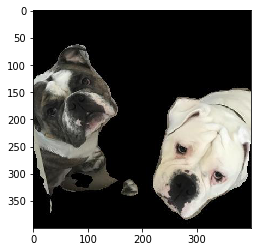

00001_cross_breed_-_large_42.jpg


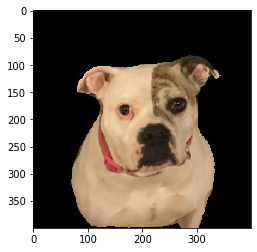

00002_maltipoo_57.jpg


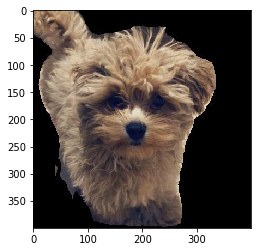

00003_pomchi_34.jpg


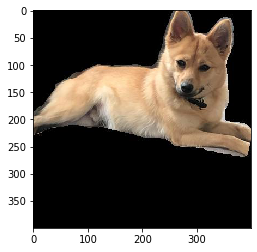

00004_chihuahua_27.jpg


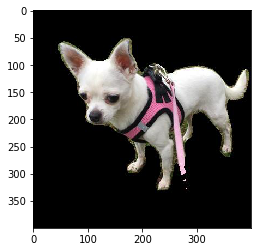

00005_cavapoo_51.jpg


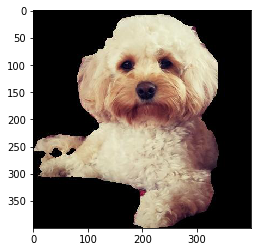

00006_japanese_shiba_inu_17.jpg


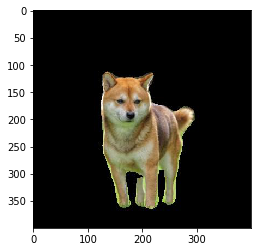

00007_pug_28.jpg


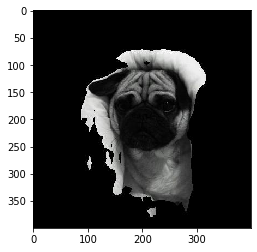

00008_miniature_poodle_44.jpg


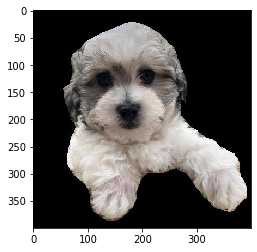

In [97]:
for file in pic_check_list[1:10]:
    print(file)
    plt.imshow(np.asarray(image.imread(pic_check_path+file)))
    plt.show()